# Phasing Ridibundus / Lessonae alleles from ddRADseq of hibridogens

<b>Date:</b> Dec, 2018  
<b>Author:</b> Dr. Daniel L. Jeffries, Department of Ecology and Evolution, University of Lausanne, Switzerland  
<b>Email:</b> dljeffries86@gmail.com

In this notebook we phase alleles that are specific to the two subgenomes present in hybridogenetic frogs from crosses between P. ridibundus (R) and P. lessonae (L). Depending on the cross, either the R or the L genome (or both) is  clonal. Throughout, the clonal genome is denoted with square brackets (e.g. an R[L]individual passes the L genome clonally and never the R). 

The data analysed below consist of both families, from several types of cross (differing in which of the subgenomes is clonal). 

The aim is to, for as many RADtags as possible, identify the R and L alleles and output VCF files whith doubled-haploid genotypes to be used in downstream analyses. 

The data is in the form of a VCF of genotypes. We will first deal with the family data only, thus the first VCF has genotypes for 5 familes:

Family_25: Father_13CZ3WF28M R[L] x Mother_13CZ1WF3F_RR  
Family_27: Father_13CZ3WF40M [R][L] x Mother_13CZ1WF3F_RR  
Family_30: Father_13CZ3WF40M [R][L] x Mother_13CZ3WF10F_RR  
Family_39: Father_13CZ3WF31M [R]L x Mother_13CZ3WF11F_RR  
Family_41: Father_13CZ3WF38M R[L] x Mother_13CZ3WF11F_RR  

The approach here will be to phase loci separately in each family, and then combine these phasings across families into a single VCF where each sample is split into its constituent phased sub-genomes. 



## Getting the data

If you would like to recreate the analyses below, the input files used here can be obtained like so:

`git clone https://github.com/DanJeffries/Hybridogen_paper`

Then set the working directory to wherever you just cloned the repository

In [13]:
working_dir = "/home/djeffrie/Data/RADseq/Hybridogens_paper/"  ## Set this to wherever you cloned the git repo. 

There are some functions used here which come from a module of miscellaneous custom scripts of mine.

They are written in python 2.7 and may be a bit buggy as they are mostly for personal use. But after installing some dependencies, and with some python proficiency they should be useful. They are not essential for the analyses below, but if you would like to use them, you can find them here:

https://github.com/DanJeffries/My_misc_scripts/blob/master/Python/My_Modules/MISC_RAD_tools.py  
https://github.com/DanJeffries/My_misc_scripts/blob/master/R/My_functions/Sex_sorter_PCA_plotting_function.R

Make sure you put this in your python path you can then Import the module as normal (as done in the cell below) like so:

    `import MISC_RAD_Tools as MISC`

You can then run functions as normal from that module. For example see the Summary_plotter usage a few cells below.

## Import Modules

In [10]:
%load_ext rpy2.ipython 

In [11]:
%matplotlib inline
from __future__ import division
from IPython.display import Image
import vcf
import MISC_RAD_tools as MISC  

## The data "at a glance"


In [14]:
vcf_path = "%s/Data_files/batch_1.vcf" % working_dir

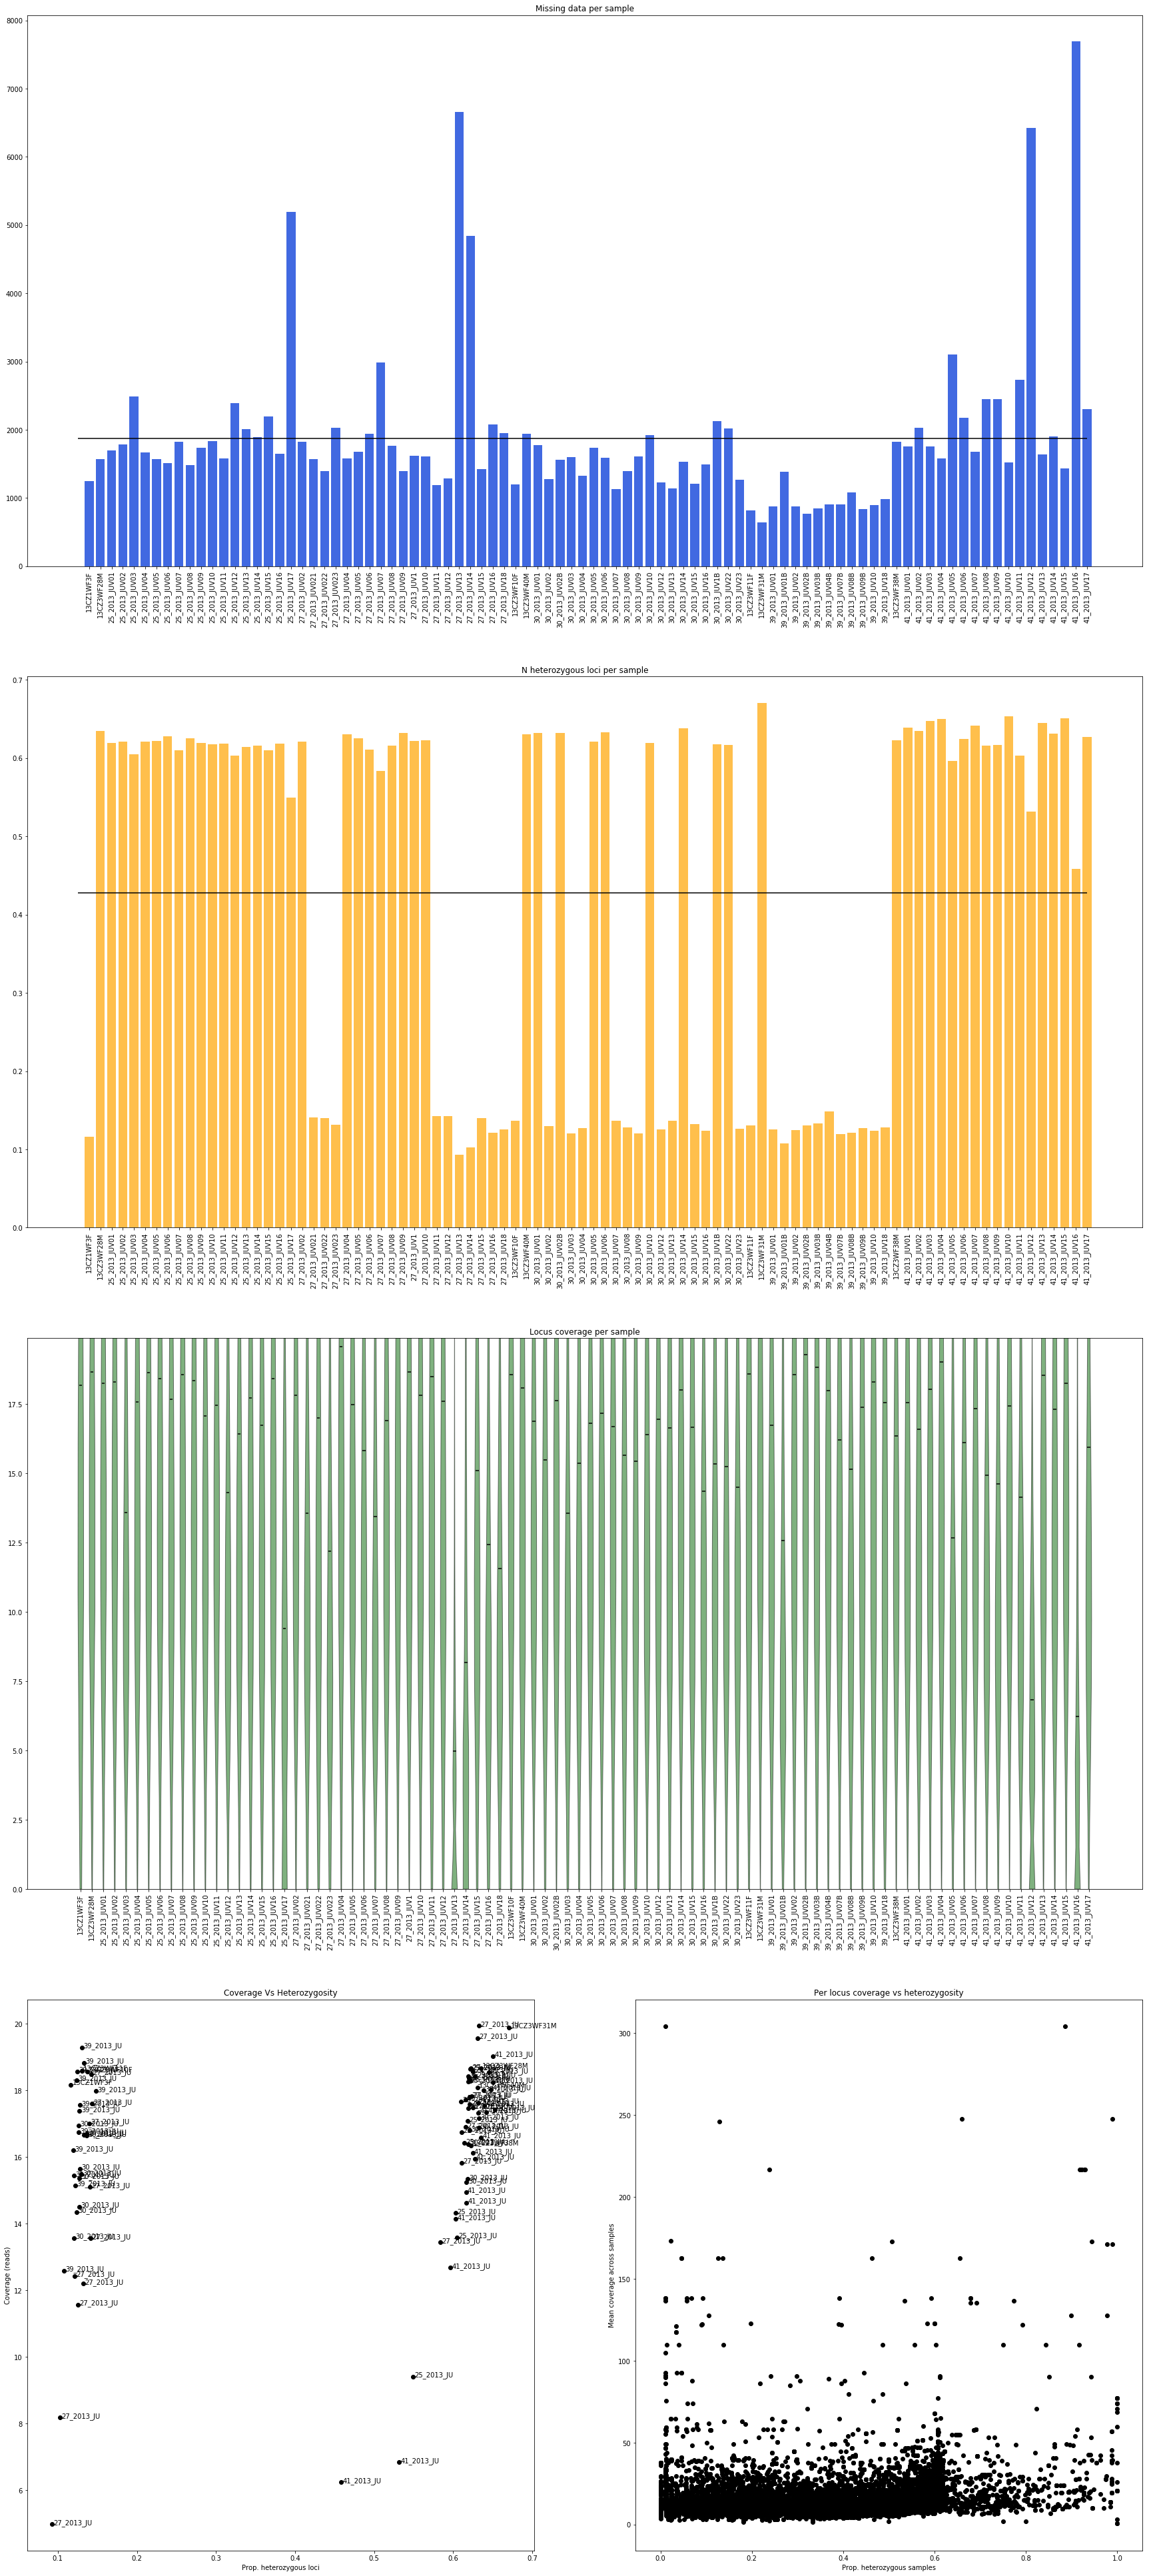

#### DONE ####

Number of Loci = 15676
Average coverage = 16.208485016 reads


In [8]:
MISC.Summary_plotter(vcf_path, "1111", False)  ## creates several plots for assessing the SNP calls from Stacks (its not parrellelised so can take a while with a large dataset - 10 mins or so)

### Raw data summary

So the data looks very nice, there a few low coverage samples with lots of missing data, but these can be removed/ignored later. Whats cool is there's a realy clear difference in heterozygosity between the individuals with the same genome (i.e. RR or R[R]) and those with different genomes i.e. [R]L, R[L] or [R][L].

So given this amount of heterozygosity, there must be a large number of loci with genome specific alleles. So generally there will likely be lots of loci with the potential to be phased. 

# Phasing strategy

Phasing families one by one is relatively trivial, the difficulty is combining those phasings across families, as a SNP informative in one family might not be in another. For this reason we have developed a theoretical framework in which to consider categories of loci which are informative in different ways and must therefore be treated in different ways when combining across the families. These categories differ based on the position at which the variant arose in the phylogenetic tree which describes the relatedness of all R and L genomes in the sample pool. 

The tree below shows a <b>theoretical</b> tree between R and L loci (the real tree is not known as it requires the phasing that we are trying to do!). The loci categories are as follows:

- $A^1$ loci: Loci containing snps which arose on either of the two basal red branches leading to the R or L clades. These will be diagnostic between R and L genomes, but not between different Rs or different Ls

- $A^2$ loci: Loci containing snps which arose on the red branches leading to separate L genomes. These will be diagnostic between R and L genomes, and may differ between L genomes, meaning the can also inform variation between L haplotypes. 

- $B$ loci: Loci containing snps which arose on a branch leading to a clonal R genome. These can be diagnostic between [R] and L, between [R] and R and also may differ between different [R] genomes, making them informative for the origin of the different [R] clones. 

- $C$ loci: Loci containing snps which arose on a branch leading to a sexual R genome and which are present in heterozygous form in both parents of the cross. These can be also shared by clonal R genomes recently derived from sexual Rs and will be informative for the variation between sexual and clonal Rs as well as of course being diagnostic between R and L. 

- $D$ loci: Loci containing snps which arose on a branch leading to a sexual R genome and which are present in heterozygous form only one of the parents of the cross. These can be also shared by clonal R genomes recently derived from sexual Rs and will be informative for the variation between sexual and clonal Rs as well as of course being diagnostic between R and L. 


These different types of variant are constrained in their possible genotypes in the parents (and thus the offspring). For example, in the cross RR x RL an $A^1$ locus must be in the form 0/0 x 0/1 where "1" here refers to the allelic variant specific to the L genome. If the RL parent passes its L genome clonally (i.e. it is R[L]) then all offspring must be RL and thus have the genotype 0/1. These expectations are set out in cross-specific schematics below, and will inform the tests implemented in the code below to characterise and phase each category of loci. 

Once each family is phased, the loci will be combined using checks for discrepencies based on this tree. 

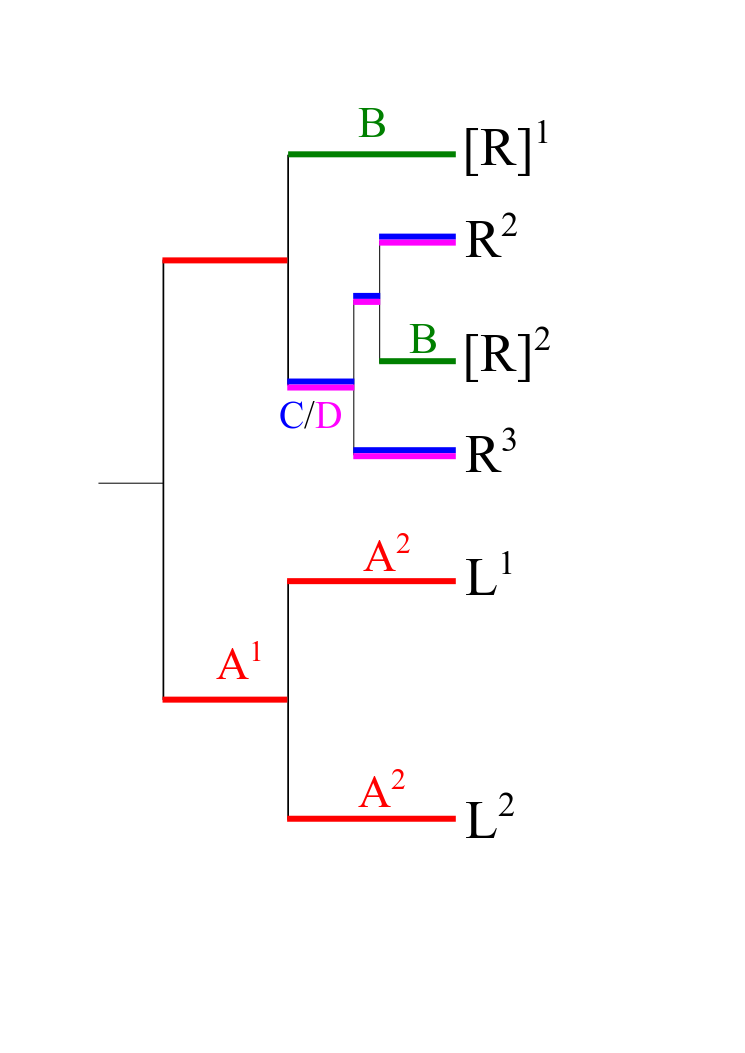

In [15]:
Image("%s/Schematics/Phasing_schematic_color_coordinated.png" % working_dir, width=900)

## Family 25

The schematic below shows the different combinations of variants in the cross for family 25 (and also 41), and what to expect in the offspring. Locus types and their colours in the figure correspond to the phylogeny schematic above and the same notation is used in the scripts. We will use schematics like this for each crossing type to inform the expectations of our scripts.

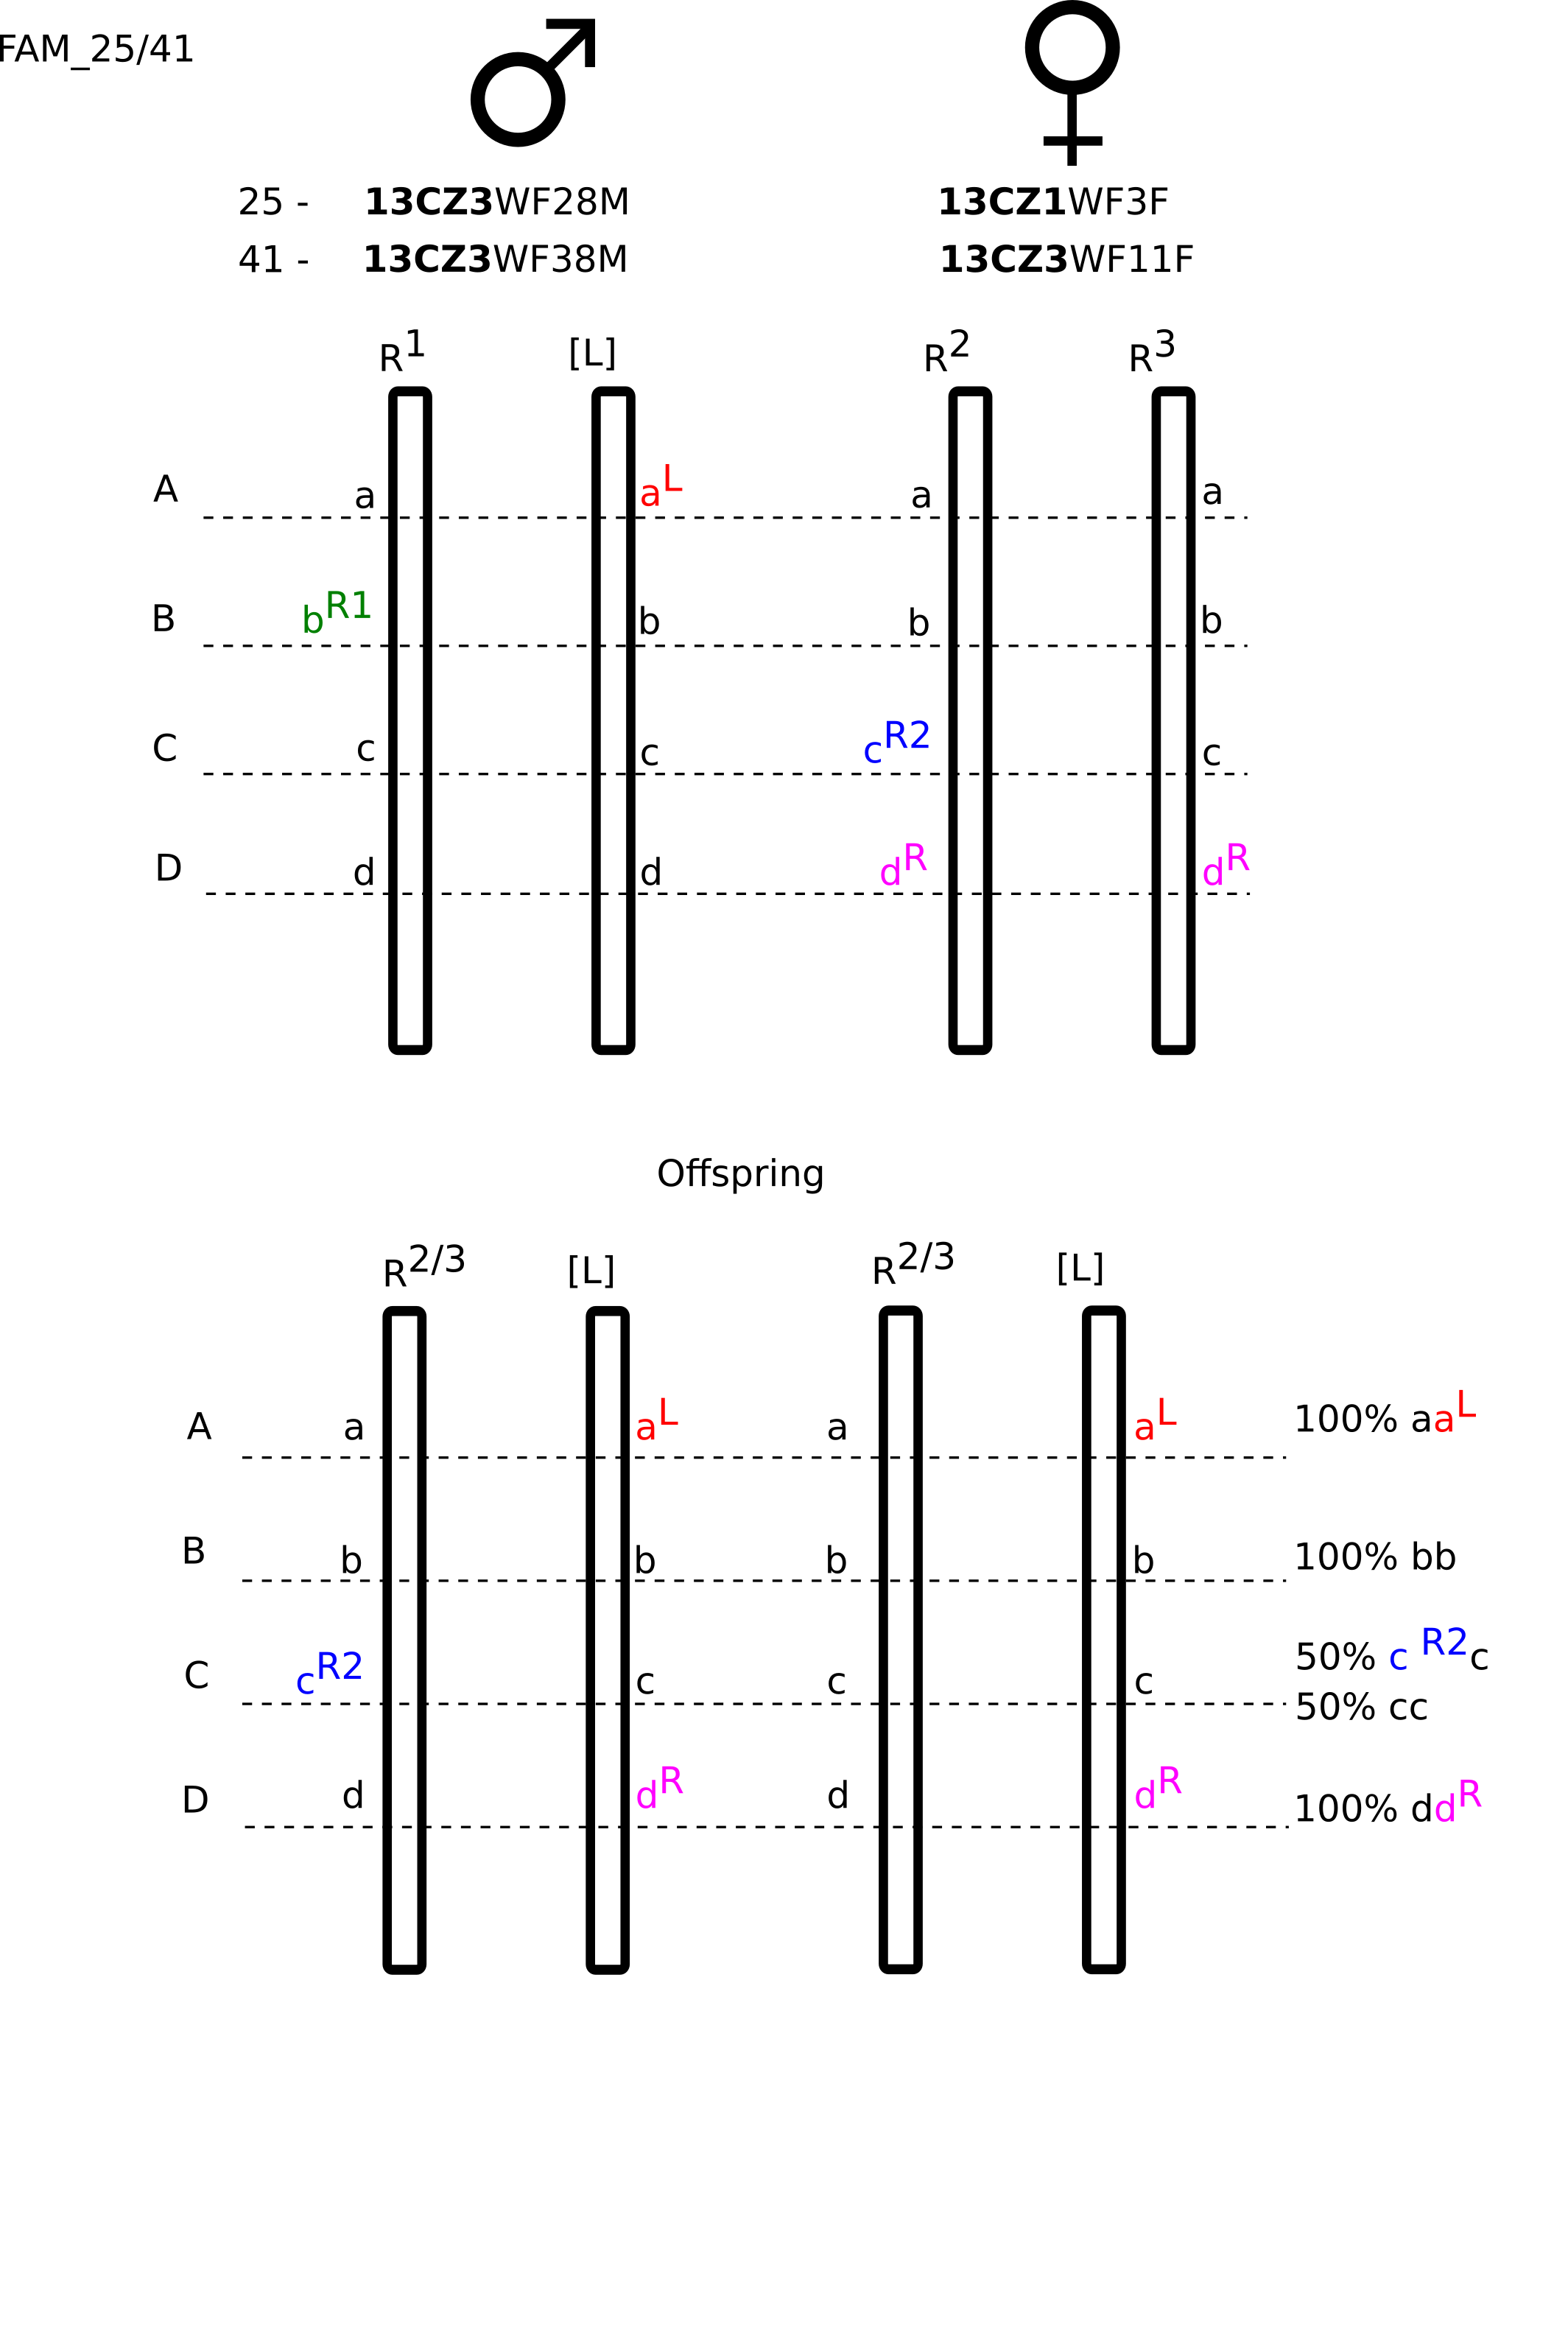

In [5]:
Image("%s/Schematics/FAM_25_41_schematic.png" % working_dir, width=900)

Based on the family schematic above, the following expectations will be tested in the following code blocks, to identify loci which fit each category (A, B, C or D).

<b>Test to find the $a^L$ alleles:</b>

- loci are heterozygous in the father (R[L])
- loci are homozygous in the mother (RR).
- loci are heterozygous in all offspring (all R[L])


<b>$a^L$ allele is then the allele which is specific to the father. </b>

NOTE: this method might be sensitive to null alleles in the mother. 

<b>Test to find the $b^{R1}$ alleles:</b>

- loci are heterozygous in the father (R[L])
- loci are homozygous in the mother (RR).
- loci are homozygous in all offspring (all R[L])

<b>$b^{R1}$ allele is then the allele which is specific to the father. </b>

NOTE: this method might be sensitive to null alleles in the father. 

<b>Test to find the $c^{R2}$ alleles (C in figure above):</b>

- loci are homozygous in the father (R[L]).
- loci are heterozygous in the mother (RR)
- loci are heterozygous in 50% of offspring (all R[L])

<b>$c^{R2}$ allele is then the allele which is specific to the mother. </b>

<b>Test to find the $d^R$ alleles:</b>
    
- loci are fixed for alternate genotypes in the mother and father
- loci are heterozygous in all offspring

<b>$d^R$ allele is then the allele which is specific to the mother. </b>

NOTE: this method might be sensitive to null alleles in the father. 



### First get known sample genotypes

Based on sample information we have a list of sample names and their genotypes (RR or RL). This dictionary will be used throughout to examine RR and RL samples separately. 


In [17]:
## First, make a dictionary of samples and genotypes

## open file containing sample genotypes e.g. RR, RL, LL
sample_GTs = open("%s/Data_files/sample_GTs.txt" % working_dir, 'r').readlines()

GT_dict = {}

for line in sample_GTs:
    GT_dict[line.split()[0]] = line.split()[1]
    
    
## open file containing more explicit sample genotypes e.g. R[R], R[L], LL etc.
sample_GTs = open("%s/Data_files/sample_GTs_explicit.txt" % working_dir, 'r').readlines()

GT_exp_dict = {}

for line in sample_GTs:
    GT_exp_dict[line.split()[0]] = line.split()[1]
    

In [29]:
Mother = "13CZ1WF3F"
Father = "13CZ3WF28M"

cov_threshold = 15

offspring_identifier = "25_"
offspring_het_threshold = 0.8  ## out of 17 total offspring (allowing for a couple of missed calls)

myvcf = vcf.Reader(open(vcf_path, 'r'))

#record = myvcf.next() # for testing

phased_loci_fam_25 = {}
phased_loci_fam_25["A_loci"] = {}
phased_loci_fam_25["B_loci"] = {}
phased_loci_fam_25["C_loci"] = {}
phased_loci_fam_25["D_loci"] = {}


A_loci = 0
B_loci = 0
C_loci = 0
D_loci = 0
homomorphic_loci = 0
heterozygous_loci = 0
not_phasable = 0
not_enough_data = 0

for record in myvcf:  ## for each locus in the vcf
    
    N_offspring = 0  ## counter for number of offspring in family
    het_offspring = 0 ## counter for number of heterozygous offspring
    N_offspring_called = 0  ## counter for number of offspring called at this locus
    offspring_alleles = []  ## record alleles in offspring 
    
    for sample in record.samples:    ## for all samples at this locus
        
        if offspring_identifier in sample.sample:
            N_offspring += 1  ## count the number of offspring (gets done each locus, not efficient but works) 
        
        if sample.called and sample['DP'] >= cov_threshold:
        
            if sample.sample == Mother:
                Mother_called = True  ## logical for if mother called?
                Mother_het = sample.is_het  ## logical for if mother her
                Mothers_GT = sample["GT"]  ## get mothers genotype "0/0" format
                Mothers_GT_bases = sample.gt_bases  ## get mothers genotype "A/A" format

            elif sample.sample == Father:  # same for father
                Father_called = True
                Father_het = sample.is_het
                Fathers_GT = sample["GT"]
                Fathers_GT_bases = sample.gt_bases

            elif offspring_identifier in sample.sample: ## if sample is offspring

                N_offspring_called += 1  ## count the offspring call
                offspring_alleles.append(sample.gt_bases.split("/")[0])
                offspring_alleles.append(sample.gt_bases.split("/")[1])

                if sample.is_het:
                    het_offspring += 1  ## count if the offspring is heterozygous. 
                

    ## now perform tests to see if locus fits the criteraia for being phasable.            
                
    if all([Mother_called == True, Father_called == True, N_offspring_called > (N_offspring*0.8)]): ## if there are enough calls at the locus.
        
        ## A loci
        
        if all([Mother_het == False, Father_het == True, (het_offspring / N_offspring_called) >= offspring_het_threshold]): ## if mother is homozygous, father is heterozygous, and offspring are heterozygous (above threshold)
            
            A_loci += 1  ## count locus as phasable
            
            ## now get the aL allele. 
            
            for allele in Fathers_GT_bases.split("/"):  ## for the alleles in the father
                
                if allele not in Mothers_GT_bases.split("/"):  ## if allele not in mother
                    
                    ## make an entry in the phased dictionary, recording the L and R alleles at this locus in this family.
                    phased_loci_fam_25["A_loci"][record.ID] = {} 
                    phased_loci_fam_25["A_loci"][record.ID]["aL"] = allele
                    phased_loci_fam_25["A_loci"][record.ID]["a"] = Mothers_GT_bases.split("/")[0]
                    
        ## B loci
        
        elif all([Mother_het == False, Father_het == True, (het_offspring / N_offspring_called) <= N_offspring_called*(1-offspring_het_threshold)]): 
            
            B_loci += 1  ## count locus as phasable
            
            ## now get the bR1 allele. 
            
            for allele in Fathers_GT_bases.split("/"):  ## for the alleles in the father
                
                if allele not in Mothers_GT_bases.split("/"):  ## if allele not in mother
                    
                    ## make an entry in the phased dictionary, recording the L and R alleles at this locus in this family.
                    
                    phased_loci_fam_25["B_loci"][record.ID] = {} 
                    phased_loci_fam_25["B_loci"][record.ID]["b_R1"] =  allele
                    phased_loci_fam_25["B_loci"][record.ID]["b"] = Mothers_GT_bases.split("/")[0]
                
        
        ## C loci
        
        elif all([Mother_het == True, Father_het == False, 0.4 <= (het_offspring / N_offspring_called) <= 0.6 ]):
                
            C_loci += 1  ## count locus as phasable
            
            ## now get the cR2 allele. 
            
            for allele in Mothers_GT_bases.split("/"):  ## for the alleles in the father
                
                if allele not in Fathers_GT_bases.split("/"):  ## if allele not in mother
                    
                    ## make an entry in the phased dictionary, recording the L and R alleles at this locus in this family.
                    
                    phased_loci_fam_25["C_loci"][record.ID] = {} 
                    phased_loci_fam_25["C_loci"][record.ID]["c_R2"] =  allele
                    phased_loci_fam_25["C_loci"][record.ID]["c"] = Fathers_GT_bases.split("/")[0]
                    
        ## D loci
        
        elif all([Mother_het == False, Father_het == False, Mothers_GT_bases.split("/")[0] != Fathers_GT_bases.split("/")[0], (het_offspring / N_offspring_called) >= offspring_het_threshold ]):
                
            D_loci += 1  ## count D locus 
            
            ## now get the dR allele.
            
            for allele in Mothers_GT_bases.split("/"):
                
                if allele not in Fathers_GT_bases.split("/"):
                    
                    phased_loci_fam_25["D_loci"][record.ID] = {}
                    phased_loci_fam_25["D_loci"][record.ID]["d_R"] = allele
                    phased_loci_fam_25["D_loci"][record.ID]["d"] = Fathers_GT_bases.split("/")[0]
                    
        
        elif all([Mother_het == False, Father_het == False, (het_offspring / N_offspring_called) == 0, Mothers_GT_bases.split("/")[0] == Fathers_GT_bases.split("/")[0] == list(set(offspring_alleles))[0]]):
            
            homomorphic_loci += 1
            
        elif all([Mother_het == True, Father_het == True]):
            
            heterozygous_loci += 1
        
        else:
            
            #print "LOCUS: %s: Mothers GT: %s, Fathers GT: %s, Offspring heterozygosity: %s, Offspring alleles: %s" % (record.ID, Mothers_GT_bases, Fathers_GT_bases, (het_offspring / N_offspring_called), set(offspring_alleles))
            
            not_phasable += 1
    
    else:
        not_enough_data += 1
        

print "%s A loci" % A_loci
print "%s B loci" % B_loci
print "%s C loci" % C_loci
print "%s D loci" % D_loci
print "%s loci homomorphic in this family" % homomorphic_loci
print "%s loci heterozygous in both parents" % heterozygous_loci
print "%s Not phasable" % not_phasable
print "%s Not enough data" % not_enough_data

1342 A loci
186 B loci
53 C loci
138 D loci
302 loci homomorphic in this family
197 loci heterozygous in both parents
304 Not phasable
7361 Not enough data


So a lot of loci can be phased between R and L. Fewer for the male specific R but still quite a few - I think this is to be expected as the male and female come different populations. And the number of loci polymorphic in the female is relatively small. 

There are some loci left over (listed as "Not phasable") which consist of loci with various issues - many likely due to either null alleles in parents, or paralogous overmerged loci. Either way they are of no use so I didn't try to catch these edge cases explicitly. It is enough just to know that they are because of the inevitable messiness in RAD data.

Note I have put a pretty strict coverage cut off on here so a lot of loci get kicked out (listed as "Not enough data") - hopefully this means we are dealing with pretty clean data, and not many loci are needed just to look at structure between sub-genomes, so I think this is the best strategy. 

## Family 41

Same schamatic as above

In [30]:
## same as for Family 25

Mother = "13CZ3WF11F"
Father = "13CZ3WF38M"

offspring_identifier = "41_"
offspring_het_threshold = 0.8  ## out of 17 total offspring (allowing for a couple of missed calls)

cov_threshold = 15

myvcf = vcf.Reader(open(vcf_path, 'r'))

#record = myvcf.next()

phased_loci_fam_41 = {}
phased_loci_fam_41["A_loci"] = {}
phased_loci_fam_41["B_loci"] = {}
phased_loci_fam_41["C_loci"] = {}
phased_loci_fam_41["D_loci"] = {}

A_loci = 0
B_loci = 0
C_loci = 0
D_loci = 0
homomorphic_loci = 0
heterozygous_loci = 0
not_phasable = 0
not_enough_data = 0

for record in myvcf:
    N_offspring = 0
    het_offspring = 0
    N_offspring_called = 0
    
    for sample in record.samples:
        
        if offspring_identifier in sample.sample:
            N_offspring += 1  ## count the number of offspring (gets done each locus, not efficient but works) 
        
        if sample.called and sample['DP'] >= cov_threshold:
        
            if sample.sample == Mother:
                Mother_called = True
                Mother_het = sample.is_het
                Mothers_GT = sample["GT"]
                Mothers_GT_bases = sample.gt_bases

            elif sample.sample == Father:
                Father_called = True
                Father_het = sample.is_het
                Fathers_GT = sample["GT"]
                Fathers_GT_bases = sample.gt_bases

            elif offspring_identifier in sample.sample:
    
                N_offspring_called += 1
                
                if sample.is_het:
                    het_offspring += 1

    ## now perform tests to see if locus fits the criteraia for being phasable.            
                
    if all([Mother_called == True, Father_called == True, N_offspring_called > (N_offspring*0.8)]): ## if there are enough calls at the locus.
        
        ## A loci
        
        if all([Mother_het == False, Father_het == True, (het_offspring / N_offspring_called) >= offspring_het_threshold]): ## if mother is homozygous, father is heterozygous, and offspring are heterozygous (above threshold)
            
            A_loci += 1  ## count locus as phasable
            
            ## now get the aL allele. 
            
            for allele in Fathers_GT_bases.split("/"):  ## for the alleles in the father
                
                if allele not in Mothers_GT_bases.split("/"):  ## if allele not in mother
                    
                    ## make an entry in the phased dictionary, recording the L and R alleles at this locus in this family.
                    phased_loci_fam_41["A_loci"][record.ID] = {} 
                    phased_loci_fam_41["A_loci"][record.ID]["aL"] =  allele
                    phased_loci_fam_41["A_loci"][record.ID]["a"] = Mothers_GT_bases.split("/")[0]
                    
        ## B loci
        
        elif all([Mother_het == False, Father_het == True, (het_offspring / N_offspring_called) <= N_offspring_called*(1-offspring_het_threshold)]): 
            
            B_loci += 1  ## count locus as phasable
            
            ## now get the bR1 allele. 
            
            for allele in Fathers_GT_bases.split("/"):  ## for the alleles in the father
                
                if allele not in Mothers_GT_bases.split("/"):  ## if allele not in mother
                    
                    ## make an entry in the phased dictionary, recording the L and R alleles at this locus in this family.
                    
                    phased_loci_fam_41["B_loci"][record.ID] = {} 
                    phased_loci_fam_41["B_loci"][record.ID]["b_R1"] =  allele
                    phased_loci_fam_41["B_loci"][record.ID]["b"] = Mothers_GT_bases.split("/")[0]
                
        
        ## C loci
        
        elif all([Mother_het == True, Father_het == False, 0.4 <= (het_offspring / N_offspring_called) <= 0.6 ]):
                
            C_loci += 1  ## count locus as phasable
            
            ## now get the cR2 allele. 
            
            for allele in Mothers_GT_bases.split("/"):  ## for the alleles in the father
                
                if allele not in Fathers_GT_bases.split("/"):  ## if allele not in mother
                    
                    ## make an entry in the phased dictionary, recording the L and R alleles at this locus in this family.
                    
                    
                    phased_loci_fam_41["C_loci"][record.ID] = {} 
                    phased_loci_fam_41["C_loci"][record.ID]["c_R2"] =  allele
                    phased_loci_fam_41["C_loci"][record.ID]["c"] = Fathers_GT_bases.split("/")[0]
        
        ## D loci
        
        elif all([Mother_het == False, Father_het == False, Mothers_GT_bases.split("/")[0] != Fathers_GT_bases.split("/")[0], (het_offspring / N_offspring_called) >= offspring_het_threshold ]):
                
            D_loci += 1  ## count D locus 
            
            ## now get the dR allele.
            
            for allele in Mothers_GT_bases.split("/"):
                
                if allele not in Fathers_GT_bases.split("/"):
                    
                    phased_loci_fam_41["D_loci"][record.ID] = {}
                    phased_loci_fam_41["D_loci"][record.ID]["d_R"] = allele
                    phased_loci_fam_41["D_loci"][record.ID]["d"] = Fathers_GT_bases.split("/")[0]
                    
                  
        elif all([Mother_het == False, Father_het == False, (het_offspring / N_offspring_called) == 0, Mothers_GT_bases.split("/")[0] == Fathers_GT_bases.split("/")[0] == list(set(offspring_alleles))[0]]):
            
            homomorphic_loci += 1
            
        elif all([Mother_het == True, Father_het == True]):
            
            heterozygous_loci += 1
        
        else:

            not_phasable += 1

    else:
                       
        not_enough_data += 1
        

print "%s A loci" % A_loci
print "%s B loci" % B_loci
print "%s C loci" % C_loci
print "%s D loci" % D_loci
print "%s loci homomorphic in this family" % homomorphic_loci
print "%s loci heterozygous in both parents" % heterozygous_loci
print "%s Not phasable" % not_phasable
print "%s Not enough data" % not_enough_data

818 A loci
92 B loci
55 C loci
70 D loci
56 loci homomorphic in this family
119 loci heterozygous in both parents
317 Not phasable
8356 Not enough data


Numbers per locus category are comparable to those of family 25.

Now I will compare these phasings between then two families.

In [718]:
print "Number of loci phased in family 25 = %s" % len(phased_loci_fam_25_RLclon["A_loci"])
print "Number of loci phased in family 41 = %s" % len(phased_loci_fam_41_LclonR["A_loci"])

all_phased = phased_loci_fam_25_RLclon["A_loci"].keys() + phased_loci_fam_41_LclonR["A_loci"].keys()

print "Number of loci phased in at least one family = %s" % (len(set(all_phased)))

aL_both_count = 0
aL_matches = 0

b_both_count = 0
b_matches = 0

c_both_count = 0
c_matches = 0


for shared_locus in phased_loci_fam_25_RLclon["A_loci"].viewkeys() & phased_loci_fam_41_LclonR["A_loci"].viewkeys():
    aL_both_count += 1
    
    if all([phased_loci_fam_25_RLclon["A_loci"][shared_locus]["aL"] == phased_loci_fam_41_LclonR["A_loci"][shared_locus]["aL"],phased_loci_fam_25_RLclon["A_loci"][shared_locus]["a"] == phased_loci_fam_41_LclonR["A_loci"][shared_locus]["a"]]):
        aL_matches += 1
        
    #else:
        #print shared_locus
        #print phased_loci_fam_25_RLclon["A_loci"][shared_locus]["aL"], phased_loci_fam_41_LclonR["A_loci"][shared_locus]["aL"]
        #print phased_loci_fam_25_RLclon["A_loci"][shared_locus]["a"], phased_loci_fam_41_LclonR["A_loci"][shared_locus]["a"]
    
for shared_locus in phased_loci_fam_25_RLclon["B_loci"].viewkeys() & phased_loci_fam_41_LclonR["B_loci"].viewkeys():
    b_both_count += 1
    
    if all([phased_loci_fam_25_RLclon["B_loci"][shared_locus]["b_R1"] == phased_loci_fam_41_LclonR["B_loci"][shared_locus]["b_R1"],phased_loci_fam_25_RLclon["B_loci"][shared_locus]["b"] == phased_loci_fam_41_LclonR["B_loci"][shared_locus]["b"]]):
        b_matches += 1
        
    #else:
        #print shared_locus
        #print phased_loci_fam_25_RLclon["B_loci"][shared_locus]["b_R1"], phased_loci_fam_41_LclonR["B_loci"][shared_locus]["b_R1"]
        #print phased_loci_fam_25_RLclon["B_loci"][shared_locus]["b"], phased_loci_fam_41_LclonR["B_loci"][shared_locus]["b"]
        
for shared_locus in phased_loci_fam_25_RLclon["C_loci"].viewkeys() & phased_loci_fam_41_LclonR["C_loci"].viewkeys():
    c_both_count += 1
    
    if all([phased_loci_fam_25_RLclon["C_loci"][shared_locus]["c_R2"] == phased_loci_fam_41_LclonR["C_loci"][shared_locus]["c_R2"],phased_loci_fam_25_RLclon["C_loci"][shared_locus]["c"] == phased_loci_fam_41_LclonR["C_loci"][shared_locus]["c"]]):
        c_matches += 1
    

print "\nNumber of A loci phased in both families = %s" % aL_both_count
print "Number of consistent A phasings in shared loci = %s " % aL_matches

print "\nNumber of B loci phased in both families = %s" % b_both_count
print "Number of consistent B phasings in shared loci = %s " %  b_matches

print "\nNumber of C loci phased in both families = %s" % c_both_count
print "Number of consistent C phasings in shared loci = %s " % c_matches

Number of loci phased in family 25 = 1937
Number of loci phased in family 41 = 1067
Number of loci phased in at least one family = 2229

Number of A loci phased in both families = 775
Number of consistent A phasings in shared loci = 708 

Number of B loci phased in both families = 45
Number of consistent B phasings in shared loci = 31 

Number of C loci phased in both families = 0
Number of consistent C phasings in shared loci = 0 


So, many of the A loci which could be phased for R vs L were shared among both families - and their phasings almost always completely matched. The cases that don't (about 85 of them) are weired, the SNP in one family seems completely different from that of the other family, e.g. A/T in one family and C/G in the other, at the same site. Maybe this is a paralog issue? I find it hard to believe that there has been two independent mutations at the same site between these families.  

For the B loci specific to the male R, not many phased in both families, but again very few disagreed. In all cases the bases are the same, but the phase is just reversed between families - not sure how this can occur. In both families, the male is always heterozygous, the allele phased is the one which is not in the mother, and it is never in the offspring - so how do these inconsistencies between the families arise? Maybe some ancestral polymorphism? Maybe come back to this if it seems significant, but for now, given that it is so few loci, lets move on.

### So what happens to the loci that can be phased in one family and not the other?
- are these loci missing in those families?
- are they not phasable in those families?
    - if so why? No L specific allele?
 
lets take a look at things and see whats going on . . . 

In [ ]:
## get loci that are phased in family 25 and not in family 41
Mother_41 = "13CZ3WF11F"
Father_41 = "13CZ3WF38M"

Mother_25 = "13CZ1WF3F"
Father_25 = "13CZ3WF28M"


not_shared = []

for locus in phased_loci_fam_25_RLclon["A_loci"]:
    if locus not in phased_loci_fam_41_LclonR["A_loci"]:
        not_shared.append(locus)

myvcf = vcf.Reader(open(vcf_path, 'r'))

for record in myvcf:
    if record.ID in not_shared[:20]:
        print record.ID
        for sample in record.samples:
            if "25_" in sample.sample or "41_" in sample.sample or Mother_25 in sample.sample or Father_25 in sample.sample or Mother_41 in sample.sample or Father_41 in sample.sample:
                print sample.sample, sample["GT"]



So mostly it seems that the reason loci were phased in one family and not the other was because of missing data in too many offspring or one of the parents. But there were a couple of examples where either both parents were homozygous for different alleles (and all offspring were heterozygous suggesting this is real, not a null allele in one parent), or where there was an excess of homozygotes for the minor parental allele. I guess this could be caused by all sorts of things, e.g. null allele in one parent (so there were in fact two heterozygous parents due to shared ancestral polymorphism(?))

## Families 27 and 30

Both families 27 and 30 have the mating combination [R][L] x RR

In these families, two types of offspring will be produced, R[R] and R[L]. Both of which can be used, the R[R] individuals can be used to find alleles specific to the [R] genome, which are not present in the sexual R genome. However, these are likely to be very few, as the [R] genome can only stay clonal for a single generation. Also, the heterozygosity plot above suggests that there will be very very few as well. 

The R[L] samples will be useful for find thing L and R specific alleles in this family. 


## Family 27

<b> Phasing R vs L loci again here first </b>

Note that Family 27 has the same mother as family 25. So the resulting phased R genomes should be pretty much identical at the share loci. 

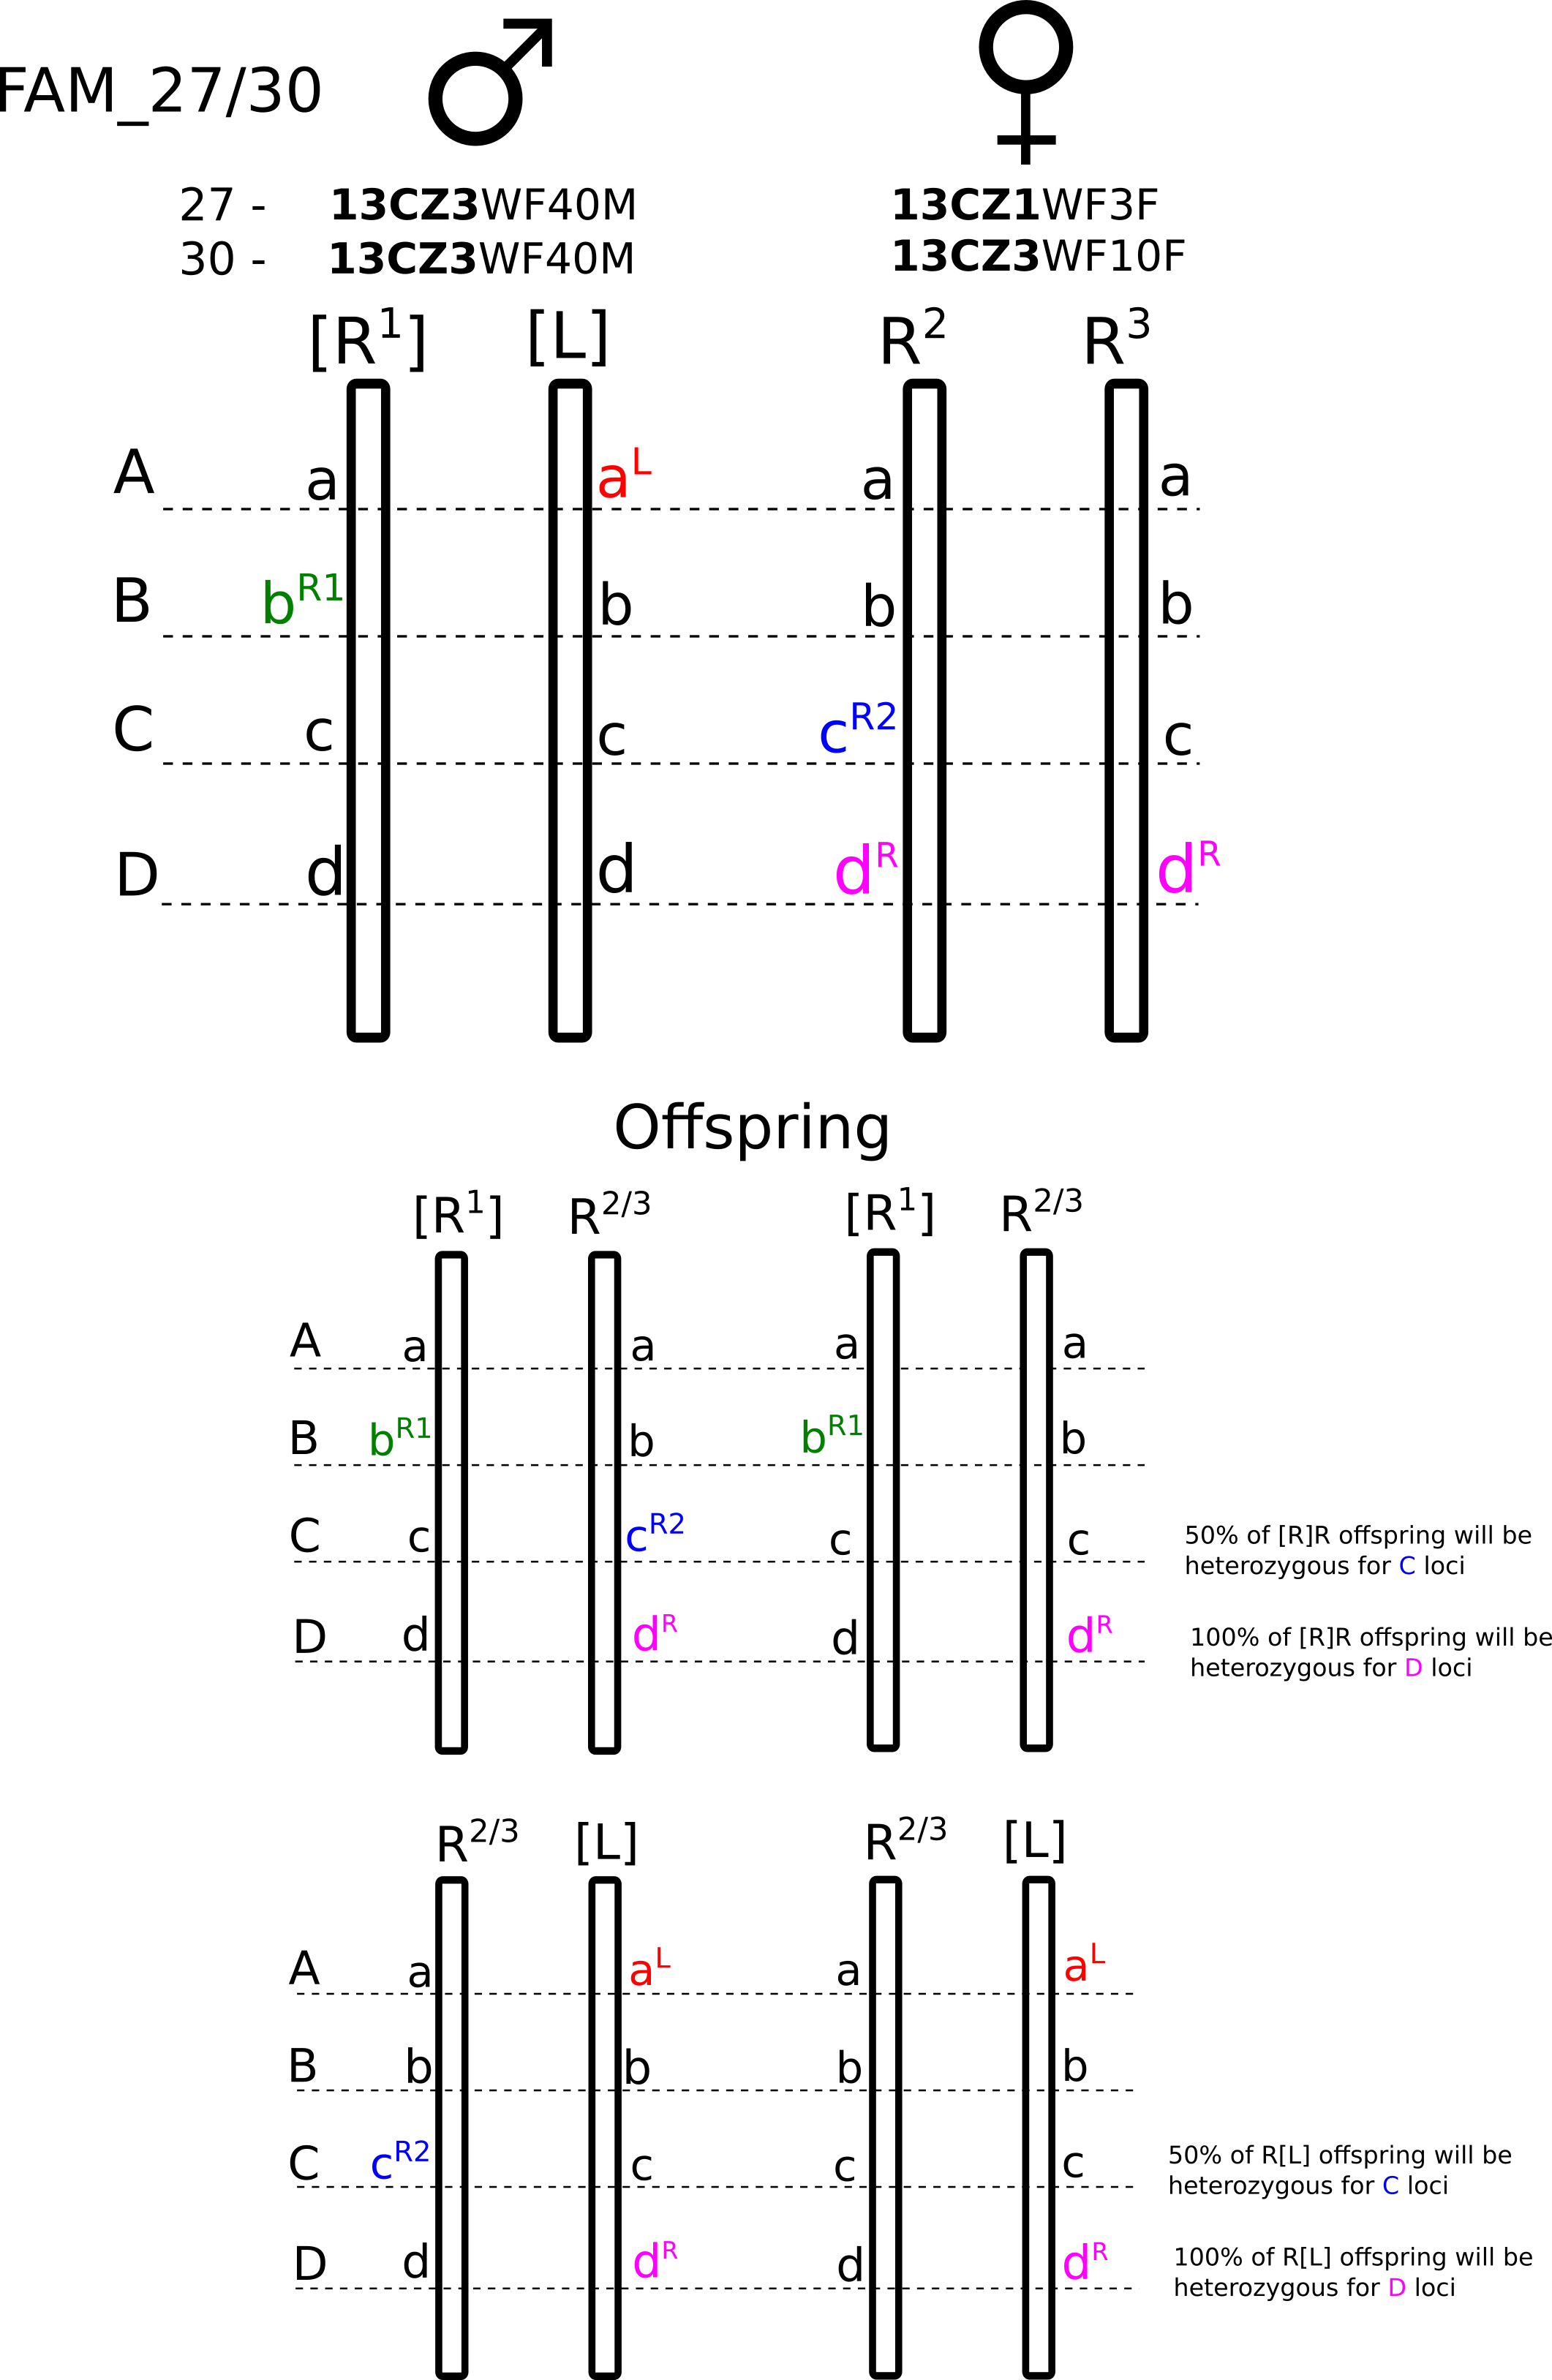

In [3]:
Image("/home/djeffrie/Data/RADseq/Hybridogens/FAM_27_30_schematic.png", width=900)

Based on the family schematic above, the following expectations will be tested in the following code blocks, to identify loci which fit each category (A, B, C or D).

<b>Test to find the $a^L$ alleles:</b>

- loci are heterozygous in the father (R[L])
- loci are homozygous in the mother (RR).
- loci are homozygous in all [R]R offspring and heterozygous in all R[L] offspring.

<b>$a^L$ allele is then the allele which is specific to the father and R[L] offspring. </b>

NOTE: this method might be sensitive to null alleles in the mother. 

<b>Test to find the $b^{R1}$ alleles:</b>

- loci are heterozygous in the father (R[L])
- loci are homozygous in the mother (RR).
- loci are heterozygous in all [R]R offspring and homozygous (for maternal allele) in all R[L] offspring.

<b>$b^{R1}$ allele is then the allele which is specific to the father. </b>

NOTE: this method might be sensitive to null alleles in the father. 

<b>Test to find the $c^{R2}$ alleles (C in figure above):</b>

- loci are homozygous in the father (RL).
- loci are heterozygous in the mother (R[L])
- loci are heterozygous in 50% all R[L] offspring and heterozygous in 50% of all [R]R offspring

<b>$c^{R2}$ allele is then the allele which is specific to the mother. </b>

<b>Test to find the $d^R$ alleles:</b>
    
- loci are fixed for alternate genotypes in the mother and father
- loci are heterozygous in all offspring

<b>$d^R$ allele is then the allele which is specific to the mother. </b>

NOTE: this method might be sensitive to null alleles in the father. 



In [31]:
Mother = "13CZ1WF3F"
Father = "13CZ3WF40M"

offspring_identifier = "27_"
offspring_het_threshold = 0.8  

cov_threshold = 10

myvcf = vcf.Reader(open(vcf_path, 'r'))

record = myvcf.next()

phased_loci_fam_27 = {}
phased_loci_fam_27["A_loci"] = {}
phased_loci_fam_27["B_loci"] = {}
phased_loci_fam_27["C_loci"] = {}
phased_loci_fam_27["D_loci"] = {}


RR_phasable = 0
RL_phasable = 0
R2_phasable = 0
D_loci = 0
homomorphic_loci = 0
heterozygous_loci = 0
not_phasable = 0
not_enough_data = 0

## Use the offspring genotypes here, as I want to look at the R[R] and R[L] offspring separately here

sample_GTs

RR_offspring = []
RL_offspring = []

for record in myvcf:
    
    N_RR_offspring_called = 0
    N_RL_offspring_called = 0
    het_RR_offspring = 0
    het_RL_offspring = 0
    het_RL_offspring = 0
    RR_offspring_gts = []
    RL_offspring_gts = []
    
    for sample in record.samples:
        
        ## count offspring in family
        
        if offspring_identifier in sample.sample:
            if GT_dict[sample.sample] == "RR":
                if sample.sample not in RR_offspring:
                    RR_offspring.append(sample.sample)
            elif GT_dict[sample.sample] == "RL":
                if sample.sample not in RL_offspring:
                    RL_offspring.append(sample.sample)
        
        ## if coverage is high enough, record info of locus
        
        if sample.called and sample["DP"] >= cov_threshold:
        
            if sample.sample == Mother:
                Mother_called = True
                Mother_het = sample.is_het
                Mothers_GT = sample["GT"]
                Mothers_GT_bases = sample.gt_bases
                
            elif sample.sample == Father:
                Father_called = True
                Father_het = sample.is_het
                Fathers_GT = sample["GT"]
                Fathers_GT_bases = sample.gt_bases
                
            elif offspring_identifier in sample.sample:
                
                if GT_dict[sample.sample] == "RR":
                    
                    RR_offspring_gts.append(sample["GT"])

                    if sample.called:
                        N_RR_offspring_called += 1
                    if sample.is_het:
                        het_RR_offspring += 1
                        
                elif GT_dict[sample.sample] == "RL":
                    
                    RL_offspring_gts.append(sample["GT"])

                    if sample.called:
                        N_RL_offspring_called += 1
                    if sample.is_het:
                        het_RL_offspring += 1
    
    if all([Mother_called == True, Father_called == True, N_RR_offspring_called > (len(RR_offspring)*0.8), N_RL_offspring_called > (len(RL_offspring)*0.8)]):
        

        ## A loci - R clon L samples
        
        if all([Mother_het == False, Father_het == True, (het_RL_offspring / N_RL_offspring_called) >= offspring_het_threshold, (het_RR_offspring / N_RR_offspring_called) <= 1-offspring_het_threshold]):
            RL_phasable += 1

            for allele in Fathers_GT_bases.split("/"):
                if allele not in Mothers_GT_bases.split("/"):
                    
                    phased_loci_fam_27["A_loci"][record.ID] = {}
                    phased_loci_fam_27["A_loci"][record.ID]["aL"] = allele
                    phased_loci_fam_27["A_loci"][record.ID]["a"] = Mothers_GT_bases.split("/")[0]
                    
        ## B loci - R clon R samples
        
        elif all([Mother_het == False, Father_het == True, (het_RR_offspring / N_RR_offspring_called) >= offspring_het_threshold, (het_RL_offspring / N_RL_offspring_called) <= 1-offspring_het_threshold]):
            RR_phasable += 1
            
            for allele in Fathers_GT_bases.split("/"):
                if allele not in Mothers_GT_bases.split("/"):
                    
                    phased_loci_fam_27["B_loci"][record.ID] = {}
                    phased_loci_fam_27["B_loci"][record.ID]["b_R1"] = allele
                    phased_loci_fam_27["B_loci"][record.ID]["b"] = Mothers_GT_bases.split("/")[0]
                    
        ## C loci - R2 loci
        
        elif all([Mother_het == True, Father_het == False, 0.4 <= ((het_RR_offspring+het_RL_offspring) / (N_RR_offspring_called+N_RL_offspring_called)) <= 0.6]):
            R2_phasable += 1
            
            for allele in Mothers_GT_bases.split("/"):
                if allele not in Fathers_GT_bases.split("/"):
                    
                    phased_loci_fam_27["C_loci"][record.ID] = {}
                    phased_loci_fam_27["C_loci"][record.ID]["c_R2"] = allele
                    phased_loci_fam_27["C_loci"][record.ID]["c"] = Fathers_GT_bases.split("/")[0]
                    
        ## D loci 
        
        elif all([Mother_het == False, Father_het == False, Mothers_GT_bases.split("/")[0] != Fathers_GT_bases.split("/")[0], ((het_RR_offspring+het_RL_offspring) / (N_RR_offspring_called+N_RL_offspring_called)) >= offspring_het_threshold ]):
            D_loci += 1
            
            for allele in Mothers_GT_bases.split("/"):
                if allele not in Fathers_GT_bases.split("/"):
                    
                    phased_loci_fam_27["D_loci"][record.ID] = {}
                    phased_loci_fam_27["D_loci"][record.ID]["d_R"] = allele
                    phased_loci_fam_27["D_loci"][record.ID]["d"] = Fathers_GT_bases.split("/")[0]

        elif all([Mother_het == False, Father_het == False, (het_RR_offspring / N_RR_offspring_called) == 0, (het_RL_offspring / N_RL_offspring_called) == 0]):
            
            homomorphic_loci += 1
            
        elif all([Mother_het == True, Father_het == True]):
            
            heterozygous_loci += 1
        
        else:
            not_phasable += 1
            
    else:
        not_enough_data += 1 


print "%s phasable loci for clonal L (A loci)" % RL_phasable
print "%s phasable loci for clonal R (B loci)" % RR_phasable
print "%s loci variable in female (C loci)" % R2_phasable
print "%s D loci " % D_loci
print "%s loci homomorphic in this family" % homomorphic_loci
print "%s loci heterozygous in both parents" % heterozygous_loci
print "%s loci not phasable" % not_phasable
print "%s loci with not enough data" % not_enough_data



629 phasable loci for clonal L (A loci)
31 phasable loci for clonal R (B loci)
33 loci variable in female (C loci)
33 D loci 
240 loci homomorphic in this family
81 loci heterozygous in both parents
301 loci not phasable
8534 loci with not enough data


So fewer loci can be phased here - previous runs found more, but with a much lower coverage cut off - indeed coverage seems to be generally lower in this family.

## Family 30

Family_30: Father_13CZ3WF40M [R][L] x Mother_13CZ3WF10F_RR  

This family contains both [R][L] offspring and R[R] offspring. 

So phasing for both

<b> Phasing R vs L loci and also R vs Clonal R </b>




In [32]:
Mother = "13CZ3WF10F"
Father = "13CZ3WF40M"

offspring_identifier = "30_"
offspring_het_threshold = 0.8  

cov_threshold = 10

myvcf = vcf.Reader(open(vcf_path, 'r'))

record = myvcf.next()
phased_loci_fam_30 = {}
phased_loci_fam_30["A_loci"] = {}
phased_loci_fam_30["B_loci"] = {}
phased_loci_fam_30["C_loci"] = {}
phased_loci_fam_30["D_loci"] = {}


RR_phasable = 0
RL_phasable = 0
R2_phasable = 0
D_loci = 0
homomorphic_loci = 0
heterozygous_loci = 0
not_phasable = 0
not_enough_data = 0

## Use the offspring genotypes here, as I want to look at the R[R] and R[L] offspring separately here

sample_GTs

RR_offspring = []
RL_offspring = []


## Getting genotype info here again in the same way, but recording R[R] and [R][L] samples separately

for record in myvcf:
    
    N_RR_offspring_called = 0
    N_RL_offspring_called = 0
    het_RR_offspring = 0
    het_RL_offspring = 0
    het_RL_offspring = 0
    RR_offspring_gts = []
    RL_offspring_gts = []
    
    for sample in record.samples:
        
        ## count offspring in family
        
        if offspring_identifier in sample.sample:
            if GT_dict[sample.sample] == "RR":
                if sample.sample not in RR_offspring:
                    RR_offspring.append(sample.sample)
            elif GT_dict[sample.sample] == "RL":
                if sample.sample not in RL_offspring:
                    RL_offspring.append(sample.sample)
        
        ## if coverage is high enough, record info of locus
        
        if sample.called and sample["DP"] >= cov_threshold:
            
            if sample.sample == Mother:
                Mother_called = True
                Mother_het = sample.is_het
                Mothers_GT = sample["GT"]
                Mothers_GT_bases = sample.gt_bases

            elif sample.sample == Father:
                Father_called = True
                Father_het = sample.is_het
                Fathers_GT = sample["GT"]
                Fathers_GT_bases = sample.gt_bases

            elif offspring_identifier in sample.sample:

                if GT_dict[sample.sample] == "RR":

                    if sample.called:
                        N_RR_offspring_called += 1
                        RR_offspring_gts.append(sample["GT"][0])
                        RR_offspring_gts.append(sample["GT"][1])
                    if sample.is_het:
                        het_RR_offspring += 1

                elif GT_dict[sample.sample] == "RL":

                    if sample.called:
                        N_RL_offspring_called += 1
                        RL_offspring_gts.append(sample["GT"][0])
                        RL_offspring_gts.append(sample["GT"][1])
                    if sample.is_het:
                        het_RL_offspring += 1

    
    enough_data = False
    
    if all([Mother_called == True, Father_called == True, N_RR_offspring_called > (len(RR_offspring)*0.8), N_RL_offspring_called > (len(RL_offspring)*0.8)]):
        

        ## A loci - R clon L samples
        
        if all([Mother_het == False, Father_het == True, (het_RL_offspring / N_RL_offspring_called) >= offspring_het_threshold, (het_RR_offspring / N_RR_offspring_called) <= 1-offspring_het_threshold]):
            RL_phasable += 1

            for allele in Fathers_GT_bases.split("/"):
                if allele not in Mothers_GT_bases.split("/"):
                    
                    phased_loci_fam_30["A_loci"][record.ID] = {}
                    phased_loci_fam_30["A_loci"][record.ID]["aL"] = allele
                    phased_loci_fam_30["A_loci"][record.ID]["a"] = Mothers_GT_bases.split("/")[0]
                    
        ## B loci - R clon R samples
        
        elif all([Mother_het == False, Father_het == True, (het_RR_offspring / N_RR_offspring_called) >= offspring_het_threshold, (het_RL_offspring / N_RL_offspring_called) <= 1-offspring_het_threshold]):
            RR_phasable += 1
            
            for allele in Fathers_GT_bases.split("/"):
                if allele not in Mothers_GT_bases.split("/"):
                    
                    phased_loci_fam_30["B_loci"][record.ID] = {}
                    phased_loci_fam_30["B_loci"][record.ID]["b_R1"] = allele
                    phased_loci_fam_30["B_loci"][record.ID]["b"] = Mothers_GT_bases.split("/")[0]
                    
        ## C loci - R2 loci
        
        elif all([Mother_het == True, Father_het == False, 0.4 <= ((het_RR_offspring+het_RL_offspring) / (N_RR_offspring_called+N_RL_offspring_called)) <= 0.6]):
            R2_phasable += 1
            
            for allele in Mothers_GT_bases.split("/"):
                if allele not in Fathers_GT_bases.split("/"):
                    
                    phased_loci_fam_30["C_loci"][record.ID] = {}
                    phased_loci_fam_30["C_loci"][record.ID]["c_R2"] = allele
                    phased_loci_fam_30["C_loci"][record.ID]["c"] = Fathers_GT_bases.split("/")[0]
                    
        ## D loci 
        
        elif all([Mother_het == False, Father_het == False, Mothers_GT_bases.split("/")[0] != Fathers_GT_bases.split("/")[0], (het_RR_offspring / N_RR_offspring_called) >= offspring_het_threshold, (het_RL_offspring / N_RL_offspring_called) >= offspring_het_threshold ]):
            D_loci += 1
            
            for allele in Mothers_GT_bases.split("/"):
                if allele not in Fathers_GT_bases.split("/"):
                    
                    phased_loci_fam_30["D_loci"][record.ID] = {}
                    phased_loci_fam_30["D_loci"][record.ID]["d_R"] = allele
                    phased_loci_fam_30["D_loci"][record.ID]["d"] = Fathers_GT_bases.split("/")[0]

        elif all([Mother_het == False, Father_het == False, (het_RR_offspring / N_RR_offspring_called) == 0, (het_RL_offspring / N_RL_offspring_called) == 0]):
            
            homomorphic_loci += 1
            
        elif all([Mother_het == True, Father_het == True]):
            
            heterozygous_loci += 1
        
        else:
            not_phasable += 1
            
    else:
        not_enough_data += 1 
            

print "%s phasable loci for clonal L (A loci)" % RL_phasable
print "%s phasable loci for clonal R (B loci)" % RR_phasable
print "%s loci variable in female (C loci)" % R2_phasable
print "%s D loci " % D_loci
print "%s loci homomorphic in this family" % homomorphic_loci
print "%s loci heterozygous in both parents" % heterozygous_loci
print "%s loci not phasable" % not_phasable
print "%s loci with not enough data" % not_enough_data

2055 phasable loci for clonal L (A loci)
97 phasable loci for clonal R (B loci)
113 loci variable in female (C loci)
70 D loci 
423 loci homomorphic in this family
267 loci heterozygous in both parents
601 loci not phasable
6256 loci with not enough data


## Family 39

[R]L Father x RR Mother, which gives only [R]R offspring, no RL

So here we are phasing R vs [R]. A slightly different approach


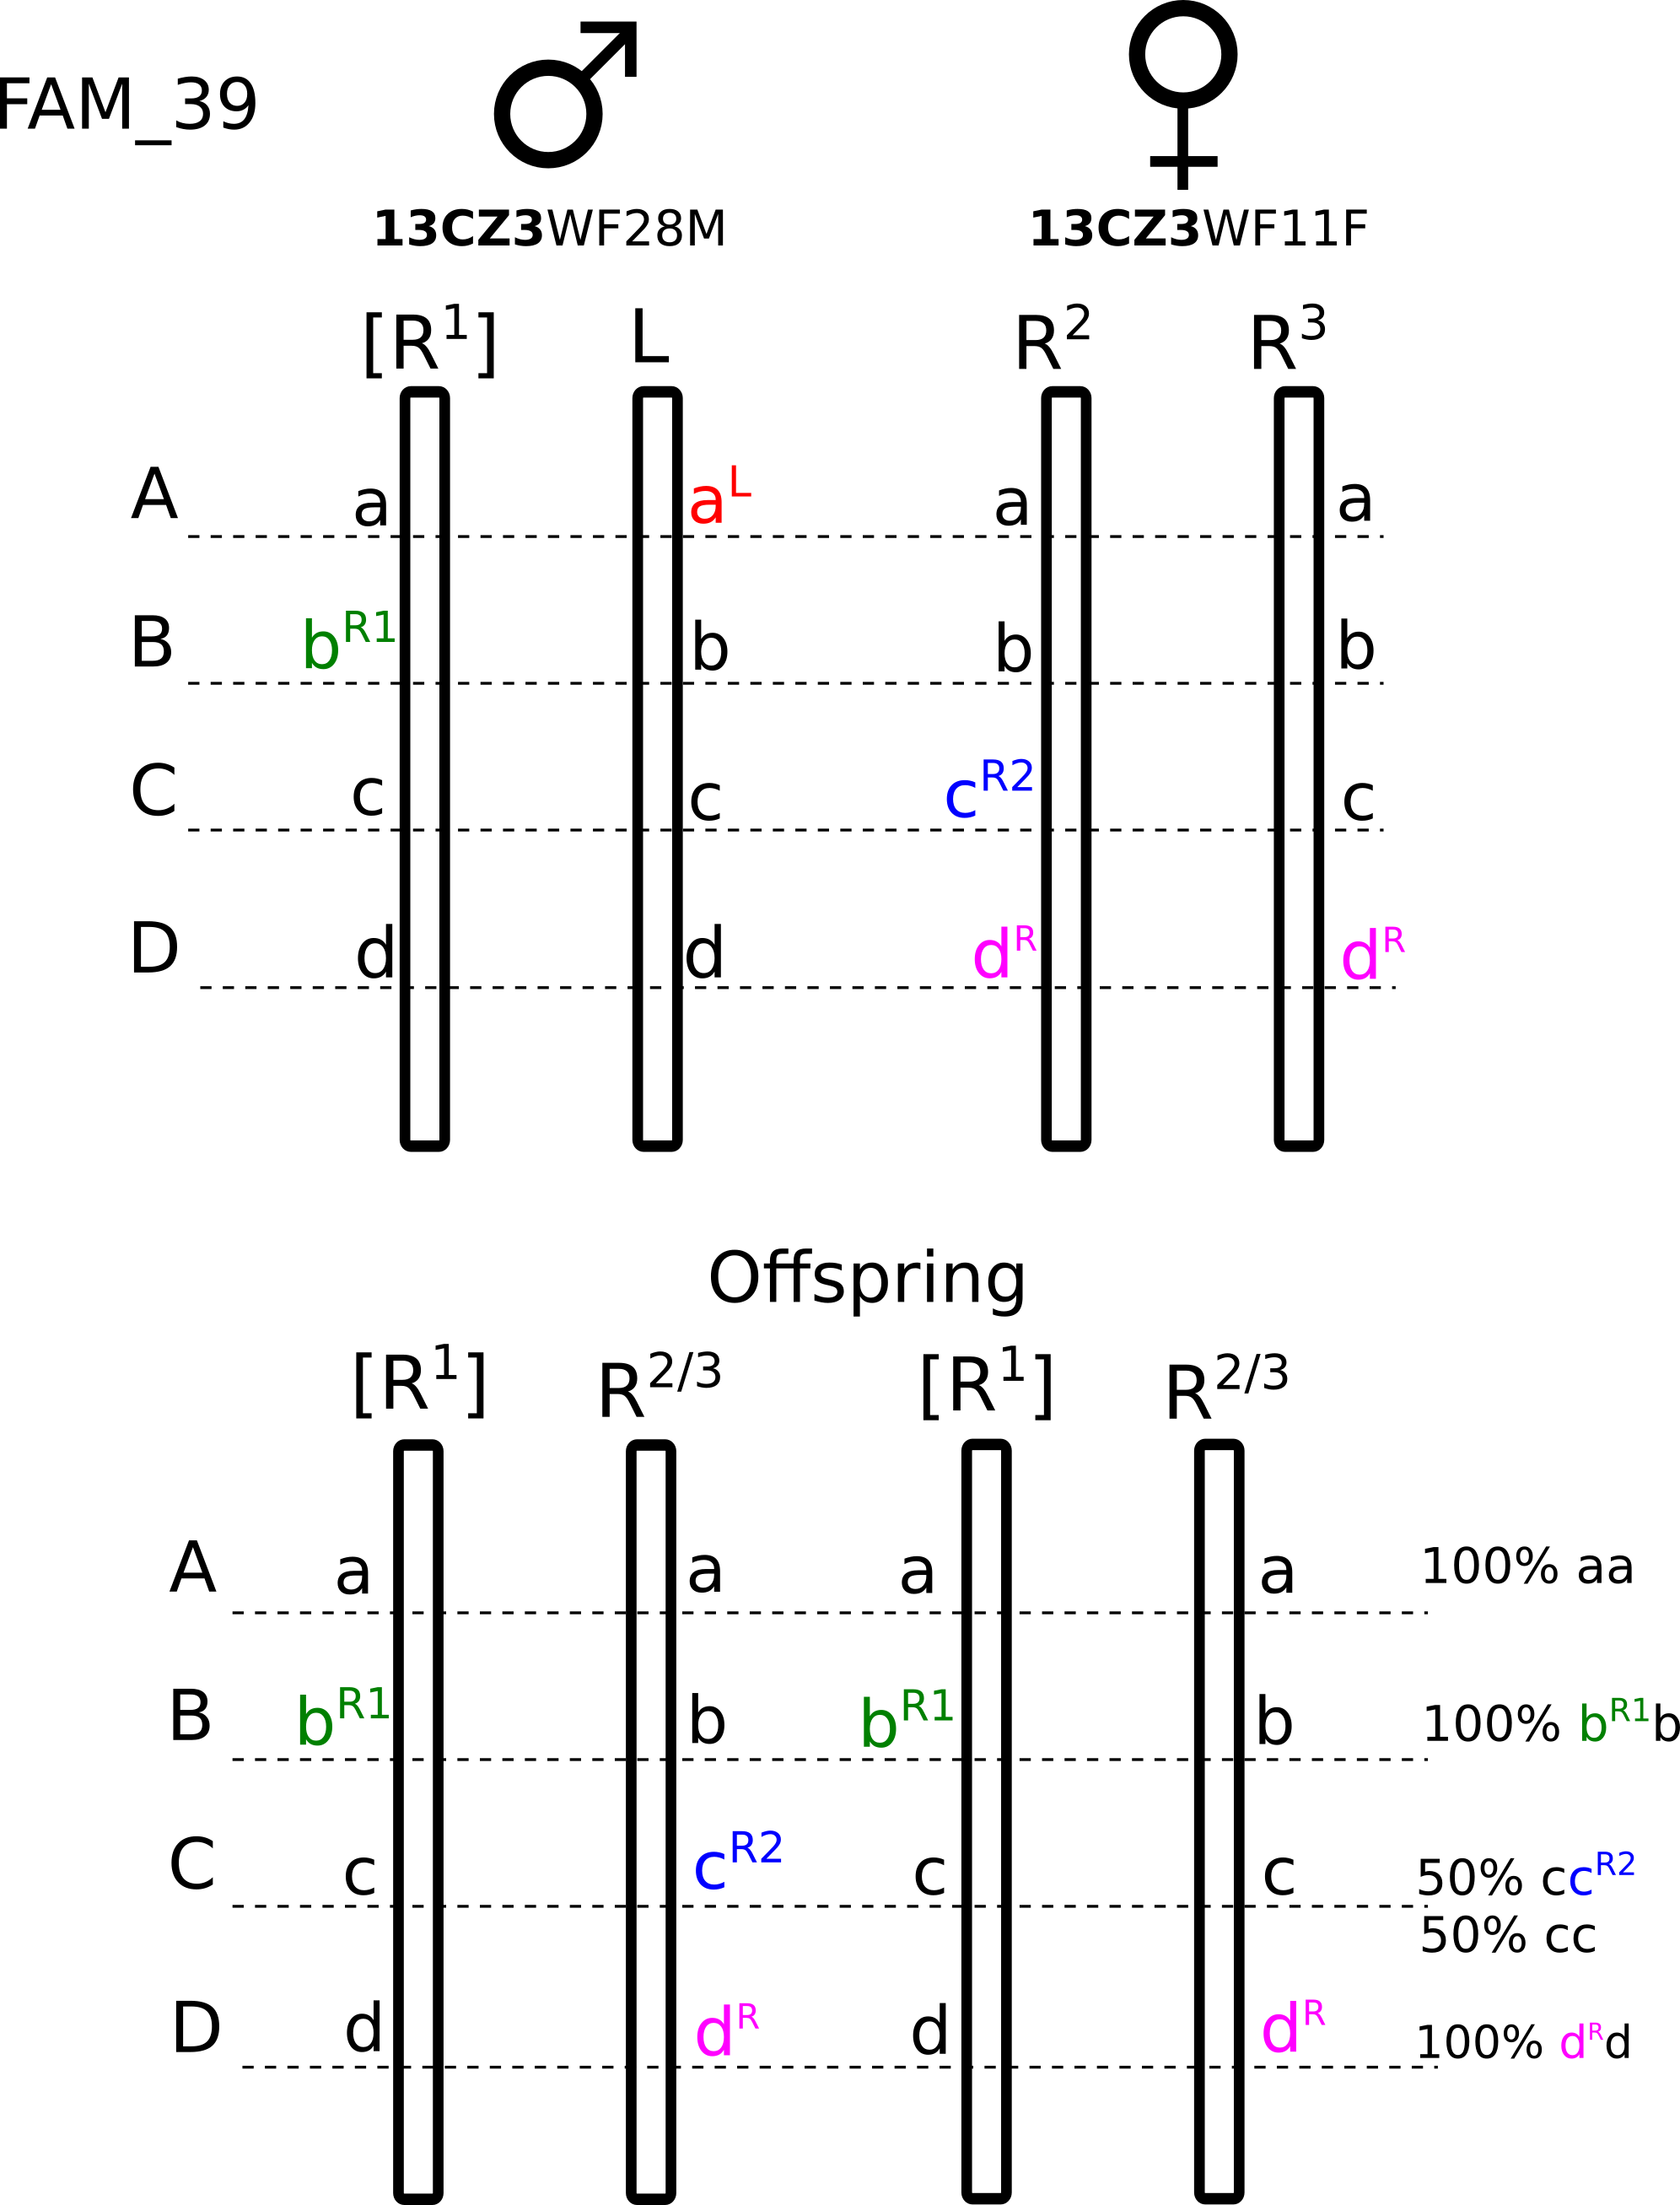

In [18]:
Image("%s/Schematics/FAM_39_schematic.png" % working_dir, width=900)

Based on the family schematic above, the following expectations will be tested in the following code blocks, to identify loci which fit each category (A, B, C or D).

<b>Test to find the $a^L$ alleles:</b>

- loci are heterozygous in the father (R[L])
- loci are homozygous in the mother (RR).
- loci are homozygous in all [R]R offspring.

<b>$a^L$ allele is then the allele which is specific to the father. </b>

NOTE: this method might be sensitive to null alleles in the mother. 

<b>Test to find the $b^{R1}$ alleles:</b>

- loci are heterozygous in the father (R[L])
- loci are homozygous in the mother (RR).
- loci are heterozygous in all [R]R offspring.

<b>$b^{R1}$ allele is then the allele which is specific to the father. </b>

NOTE: this method might be sensitive to null alleles in the father. 

<b>Test to find the $c^{R2}$ alleles (C in figure above):</b>

- loci are homozygous in the father (RL).
- loci are heterozygous in the mother (R[L])
- loci are heterozygous in 50% of all [R]R offspring

<b>$c^{R2}$ allele is then the allele which is specific to the mother. </b>

<b>Test to find the $d^R$ alleles:</b>
    
- loci are fixed for alternate genotypes in the mother and father
- loci are heterozygous in all offspring

<b>$d^R$ allele is then the allele which is specific to the mother. </b>

NOTE: this method might be sensitive to null alleles in the father. 


In [33]:
Mother = "13CZ3WF11F"
Father = "13CZ3WF31M"

offspring_identifier = "39_"
offspring_het_threshold = 0.8  

cov_threshold = 10

myvcf = vcf.Reader(open(vcf_path, 'r'))

#record = myvcf.next()

phased_loci_fam_39 = {}
phased_loci_fam_39["A_loci"] = {}
phased_loci_fam_39["B_loci"] = {}
phased_loci_fam_39["C_loci"] = {}
phased_loci_fam_39["D_loci"] = {}

A_phasable = 0
B_phasable = 0
C_phasable = 0
D_phasable = 0
homomorphic_loci = 0
heterozygous_loci = 0
phasable_for_RR = 0
not_enough_data = 0

## Use the offspring genotypes here, as I want to look at the R[R] and R[L] offspring separately here

sample_GTs

RR_offspring = []

## same process as before for getting genotype info for parents and offspring. 

for record in myvcf:
    
    N_RR_offspring_called = 0
    het_RR_offspring = 0
    RR_offspring_gts = []

    for sample in record.samples:
        
        ## count offspring in family
        
        if offspring_identifier in sample.sample:
            if GT_dict[sample.sample] == "RR":
                if sample.sample not in RR_offspring:
                    RR_offspring.append(sample.sample)
        
        ## if coverage is high enough, record info of locus
        
        if sample.called and sample["DP"] >= cov_threshold:
        
        
            if sample.sample == Mother:
                mother_found = True
                Mother_called = sample.called
                Mother_het = sample.is_het
                Mothers_GT = sample["GT"]
                Mothers_GT_bases = sample.gt_bases

            elif sample.sample == Father:
                father_found = True
                Father_called = sample.called
                Father_het = sample.is_het
                Fathers_GT = sample["GT"]
                Fathers_GT_bases = sample.gt_bases

            elif offspring_identifier in sample.sample:

                if GT_dict[sample.sample] == "RR":
                    RR_offspring_gts.append(sample["GT"])

                    if sample.sample not in RR_offspring:
                        RR_offspring.append(sample.sample)

                    if sample.called:
                        N_RR_offspring_called += 1

                    if sample.is_het:
                        het_RR_offspring += 1
    
    ## Test if enough data is left (includes coverage filter)
       
    if all([Mother_called == True, Father_called == True, N_RR_offspring_called > (len(RR_offspring)*0.8)]): ## if parents called and enough offspring called
        
        ## Now testing for L phasable loci (A loci)            
                    
        if all([Mother_het == False, Father_het == True, (het_RR_offspring / N_RR_offspring_called) <= 1-offspring_het_threshold]): ## If mother hom, father het and no (or almost no) offspring heterozygous
            
            A_phasable += 1  ## count as phasable. 
                
            ## Now get the clonal R allele. 
            
            for allele in Fathers_GT_bases.split("/"):
                
                if allele not in Mothers_GT_bases.split("/"): ## if the allele is not in the mother

                    phased_loci_fam_39["A_loci"][record.ID] = {}
                    phased_loci_fam_39["A_loci"][record.ID]["aL"] = allele
                    phased_loci_fam_39["A_loci"][record.ID]["a"] = Mothers_GT_bases.split("/")[0]
        
        
        ## Now testing for R clone phasable loci (B loci)
        
        elif all([Mother_het == False, Father_het == True, (het_RR_offspring / N_RR_offspring_called) >= offspring_het_threshold]): ## If mother hom, father het and enough offspring are het
            
            B_phasable += 1  ## count as phasable. 
                
            ## Now get the clonal R allele. 
            
            for allele in Fathers_GT_bases.split("/"):
                
                if allele not in Mothers_GT_bases.split("/"): ## if the allele is not in the mother

                    phased_loci_fam_39["B_loci"][record.ID] = {}
                    phased_loci_fam_39["B_loci"][record.ID]["b_R1"] = allele
                    phased_loci_fam_39["B_loci"][record.ID]["b"] = Mothers_GT_bases.split("/")[0]
                    
        
        ## C loci
        
        elif all([Mother_het == True, Father_het == False, 0.4 <= (het_RR_offspring / N_RR_offspring_called) <= 0.6]): ## If mother hom, father het and about half of offspring are het
            
            C_phasable += 1  ## count as phasable. 
                
            ## Now get the clonal R allele. 
            
            for allele in Mothers_GT_bases.split("/"):
                
                if allele not in Fathers_GT_bases.split("/"): ## if the allele is not in the mother

                    phased_loci_fam_39["C_loci"][record.ID] = {}
                    phased_loci_fam_39["C_loci"][record.ID]["c_R2"] = allele
                    phased_loci_fam_39["C_loci"][record.ID]["c"] = Fathers_GT_bases.split("/")[0]
                    
        ## Now testing for D loci
        
        elif all([Mother_het == False, Father_het == False, Mothers_GT_bases.split("/")[0] != Fathers_GT_bases.split("/")[0], (het_RR_offspring / N_RR_offspring_called) >= offspring_het_threshold]): 
            
            D_phasable += 1  ## count as phasable. 
                
            ## Now get the clonal R allele. 
            
            for allele in Mothers_GT_bases.split("/"):
                
                if allele not in Fathers_GT_bases.split("/"): ## if the allele is not in the mother

                    phased_loci_fam_39["D_loci"][record.ID] = {}
                    phased_loci_fam_39["D_loci"][record.ID]["d_R"] = allele
                    phased_loci_fam_39["D_loci"][record.ID]["d"] = Fathers_GT_bases.split("/")[0]
                    
        
        elif all([Mother_het == False, Father_het == False, (het_RR_offspring / N_RR_offspring_called) == 0]):
            
            homomorphic_loci += 1
            
        elif all([Mother_het == True, Father_het == True]):
            
            heterozygous_loci += 1
        
        else:
            not_phasable += 1
            
    else:
        not_enough_data += 1 
            

print "%s phasable loci for L (A loci)" % A_phasable
print "%s phasable loci for clonal R (B loci)" % B_phasable
print "%s loci variable in female (C loci)" % C_phasable
print "%s D loci" % D_phasable
print "%s loci homomorphic in this family" % homomorphic_loci
print "%s loci heterozygous in both parents" % heterozygous_loci
print "%s loci had enough data but unphasable" % not_phasable
print "%s loci with not enough data" % not_enough_data


3222 phasable loci for L (A loci)
147 phasable loci for clonal R (B loci)
180 loci variable in female (C loci)
157 D loci
867 loci homomorphic in this family
349 loci heterozygous in both parents
1015 loci had enough data but unphasable
4547 loci with not enough data


## Combining phased loci and outputting VCF

So we have now have phased loci for R vs L (A loci) and [R] vs R (B loci) from several families. The next step is to combine them into a single VCF, with each individual sample split into its constituent sub-genomes, with the correct allele placed on each one. 

The challenge is how to deal with loci which are phased in one family but not in another. There is a schematic below for reference when considering this problem.

The easiest thing to do would be to output only loci phased in all families. For example, on the schematic below, R vs L phased loci phased in all families would be $A^1$ loci, which must have arisen in the branches leading to the L or R lineages. However these would not give us any information on variation within these lineages. Thus I need to include loci which have been phased for R vs L (and R vs [R]) within each family, in order to be able to characterise variation within R and L lineages. This raises some theoretical challenges however - for example, how do I deal with a locus which is phased for R vs L in Family 1, which was not phased in Family 2? These would be $A^2$ loci, or $C/D$ loci. Equally, how do I deal with loci phased for R vs [R] in only one family and not another (i.e. $C/D$ or $B$ loci).

I will deal with these cases one by one when creating the VCF.

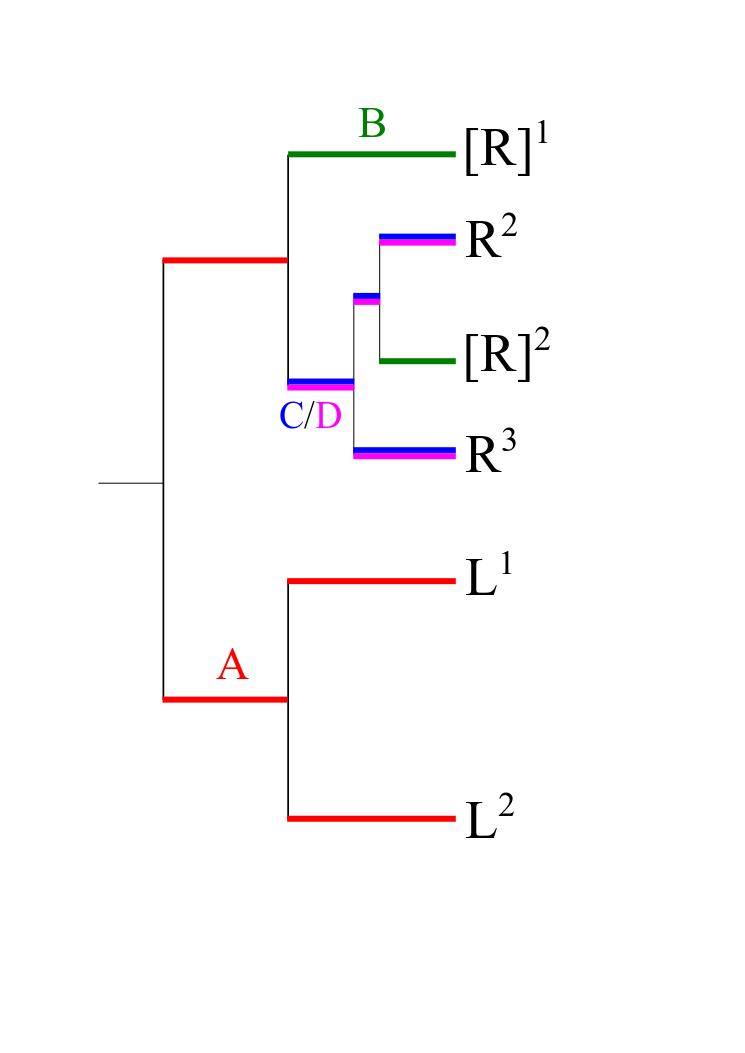

In [591]:
Image("%s/Schematics/Phasing_schematic_color_coordinated.png" % working_dir, width=900)

## Strategy:

I will first curate the sets of loci (A, B, C and D) separately before including them one by one in the final dataset. This way I can check the structure that each locus category brings out and troubleshoot along the way. Note that I will not use family 39 for this, as those loci were inferred only from the father's heterozygous call in that family, which will be unreliable. 

### For A-loci

For each locus that has been phased for R vs L in each RL family, do two checks:

1) is it phased in another family, and if so do the phasings agree

2) is it is phased in only one family. 

If a locus passes both of these tests it makes it into the final dataset. I then output a new phased VCF for these loci, where each sample is represented twice - once for each constituent sub-genome (in doubled-haploid form). The structure among the phased subgenomes is then visualised using a simple PCA.

Below is a quick venn diagram to get a handle on how much sharing of phased A-loci there is between RL families. 


/home/djeffrie/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


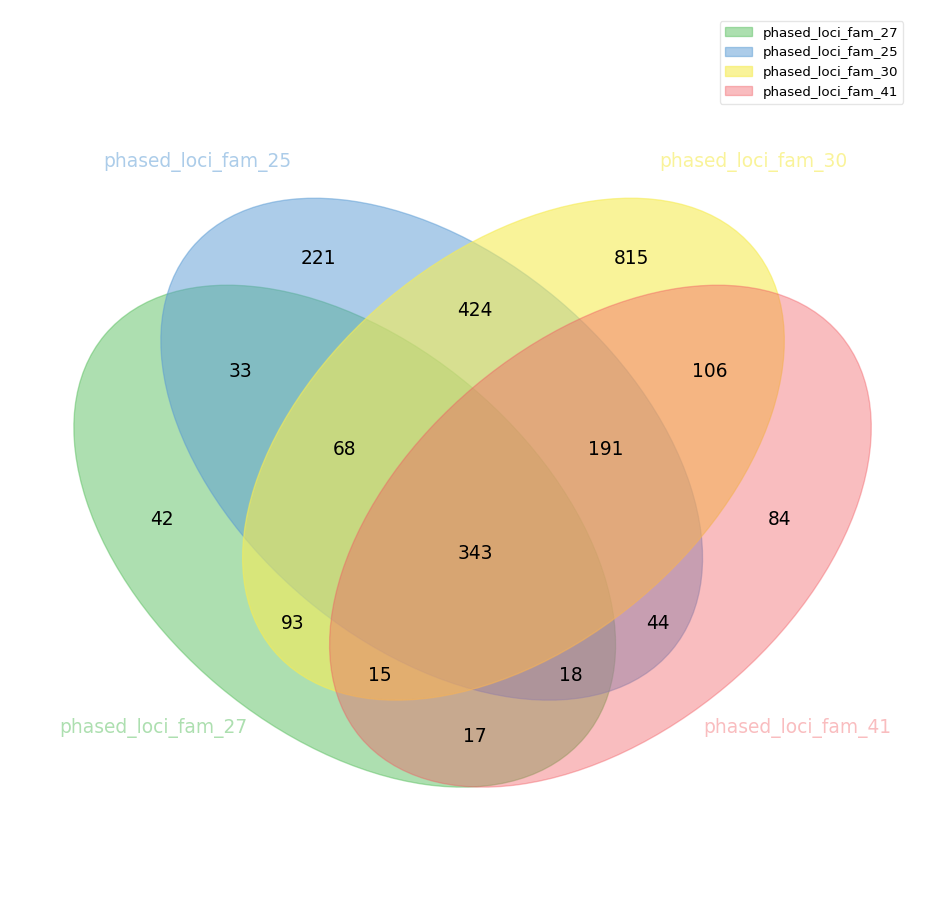

In [14]:
import venn
labels = venn.get_labels([phased_loci_fam_27["A_loci"], phased_loci_fam_25["A_loci"], phased_loci_fam_30["A_loci"], phased_loci_fam_41["A_loci"]], fill=['number'])
fig, ax = venn.venn4(labels, names=["phased_loci_fam_27", "phased_loci_fam_25", "phased_loci_fam_30", "phased_loci_fam_41"])
fig.show()

So the loci right in the centre must be true A1 loci. Those private to each family are probably the A2 loci. Those phased in two or three may be A2 loci, or may be A1 loci which just drop out in one or two families because of missing data for example. 

In preliminary rounds of the A-loci curation, a curious pattern was emerging. The phased R genomes from RL samples for family 27 were falling apart from the phased R genomes of their RR siblings. Furthermore these "divergent" R's from the RLs of family 27 were clustering with the R's from family 25's RL offspring. 

It was suspected that this was due to some artifact of the data/analyses. So below I go through the steps I used to get to the bottom of this problem.

In the scripting cell below, I first isolate the A1 loci, on adding these to the dataset, as expected (and not shown below) the only resulting structure between subgenomes was between the R's and L's. With variation within these groups being minimal and due to noise in data presence/absence. 

I then add A2 loci, that is, loci which have been phased in one family only. This is where problems occur. 

Below I add these loci, with no extra sanity checks . . . 



In [54]:
### A-loci curation


myvcf = vcf.Reader(open(vcf_path, 'r'))


RL_fams = [ phased_loci_fam_27, phased_loci_fam_25, phased_loci_fam_30, phased_loci_fam_41]

phased_count = 0
multiphased_ok_count = 0
multiphased = 0
aL_alleles_in_RRs = 0
aL_alleles_homozygous = 0
single_phased_ok_count = 0
KEPT = 0

Kept_A_loci = {}
A1_loci = 0
A2_loci = 0

for record in myvcf:
    
    ## CHECK for A1 loci - if phased in more than one family, are the phasings for this locus consistent?
    ## loop over each family phasing dictionary, get the a and aL alleles and check that they are consistent.
    
    record_phased = False
    a = None
    aL = None
    multiphased_ok = False 
    families_phased = 0
    aL_behaviour_OK = False
    
    for family in RL_fams:
        
        if record.ID in family["A_loci"]:
            families_phased += 1
            record_phased = True
            multiphased_ok = True  ## if incosnsitencies arise, this will change to false and the locus will not be used. 
            
            if a == aL == None:
                a = family["A_loci"][record.ID]["a"]
                aL = family["A_loci"][record.ID]["aL"]
            
            elif not all([family["A_loci"][record.ID]["a"] == a, family["A_loci"][record.ID]["aL"] == aL]):
                
                multiphased_ok = False
                
       
    ## Check 2) - if phased in only one family, check that the aL allele is not homozygous in too many offspring, and not present in too many RR samples.             
                
    if record_phased:
        phased_count += 1
        
        samples_called = 0
        aL_in_RRs = 0
        aL_homozygous = 0
       
        
        for sample in record.samples:

            if sample.called:
                samples_called += 1
                
                if GT_dict[sample.sample] == "RR":
                    if aL in sample.gt_bases.split("/"):
                        aL_in_RRs += 1

                if sample.gt_bases == "%s/%s" % (aL, aL):
                    aL_homozygous += 1

    ## Now use the results of these two checks to decide whether to keep the locus or not. 
    
    if families_phased > 1:
        multiphased += 1
        
        if multiphased_ok: ## if the locus is phased in more than one family and the phasings agree.
            multiphased_ok_count += 1
            
            if all([ aL_in_RRs == 0, aL_homozygous == 0]): ## If the L allele is never in RR samples and never homozygous. 
            
                A1_loci += 1 

                KEPT += 1
                Kept_A_loci[record.ID] = {}
                Kept_A_loci[record.ID]["aL"] = aL
                Kept_A_loci[record.ID]["a"] = a
    
    ## If the locus is only phased in one family 
    
    elif families_phased == 1:
        A2_loci += 1

        KEPT += 1     
        Kept_A_loci[record.ID] = {}
        Kept_A_loci[record.ID]["aL"] = aL
        Kept_A_loci[record.ID]["a"] = a
            


print "%s records phased" % phased_count
print "Of which %s are phased in more than one RL family" % multiphased
print "Of which %s have matching phasings across families" % multiphased_ok
print "Of which %s have L alleles which are never homozygous in RR samples (A1 loci )" % A1_loci
print "%s A2 loci found" % A2_loci

print "%s A loci kept" % KEPT

4006 records phased
Of which 2085 are phased in more than one RL family
Of which True have matching phasings across families
Of which 1228 have L alleles which are never homozygous in RR samples (A1 loci )
1921 A2 loci found
3149 A loci kept


### Making the VCF

In [69]:
## getting rid of some samples that have a lot of missing data, and obscure the signal in the PCA

discards = ["25_2013_JUV17",
            "27_2013_JUV13",
            "27_2013_JUV14",
            "41_2013_JUV12",
            "41_2013_JUV16",
            "41_2013_JUV17",
            "27_2013_JUV02",
            "27_2013_JUV021",
            "27_2013_JUV022",
            "L_clone_GMP_01_05_C17A",
            "L_clone_GMP_01_05_C30B",
            "L_clone_GMP_01_05_C30C",
            "Ly_clone_16cz4wf14m_C45A",
            "Ly_clone_16cz4wf15m_C46B",
            "L_clone_GMP_01_05_C17C", #
            "L_clone_GMU_03_02B_C31B2", #
            "R_clonal_GMP_05_01_C25A", #
            "R_clonal_GMP_05_01_C25B"] #

In [732]:
import numpy as np

outvcf = open("%s/Data_files/batch_1_PHASED_A_haps.vcf" %s working_dir, 'w')

cov_threshold = 10

## write headers

for line in open(hap_vcf_path, 'r').readlines():
    if all([line.startswith("#"), not line.startswith("#CHROM"), not line.startswith("##FORMAT=<ID=GL")]):
        outvcf.write(line)

sample_line_done = False

myvcf = vcf.Reader(open(vcf_path, 'r')) 

discordant_A_samples = {}
discordant_A_loci = {}

loci_dropped = 0


for record in myvcf:  ## for each locus

    ## Set REF and ALT alleles for the record (sexual R always REF)
    
    record_phased = False
    
    sample_names = []
    sample_fields = []
    
    N_dropped = 0
    
    
    ########################################################################################################################################
    ########################################################################################################################################
    ###############################################    FOR A-LOCI    #######################################################################
    ########################################################################################################################################
    ########################################################################################################################################
    
    
    if record.ID in Kept_A_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        R_allele = Kept_A_loci[record.ID]["a"]
        L_allele = Kept_A_loci[record.ID]["aL"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  ######################
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
             
            
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_Lclon SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        

            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < record.num_called*0.25: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, REF, ALT, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    else:
        pass 

outvcf.close()
print "%s loci dropped due to missing data" % loci_dropped

307 loci dropped due to missing data


### Now making the PCA

In [ ]:
%%bash

wd=/home/djeffrie/Data/RADseq/Hybridogens/  ## just change this line with your own working dir

## All data 
sed 's/_/-/g' $wd/Data_files/batch_1_PHASED_A_haps.vcf > $wd/batch_1_PHASED_A_haps_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_PHASED_A_haps_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_PHASED_A_haps_altered_adegenet_plink


In [ ]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R") ## just change this path to wherever you put the R script

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Hybridogens_paper/") 

## All SNPs 
alldata <- read.PLINK('./Data_files/batch_1_PHASED_A_haps_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 


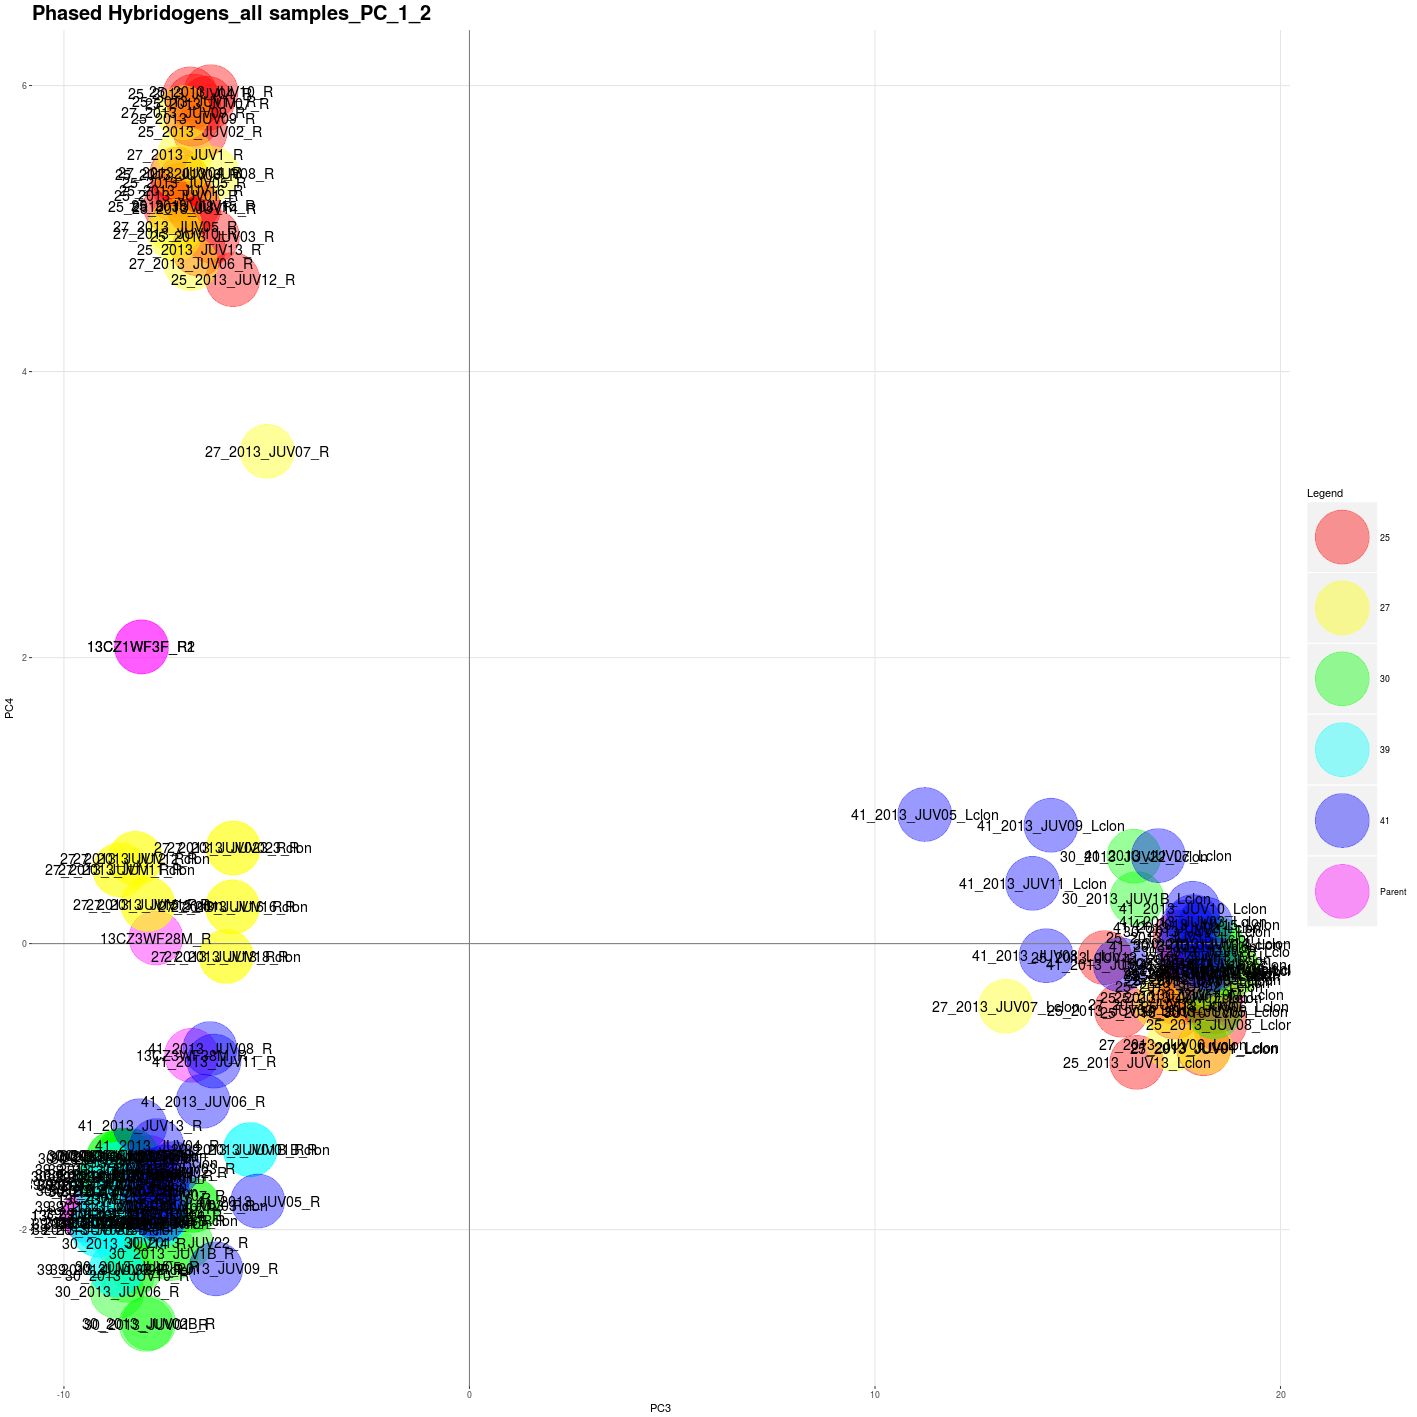

In [739]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

## Sex information - just a two column text file with the sample name in the first column and the sex (M or F) in the second column. Its for labelling the PCA
sexes <- read.delim("./Data_files/popmap_pops_only_KEPT.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plotb
           Title = "Phased Hybridogens_all samples_PC_1_2", ## plot title
           xtitle = "PC3", ## X axis title
           ytitle = "PC4", ## Y axis title 
           Palette = rainbow(6), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

So you see this pattern with the R genomes from family 25 falling a long way out from the other Rs in the top left here. And the weird thing is that the Rs from RL samples in family 27 cluster with them, while the R's from RR samples in family 27 cluster closer to the other Rs. This is clearly wrong, as the R's from the RL and RR offspring of family 27 both come from the same mother. Thus they should be pretty much identical, give or take a bit of recombination in the mother (regardless, they should form one continuous cluster here). 

So, after much trial and error exploring these A2 loci I discovered that the loci driving this signal in the PCA are loci which are all homozygous for the L allele in these family 27 RL offpsring (in the original VCF). Now, by definitition, these loci could not be phased in family 27, they were in fact phased in other RL families (see Venn diagram below - problem loci labelled as "weird loci"). 

The only explanation that I can think of is that these loci contain null alleles in the female of family 27 (note that it is the same female as used in the family 25 cross). So say a locus was phased only in family 30 for RL. If that locus was an A2 locus, the L allele should never be found in homozygous state in any family here. Now consider that the female in family 27 (and 25) comes from a different population. There will undoubtably be variation in the RADseq data between these population, and one common form of RADseq variation is null alleles (i.e. an allele drops out in one population but not another). So, if at the locus which was phased in family 30, there was a null allele in the R genome of family 27, but the L allele was intact, RL samples in family 27 would be hemizygous for the L allele and so be assigned a genotype of LL in RADseq SNP calling. RR samples from family 27 would be hemizygous for the from the father, which presumably doesn't have the null allele as it is from an entirely separate population.


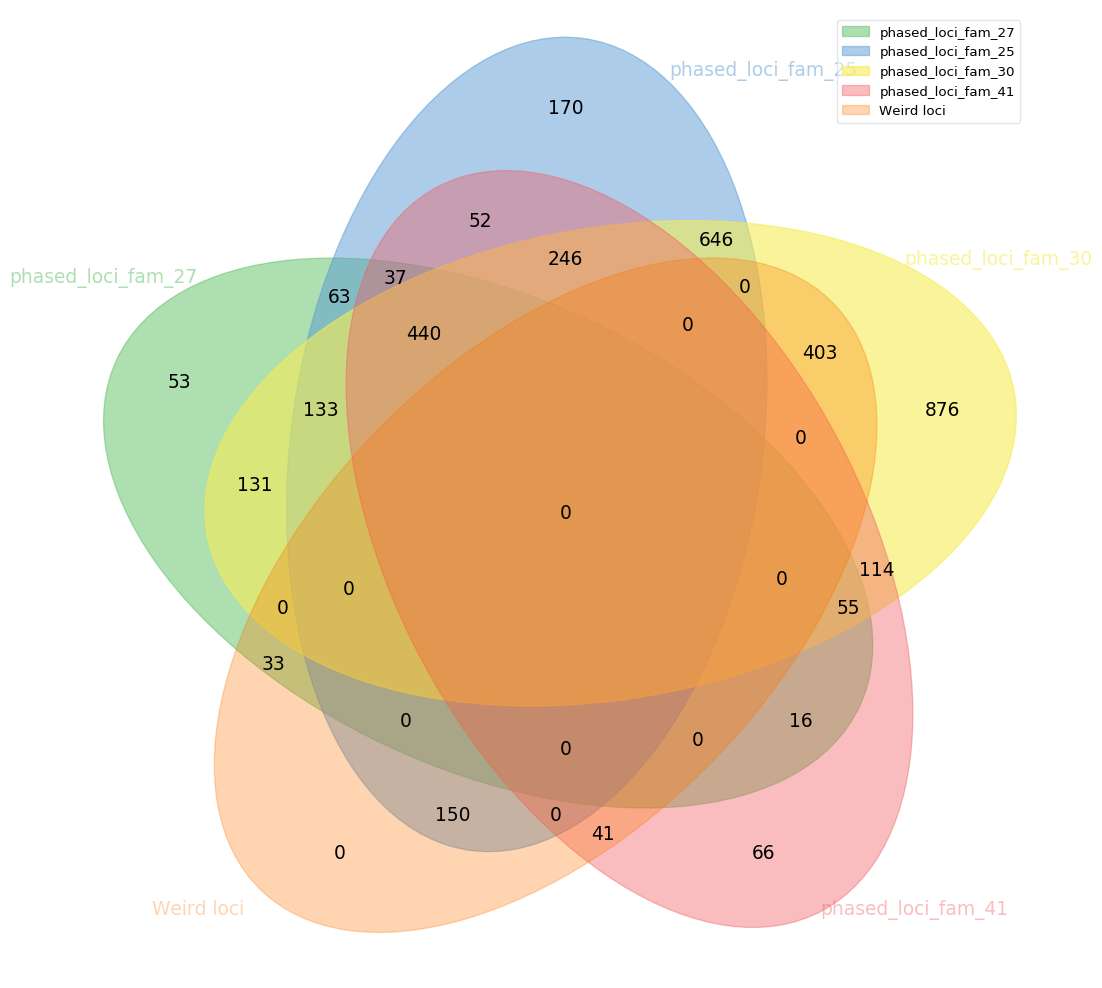

In [519]:
import venn
labels = venn.get_labels([phased_loci_fam_27["A_loci"], phased_loci_fam_25["A_loci"], phased_loci_fam_30["A_loci"], phased_loci_fam_41["A_loci"], weird_loci_list], fill=['number'])
fig, ax = venn.venn5(labels, names=["phased_loci_fam_27", "phased_loci_fam_25", "phased_loci_fam_30", "phased_loci_fam_41", "Weird loci"])
fig.show()

So the way of controlling for these loci is simply to add further checks to the curation of the A-loci. Specifically I will now impose the filter that loci which are phased for RL in one or more families, can never be homozygous for the L allele in any family (give or take for some missed heterozygous calls)

In [35]:
### A-loci curation

myvcf = vcf.Reader(open(vcf_path, 'r'))


RL_fams = [ phased_loci_fam_27, phased_loci_fam_25, phased_loci_fam_30, phased_loci_fam_41]

phased_count = 0
multiphased_ok_count = 0
multiphased = 0
aL_alleles_in_RRs = 0
aL_alleles_homozygous = 0
single_phased_ok_count = 0
KEPT = 0

Kept_A_loci = {}
A1_loci = 0
A2_loci = 0
weird_loci = 0
weird_loci_list = []
CD_loci = 0

for record in myvcf:
    
    ## CHECK for A1 loci - if phased in more than one family, are the phasings for this locus consistent?
    ## loop over each family phasing dictionary, get the a and aL alleles and check that they are consistent.
    
    record_phased = False
    a = None
    aL = None
    multiphased_ok = False 
    families_phased = 0
    aL_behaviour_OK = False
    
    for family in RL_fams:
        
        if record.ID in family["A_loci"]:
            families_phased += 1
            record_phased = True
            multiphased_ok = True  ## if incosnsitencies arise, this will change to false and the locus will not be used. 
            
            if a == aL == None:
                a = family["A_loci"][record.ID]["a"]
                aL = family["A_loci"][record.ID]["aL"]
            
            elif not all([family["A_loci"][record.ID]["a"] == a, family["A_loci"][record.ID]["aL"] == aL]):
                
                multiphased_ok = False
                
       
    ## Check 2) - if phased in only one family, check that the aL allele is not homozygous in too many offspring, and not present in too many RR samples.             
                
    if record_phased:
        phased_count += 1
        
        samples_called = 0
        aL_in_RRs = 0
        aL_homozygous = 0
       
        
        for sample in record.samples:

            if sample.called:
                samples_called += 1
                
                if GT_dict[sample.sample] == "RR":
                    if aL in sample.gt_bases.split("/"):
                        aL_in_RRs += 1

                if sample.gt_bases == "%s/%s" % (aL, aL):
                    aL_homozygous += 1

    ## Now use the results of these two checks to decide whether to keep the locus or not. 
    
    if families_phased > 1:
        multiphased += 1
        
        if multiphased_ok: ## if the locus is phased in more than one family and the phasings agree.
            multiphased_ok_count += 1
            
            if all([ aL_in_RRs == 0, aL_homozygous == 0]): ## If the L allele is never in RR samples and never homozygous. 
            
                A1_loci += 1 

                KEPT += 1
                Kept_A_loci[record.ID] = {}
                Kept_A_loci[record.ID]["aL"] = aL
                Kept_A_loci[record.ID]["a"] = a
    
    ## If the locus is only phased in one family 
    
    elif families_phased == 1:
        if all([ aL_in_RRs == 0, aL_homozygous < 5]): ## if the L locus is never in RR samples and it is (almost) never homozygous, must be an A2 locus
            A2_loci += 1

            KEPT += 1     
            Kept_A_loci[record.ID] = {}
            Kept_A_loci[record.ID]["aL"] = aL
            Kept_A_loci[record.ID]["a"] = a
            

    
print "%s records phased" % phased_count
print "Of which %s are phased in more than one RL family" % multiphased
print "Of which %s have matching phasings across families" % multiphased_ok
print "Of which %s have L alleles which are never homozygous in RR samples (A1 loci )" % A1_loci
print "%s A2 loci found" % A2_loci
print "%s weird loci found" % weird_loci

print "%s A loci kept" % KEPT

2514 records phased
Of which 1352 are phased in more than one RL family
Of which True have matching phasings across families
Of which 79 have L alleles which are never homozygous in RR samples (A1 loci )
260 A2 loci found
0 weird loci found
339 A loci kept


So now I will remake the VCF and replot the PCA.

In [742]:
import numpy as np

outvcf = open("%s/Data_files/batch_1_PHASED_curated_A_haps.vcf" %s working_dir, 'w')

cov_threshold = 10

## write headers

for line in open(hap_vcf_path, 'r').readlines():
    if all([line.startswith("#"), not line.startswith("#CHROM"), not line.startswith("##FORMAT=<ID=GL")]):
        outvcf.write(line)

sample_line_done = False

myvcf = vcf.Reader(open(vcf_path, 'r')) 

discordant_A_samples = {}
discordant_A_loci = {}

loci_dropped = 0


for record in myvcf:  ## for each locus

    ## Set REF and ALT alleles for the record (sexual R always REF)
    
    record_phased = False
    
    sample_names = []
    sample_fields = []
    
    N_dropped = 0
    
    
    ########################################################################################################################################
    ########################################################################################################################################
    ###############################################    FOR A-LOCI    #######################################################################
    ########################################################################################################################################
    ########################################################################################################################################
    
    
    if record.ID in Kept_A_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        R_allele = Kept_A_loci[record.ID]["a"]
        L_allele = Kept_A_loci[record.ID]["aL"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  ######################
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
             
            
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_Lclon SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        

            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < record.num_called*0.25: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, REF, ALT, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    else:
        pass 

outvcf.close()
print "%s loci dropped due to missing data" % loci_dropped

92 loci dropped due to missing data


### PCA

In [ ]:
%%bash

wd=/home/djeffrie/Data/RADseq/Hybridogens/  ## just change this line with your own working dir

## All data 
sed 's/_/-/g' $wd/Data_files/batch_1_PHASED_curated_A_haps.vcf > $wd/batch_1_PHASED_curated_A_haps_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_PHASED_curated_A_haps_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_PHASED_curated_A_haps_altered_adegenet_plink


In [ ]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R") ## just change this path to wherever you put the R script

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Hybridogens_paper/") 

## All SNPs 
alldata <- read.PLINK('./Data_files/batch_1_PHASED_curated_A_haps_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 


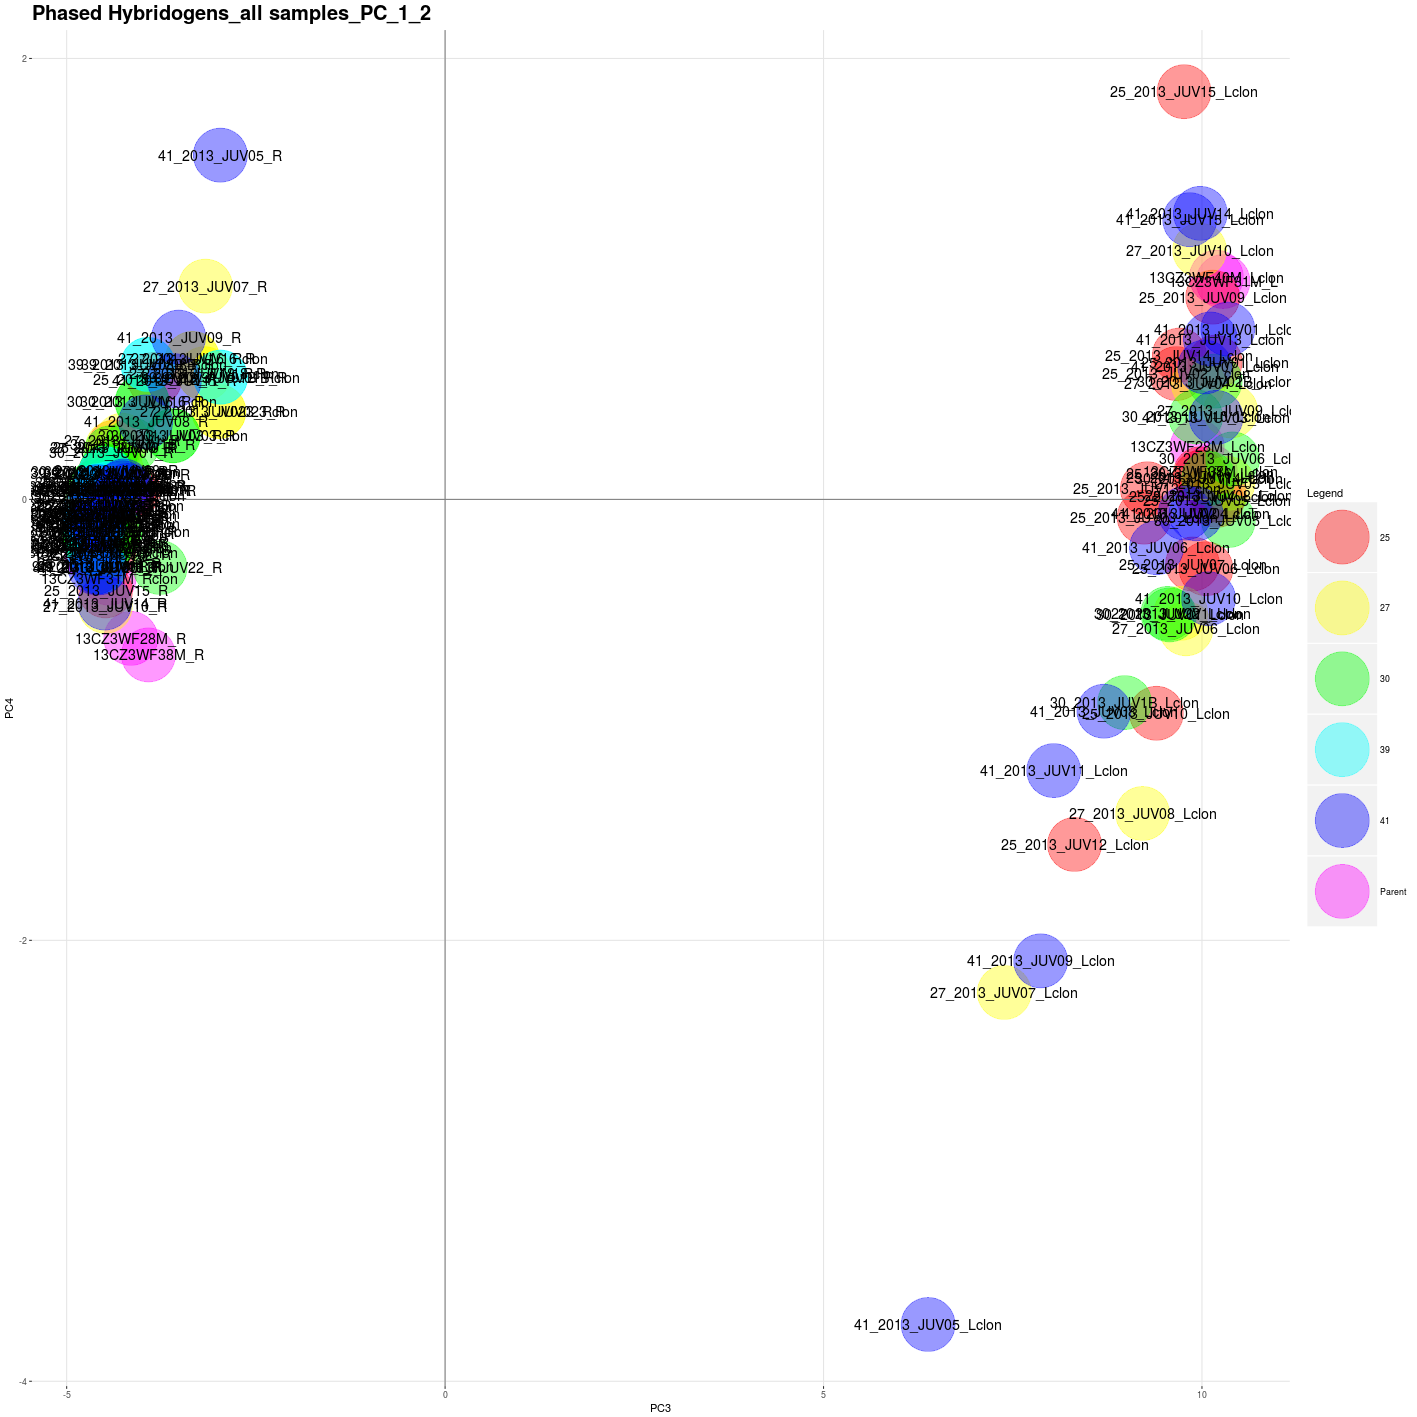

In [745]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

## Sex information - just a two column text file with the sample name in the first column and the sex (M or F) in the second column. Its for labelling the PCA
sexes <- read.delim("./Data_files/popmap_pops_only_KEPT.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plotb
           Title = "Phased Hybridogens_all samples_PC_1_2", ## plot title
           xtitle = "PC3", ## X axis title
           ytitle = "PC4", ## Y axis title 
           Palette = rainbow(6), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

So that gets rid of the signal pulling the 25 and 27 RL R's out of the pack. 

Now I want to add in real variation between the R's. That is, C and D locus categories. 

Same strategy as before, curate the locus set first, then add to the final dataset.

So what are our expectations for a C-locus. Refer again to the tree schematic. 

1) C loci should <b>never</b> be homozygous in an RL sample. 
2) C loci <b>could</b> be homozygous in an $[R]R$ sample, depending on which branch the C locus polymorphism originated and from which branch the $[R]$ genome came from. E.g. on the tree schematic, the $[R]^2$ genome branched off from the $R^2$ lineage, if a polymorphism arose on the branch leading to these two R lineages, an $[R]^1R^2$ sample could be homozygous for that locus. It would not be able to be phased in that family, but could potentially be phased in another. So I will allow C loci to be homozygous in [R]R or RR samples but not RL samples. However, I have to again be careful of the null alleles between the two populations here. 

So below I will perform two checks again:

1) Is the locus was phased in more than one family, and if so, if they are congruent?  
2) If phased in only one family, is the R allele never homozygous in RL samples.  
3) There is one more subtle issue, that is, a locus with a polymorphism in the mother, could be heterozygous in an $[R]R$ sample from another family where it was not phased but the c_R2 allele could be on the $[R]$ not the $R$. This is however, detectable, as if the c_R2 allele was on the $[R]$ subgenome, it would be in every $[R]$ offspring from that family. While, if it were on the $R$ subgenome, it would be passed only to half of the offspring. So this will be the third check

Lets take a look at how the phased C loci are shared among families


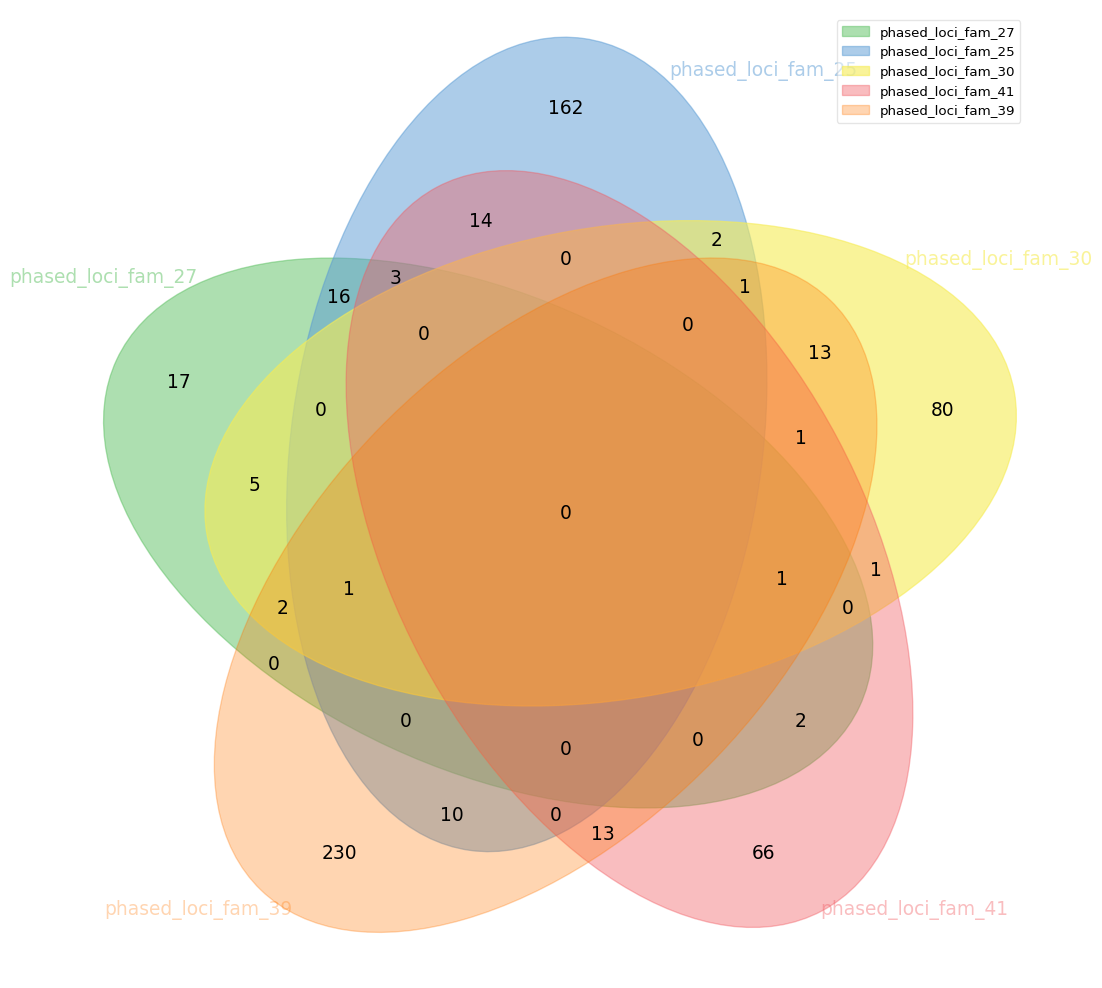

In [600]:
import venn
labels = venn.get_labels([phased_loci_fam_27["D_loci"], phased_loci_fam_25["D_loci"], phased_loci_fam_30["D_loci"], phased_loci_fam_41["D_loci"], phased_loci_fam_39["D_loci"]], fill=['number'])
fig, ax = venn.venn5(labels, names=["phased_loci_fam_27", "phased_loci_fam_25", "phased_loci_fam_30", "phased_loci_fam_41", "phased_loci_fam_39"])
fig.show()

So most of these loci are phased only in one family, which I suppose is to be expected. There is some overlap, normally between one or two families only.

In [36]:
### C-loci curation

myvcf = vcf.Reader(open(vcf_path, 'r'))


All_fams = [phased_loci_fam_27, phased_loci_fam_25, phased_loci_fam_30, phased_loci_fam_39, phased_loci_fam_41]

phased_count = 0
single_phased = 0
multiphased_ok_count = 0
multiphased = 0
c_R2_alleles_homozygous_in_RL = 0
single_phased_ok_count = 0
C_loci_multiphased_kept = 0
C_loci_single_kept = 0
multiphase_not_on_Rclon = 0
single_not_on_Rclon = 0

KEPT = 0

Kept_C_loci = {}

for record in myvcf:
    
    ## CHECK for C loci - if phased in more than one family, are the phasings for this locus consistent?
    ## loop over each family phasing dictionary, get the c and c_R2 alleles and check that they are consistent.
    
    record_phased = False
    c = None
    c_R2 = None
    multiphased_ok = False 
    families_phased = 0
    aL_behaviour_OK = False
    
    for family in All_fams:
        
        if record.ID in family["C_loci"]:
            families_phased += 1
            record_phased = True
            multiphased_ok = True  ## if incosnsitencies arise, this will change to false and the locus will not be used. 
            
            if c == c_R2 == None:
                c = family["C_loci"][record.ID]["c"]
                c_R2 = family["C_loci"][record.ID]["c_R2"]
            
            elif not all([family["C_loci"][record.ID]["c"] == c, family["C_loci"][record.ID]["c_R2"] == c_R2]):
                
                multiphased_ok = False
                
       
    ## Check 2) - if phased in only one family, check that the c_R2 allele is not homozygous in RL offspring (over the threshold. **Note that a couple of missed heterozygous calls can be due to low coverage, 
    ## and can be tolerated, but if many offspring don't are homozygous for the c_R2 allele, this is indicative of a null allele and the locus should not be used).             
                
    if record_phased:
        phased_count += 1
        
        RL_samples_called = 0
        c_R2_homozygous_RL = 0
       
        
        for sample in record.samples:

            if sample.called and GT_dict[sample.sample] == "RL":
                RL_samples_called += 1

                if sample.gt_bases == "%s/%s" % (c_R2, c_R2):
                    c_R2_homozygous_RL += 1

    
        ## Check 3) - for each family, is the c_R2 allele ever heterozygous in all R[R] offspring of the same family? If so it is likely on the [R] in that family (having been phased in a different family), and so can't be used. 
        
        R_Rclon_families = ["27", "30", "39"]
        
        R_Rclon_heterozygosities = {}
        

        for fam in R_Rclon_families:
            
            called_R_Rclon_samples = 0
            het_R_Rclon_samples = 0
            
            for sample in record.samples:
                
                if fam in sample.sample and sample.called:
                    
                    called_R_Rclon_samples += 1
                        
                    if sample.is_het and any([sample.gt_bases == "%s/%s" % (c, c_R2), sample.gt_bases == "%s/%s" % (c_R2, c)]):
                            
                        het_R_Rclon_samples += 1
            
            if called_R_Rclon_samples > 0:
                R_Rclon_heterozygosities[fam] = het_R_Rclon_samples / called_R_Rclon_samples
            
            else:
                R_Rclon_heterozygosities[fam] = 0
                
        #print record.ID, "25", R_Rclon_heterozygosities["25"], "27", R_Rclon_heterozygosities["27"], "30", R_Rclon_heterozygosities["30"],"39",  R_Rclon_heterozygosities["39"], "41", R_Rclon_heterozygosities["41"]
    
    
    ## Now use the results of these three checks to decide whether to keep the locus or not. 
    
    if families_phased > 1:
        multiphased += 1
        
        if multiphased_ok: ## if the locus is phased in more than one family and the phasings agree.
            multiphased_ok_count += 1
            
            
            ## If the locus is never heterozygous in more than 70% of [R]R samples (thus can't be on the [R])
            if R_Rclon_heterozygosities["27"] < 0.7 and R_Rclon_heterozygosities["30"] < 0.7 and R_Rclon_heterozygosities["39"] < 0.7:
                    
                multiphase_not_on_Rclon += 1
            
            if c_R2_homozygous_RL == 0: ## If the c_R2 allele is never in RL samples and never homozygous. 
            
                C_loci_multiphased_kept += 1 
                
            if all([R_Rclon_heterozygosities["27"] <= 0.7,
                    R_Rclon_heterozygosities["30"] <= 0.7,
                    R_Rclon_heterozygosities["39"] <= 0.7,
                    c_R2_homozygous_RL == 0]): ## If the c_R2 allele is never in RL samples and never homozygous. 
            
                    
                KEPT += 1
                Kept_C_loci[record.ID] = {}
                Kept_C_loci[record.ID]["c_R2"] = c_R2
                Kept_C_loci[record.ID]["c"] = c
                
                if c_R2_homozygous_RL == 0: ## If the c_R2 allele is never in RL samples and never homozygous. 
            
                    C_loci_multiphased_kept += 1 
    
    ## If the locus is only phased in one family 
    
    elif families_phased == 1:
        
        single_phased += 1
        
        if c_R2_homozygous_RL == 0: ## if the c_R2 locus is never in RL samples and it is (almost) never homozygous, must be an C locus
            
            C_loci_single_kept += 1
            
        ## If the locus is never heterozygous in more than 70% of [R]R samples (thus can't be on the [R])
        if R_Rclon_heterozygosities["27"] < 0.7 and R_Rclon_heterozygosities["30"] < 0.7 and R_Rclon_heterozygosities["39"] < 0.7:
                    
            single_not_on_Rclon += 1    
            
        if R_Rclon_heterozygosities["27"] < 0.7 and R_Rclon_heterozygosities["30"] < 0.7 and R_Rclon_heterozygosities["39"] < 0.7 and c_R2_homozygous_RL == 0:

            KEPT += 1     
            Kept_C_loci[record.ID] = {}
            Kept_C_loci[record.ID]["c_R2"] = c_R2
            Kept_C_loci[record.ID]["c"] = c
            

    
print "%s records phased" % phased_count
print "%s are phased in more than one family" % multiphased
print "Of which %s have matching phasings across families" % multiphased_ok_count
print "%s have c_R2 alleles which are never homozygous in RL samples" % C_loci_multiphased_kept
print "and %s have c_R2 alleles which are never heterozygous in all [R] samples in a family (i.e. not on the [R]) " % multiphase_not_on_Rclon
print "%s loci are phased in only one family" %  single_phased
print "Of which %s have c_R2 alleles which are never homozygous in RL samples" % C_loci_single_kept
print "and %s have c_R2 alleles which are never heterozygous in all [R] samples in a family (i.e. not on the [R]) " % single_not_on_Rclon

print "%s C loci kept (pass all checks)" % KEPT

387 records phased
44 are phased in more than one family
Of which 44 have matching phasings across families
70 have c_R2 alleles which are never homozygous in RL samples
and 35 have c_R2 alleles which are never heterozygous in all [R] samples in a family (i.e. not on the [R]) 
343 loci are phased in only one family
Of which 220 have c_R2 alleles which are never homozygous in RL samples
and 267 have c_R2 alleles which are never heterozygous in all [R] samples in a family (i.e. not on the [R]) 
192 C loci kept (pass all checks)


So not a bad number retained - if they are real and able to be kept they should add some signal to the PCA. The problem I have with these loci is that I don't know on which chromosome the SNP was in the mother. I think I will have to just randomise this (or at least alternate) when I assign the SNP to the subgenomes from the mothers. 

So below I will take the same script for making the VCF as above, but add a section for dealing with C loci to it. 

In [748]:
import numpy as np

outvcf = open("%s/Data_files/batch_1_PHASED_curated_A_C_haps.vcf" %s working_dir, 'w')

cov_threshold = 10

## write headers

for line in open(hap_vcf_path, 'r').readlines():
    if all([line.startswith("#"), not line.startswith("#CHROM"), not line.startswith("##FORMAT=<ID=GL")]):
        outvcf.write(line)

sample_line_done = False

myvcf = vcf.Reader(open(vcf_path, 'r')) 

discordant_A_samples = {}
discordant_A_loci = {}

discordant_B_samples = {}
discordant_B_loci = {}

discordant_C_samples = {}
discordant_C_loci = {}

discordant_D_samples = {}
discordant_D_loci = {}

loci_dropped = 0

maternal_het_c_R2_loci_counter = 1

for record in myvcf:  ## for each locus

    ## Set REF and ALT alleles for the record (sexual R always REF)
    
    record_phased = False
    
    sample_names = []
    sample_fields = []
    
    N_dropped = 0
    
    
    ########################################################################################################################################
    ########################################################################################################################################
    ###############################################    FOR A-LOCI    #######################################################################
    ########################################################################################################################################
    ########################################################################################################################################
    
    
    if record.ID in Kept_A_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        R_allele = Kept_A_loci[record.ID]["a"]
        L_allele = Kept_A_loci[record.ID]["aL"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  ######################
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
             
            
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_Lclon SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        

            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < record.num_called*0.25: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, REF, ALT, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    
    
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################
    #################################################################   C - loci   ##############################################################################################################
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################
    
    
    
    elif record.ID in Kept_C_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        c_allele = Kept_C_loci[record.ID]["c"]
        c_R2_allele = Kept_C_loci[record.ID]["c_R2"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  (mothers) ############
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" ## c allele always 0
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        ## It is not possible to phase these loci in the mothers, so I will alternate which subgenome gets the c_R2 allele.
                        
                        if maternal_het_c_R2_loci_counter == 1:
                            maternal_het_c_R2_loci_counter = 2
                        
                            sample_1_gt = "0/0" 
                            sample_2_gt = "1/1" 

                            DP = 20
                            AD1_1 = 20
                            AD1_2 = 0
                            AD2_1 = 0
                            AD2_2 = 20
                            NS += 2
                        
                        elif maternal_het_c_R2_loci_counter == 2:
                            maternal_het_c_R2_loci_counter = 1
                        
                            sample_1_gt = "1/1" 
                            sample_2_gt = "0/0" 

                            DP = 20
                            AD1_1 = 0
                            AD1_2 = 20
                            AD2_1 = 20
                            AD2_2 = 0
                            NS += 2
                    
                    elif sample.gt_bases == "%s/%s" % (c_R2_allele, c_R2_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        

                    ## Here if the sample is heterozygous
                    
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                        ## Note that in the curation I already made sure that the c_R2 alleles must be on the sexual R, not the [R]
                    
                    elif sample.gt_bases == "%s/%s" % (c_R2_allele, c_R2_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
             
            
                ###############################################################
                ###############################################################
                ################ FOR Rclon_Lclon SAMPLES (fathers) ############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        

            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < record.num_called*0.25: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, REF, ALT, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    

    
    
    else:
        pass 

outvcf.close()
print "%s loci dropped due to missing data" % loci_dropped

111 loci dropped due to missing data


So lets see what this does to the PCA

## PCA

In [ ]:
%%bash

wd=/home/djeffrie/Data/RADseq/Hybridogens/  ## just change this line with your own working dir

## All data 
sed 's/_/-/g' $wd/Data_files/batch_1_PHASED_curated_A_C_haps.vcf > $wd/batch_1_PHASED_curated_A_C_haps_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_PHASED_curated_A_C_haps_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_PHASED_curated_A_C_haps_altered_adegenet_plink



In [ ]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R") ## just change this path to wherever you put the R script

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Hybridogens_paper/") 

## All SNPs 
alldata <- read.PLINK('./Data_files/batch_1_PHASED_curated_A_C_haps_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 


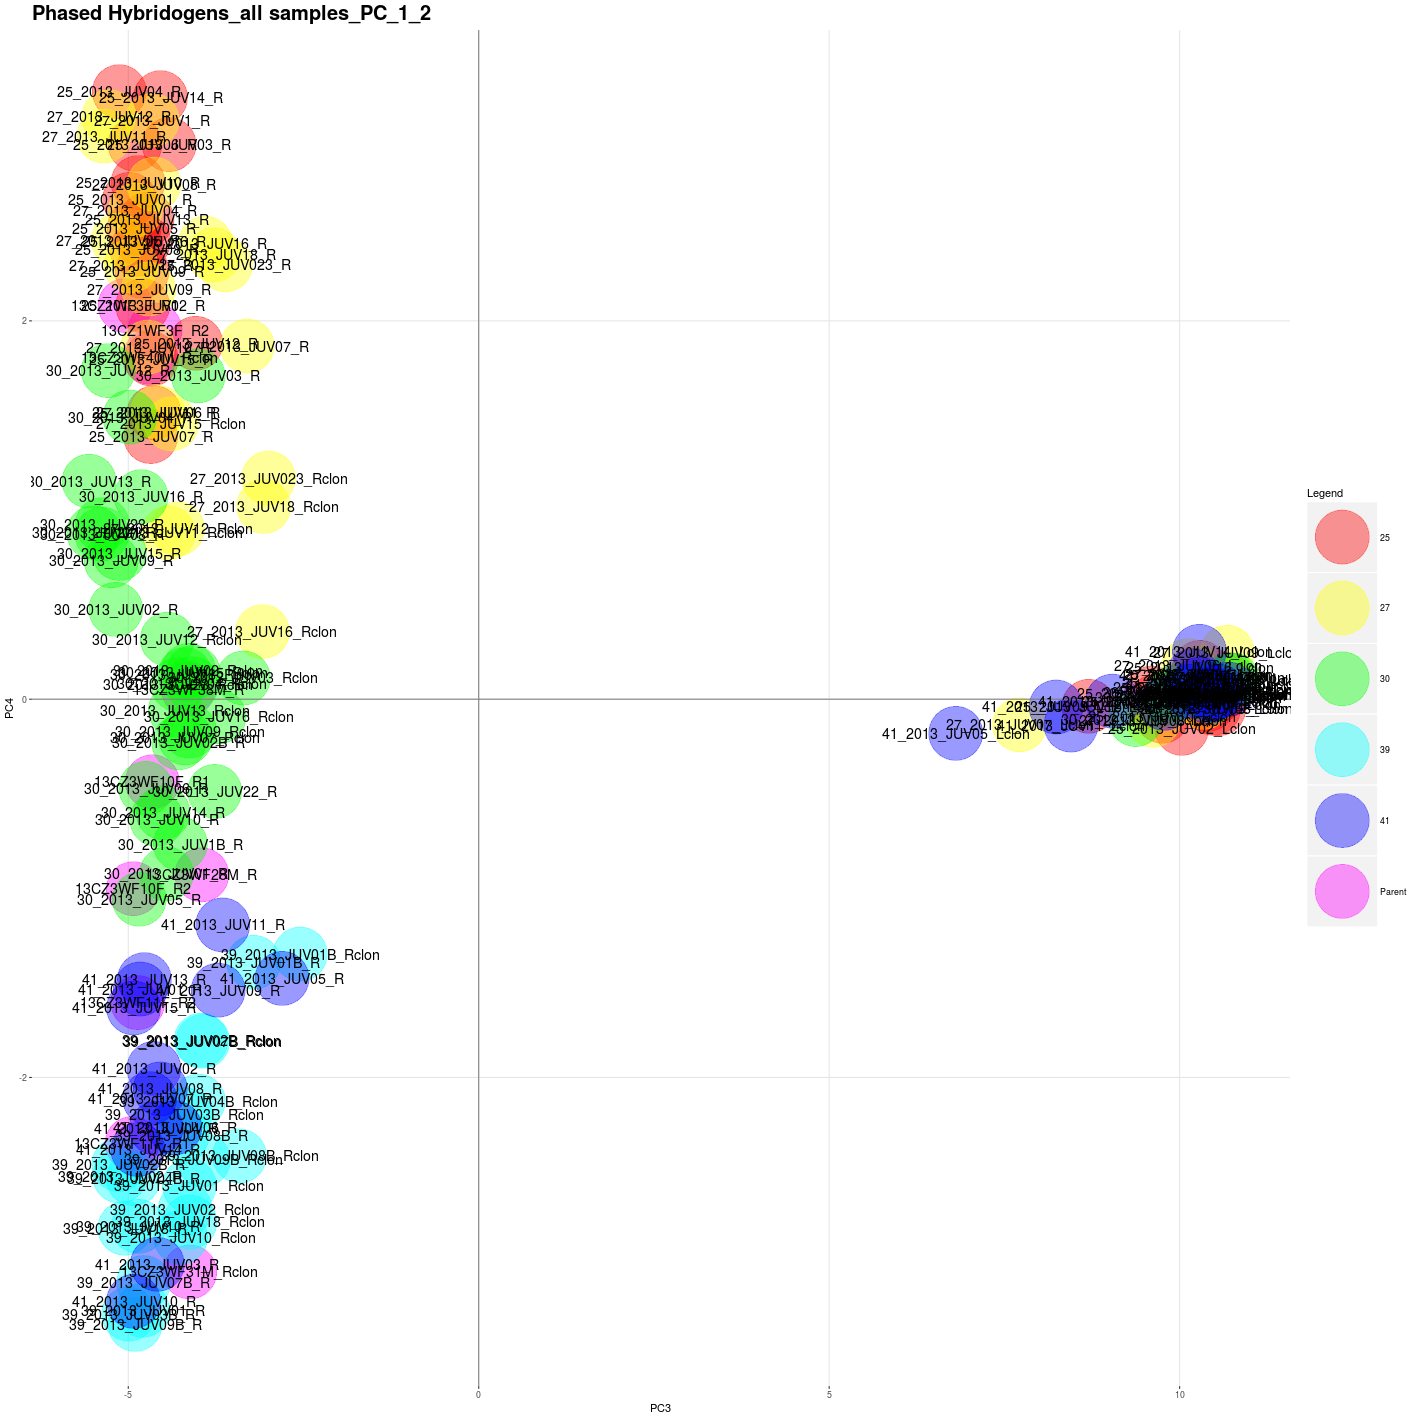

In [751]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

## Sex information - just a two column text file with the sample name in the first column and the sex (M or F) in the second column. Its for labelling the PCA
sexes <- read.delim("./Data_files/popmap_pops_only_KEPT.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plotb
           Title = "Phased Hybridogens_all samples_PC_1_2", ## plot title
           xtitle = "PC3", ## X axis title
           ytitle = "PC4", ## Y axis title 
           Palette = rainbow(6), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

Great, we now have some variation between out R genomes as expected. Lets keep going, adding other locus categories

## D loci

D loci are similar to C loci but are easier to phase as they are homozygous in the mother. These should be pretty informative between R lineages. 

Expectations for D loci are the same as for C.




In [37]:
### D-loci curation

myvcf = vcf.Reader(open(vcf_path, 'r'))


All_fams = [ phased_loci_fam_27, phased_loci_fam_25, phased_loci_fam_30, phased_loci_fam_39, phased_loci_fam_41]

phased_count = 0
single_phased = 0
multiphased_ok_count = 0
multiphased = 0
d_R_alleles_homozygous_in_RL = 0
single_phased_ok_count = 0
D_loci_multiphased_kept = 0
D_loci_single_kept = 0
multiphase_not_on_Rclon = 0
single_not_on_Rclon = 0

KEPT = 0

Kept_D_loci = {}

for record in myvcf:
    
    ## CHECK for C loci - if phased in more than one family, are the phasings for this locus consistent?
    ## loop over each family phasing dictionary, get the c and c_R2 alleles and check that they are consistent.
    
    record_phased = False
    d = None
    d_R = None
    multiphased_ok = False 
    families_phased = 0
    d_R_behaviour_OK = False
    
    for family in All_fams:
        
        if record.ID in family["D_loci"]:
            families_phased += 1
            record_phased = True
            multiphased_ok = True  ## if incosnsitencies arise, this will change to false and the locus will not be used. 
            
            if d == d_R == None:
                d = family["D_loci"][record.ID]["d"]
                d_R = family["D_loci"][record.ID]["d_R"]
            
            elif not all([family["D_loci"][record.ID]["d"] == d, family["D_loci"][record.ID]["d_R"] == d_R]):
                
                multiphased_ok = False
                
       
    ## Check 2) - if phased in only one family, check that the d_R allele is not homozygous in RL offspring (over the threshold. **Note that a couple of missed heterozygous calls can be due to low coverage, 
    ## and can be tolerated, but if many offspring don't are homozygous for the d_R allele, this is indicative of a null allele and the locus should not be used).             
                
    if record_phased:
        phased_count += 1
        
        RL_samples_called = 0
        d_R_homozygous_RL = 0
    
        for sample in record.samples:

            if sample.called and GT_dict[sample.sample] == "RL":
                RL_samples_called += 1

                if sample.gt_bases == "%s/%s" % (d_R, d_R):
                    d_R_homozygous_RL += 1

    
        R_Rclon_families = ["27", "30", "39"]
        
        R_Rclon_heterozygosities = {}
        

        for fam in R_Rclon_families:
            
            called_R_Rclon_samples = 0
            het_R_Rclon_samples = 0
            
            for sample in record.samples:
                
                if fam in sample.sample and sample.called:
                    
                    called_R_Rclon_samples += 1
                        
                    if sample.is_het and any([sample.gt_bases == "%s/%s" % (d, d_R), sample.gt_bases == "%s/%s" % (d_R, d)]):
                            
                        het_R_Rclon_samples += 1
            
            if called_R_Rclon_samples > 0:
                R_Rclon_heterozygosities[fam] = het_R_Rclon_samples / called_R_Rclon_samples
            
            else:
                R_Rclon_heterozygosities[fam] = 0
                
        #print record.ID, "25", R_Rclon_heterozygosities["25"], "27", R_Rclon_heterozygosities["27"], "30", R_Rclon_heterozygosities["30"],"39",  R_Rclon_heterozygosities["39"], "41", R_Rclon_heterozygosities["41"]
    
    
    ## Now use the results of these three checks to decide whether to keep the locus or not. 
    
    if families_phased > 1:
        multiphased += 1
        
        if multiphased_ok: ## if the locus is phased in more than one family and the phasings agree.
            multiphased_ok_count += 1
            
            
            ## If the locus is never heterozygous in more than 70% of [R]R samples (thus can't be on the [R])
            if R_Rclon_heterozygosities["27"] < 0.7 and R_Rclon_heterozygosities["30"] < 0.7 and R_Rclon_heterozygosities["39"] < 0.7:
                    
                multiphase_not_on_Rclon += 1
            
            if d_R_homozygous_RL == 0: ## If the d_R allele is never in RL samples and never homozygous. 
            
                D_loci_multiphased_kept += 1 
                
            if all([R_Rclon_heterozygosities["27"] <= 0.7,
                    R_Rclon_heterozygosities["30"] <= 0.7,
                    R_Rclon_heterozygosities["39"] <= 0.7,
                    d_R_homozygous_RL == 0]): ## If the c_R2 allele is never in RL samples and never homozygous. 
            
                    
                KEPT += 1
                Kept_D_loci[record.ID] = {}
                Kept_D_loci[record.ID]["d"] = d
                Kept_D_loci[record.ID]["d_R"] = d_R
                
 
    
    ## If the locus is only phased in one family 
    
    elif families_phased == 1:
        
        single_phased += 1
        
        if d_R_homozygous_RL == 0: ## if the c_R2 locus is never in RL samples and it is (almost) never homozygous, must be an C locus
            
            D_loci_single_kept += 1
            
        ## If the locus is never heterozygous in more than 70% of [R]R samples (thus can't be on the [R])
        if R_Rclon_heterozygosities["27"] < 0.7 and R_Rclon_heterozygosities["30"] < 0.7 and R_Rclon_heterozygosities["39"] < 0.7:
                    
            single_not_on_Rclon += 1    
            
        if R_Rclon_heterozygosities["27"] < 0.7 and R_Rclon_heterozygosities["30"] < 0.7 and R_Rclon_heterozygosities["39"] < 0.7 and c_R2_homozygous_RL == 0:

            KEPT += 1     
            Kept_D_loci[record.ID] = {}
            Kept_D_loci[record.ID]["d"] = d
            Kept_D_loci[record.ID]["d_R"] = d_R
            

    
print "%s records phased" % phased_count
print "%s are phased in more than one family" % multiphased
print "Of which %s have matching phasings across families" % multiphased_ok_count
print "%s have d_R alleles which are never homozygous in RL samples" % D_loci_multiphased_kept
print "and %s have c_R2 alleles which are never heterozygous in all [R] samples in a family (i.e. not on the [R]) " % multiphase_not_on_Rclon
print "%s loci are phased in only one family" %  single_phased
print "Of which %s have d_R alleles which are never homozygous in RL samples" % D_loci_single_kept
print "and %s have d_R alleles which are never heterozygous in all [R] samples in a family (i.e. not on the [R]) " % single_not_on_Rclon

print "%s C loci kept (pass all checks)" % KEPT

402 records phased
58 are phased in more than one family
Of which 56 have matching phasings across families
43 have d_R alleles which are never homozygous in RL samples
and 14 have c_R2 alleles which are never heterozygous in all [R] samples in a family (i.e. not on the [R]) 
344 loci are phased in only one family
Of which 241 have d_R alleles which are never homozygous in RL samples
and 145 have d_R alleles which are never heterozygous in all [R] samples in a family (i.e. not on the [R]) 
153 C loci kept (pass all checks)


Ok, now add these to the VCF maker again and repeat the PCA

In [753]:
import numpy as np

outvcf = open("%s/Data_files/batch_1_PHASED_curated_A_C_D_haps.vcf" %s working_dir, 'w')


cov_threshold = 10

## write headers

for line in open(hap_vcf_path, 'r').readlines():
    if all([line.startswith("#"), not line.startswith("#CHROM"), not line.startswith("##FORMAT=<ID=GL")]):
        outvcf.write(line)

sample_line_done = False

myvcf = vcf.Reader(open(vcf_path, 'r')) 

discordant_A_samples = {}
discordant_A_loci = {}

discordant_B_samples = {}
discordant_B_loci = {}

discordant_C_samples = {}
discordant_C_loci = {}

discordant_D_samples = {}
discordant_D_loci = {}

loci_dropped = 0

maternal_het_c_R2_loci_counter = 1

for record in myvcf:  ## for each locus

    ## Set REF and ALT alleles for the record (sexual R always REF)
    
    record_phased = False
    
    sample_names = []
    sample_fields = []
    
    N_dropped = 0
    
    
    ########################################################################################################################################
    ########################################################################################################################################
    ###############################################    FOR A-LOCI    #######################################################################
    ########################################################################################################################################
    ########################################################################################################################################
    
    
    if record.ID in Kept_A_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        R_allele = Kept_A_loci[record.ID]["a"]
        L_allele = Kept_A_loci[record.ID]["aL"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  ######################
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
             
            
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_Lclon SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        

            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < record.num_called*0.25: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, REF, ALT, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    
    
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################
    #################################################################   C - loci   ##############################################################################################################
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################
    
    
    
    elif record.ID in Kept_C_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        c_allele = Kept_C_loci[record.ID]["c"]
        c_R2_allele = Kept_C_loci[record.ID]["c_R2"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  (mothers) ############
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" ## c allele always 0
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        ## It is not possible to phase these loci in the mothers, so I will alternate which subgenome gets the c_R2 allele.
                        
                        if maternal_het_c_R2_loci_counter == 1:
                            maternal_het_c_R2_loci_counter = 2
                        
                            sample_1_gt = "0/0" 
                            sample_2_gt = "1/1" 

                            DP = 20
                            AD1_1 = 20
                            AD1_2 = 0
                            AD2_1 = 0
                            AD2_2 = 20
                            NS += 2
                        
                        elif maternal_het_c_R2_loci_counter == 2:
                            maternal_het_c_R2_loci_counter = 1
                        
                            sample_1_gt = "1/1" 
                            sample_2_gt = "0/0" 

                            DP = 20
                            AD1_1 = 0
                            AD1_2 = 20
                            AD2_1 = 20
                            AD2_2 = 0
                            NS += 2
                    
                    elif sample.gt_bases == "%s/%s" % (c_R2_allele, c_R2_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        

                    ## Here if the sample is heterozygous
                    
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                        ## Note that in the curation I already made sure that the c_R2 alleles must be on the sexual R, not the [R]
                    
                    elif sample.gt_bases == "%s/%s" % (c_R2_allele, c_R2_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
             
            
                ###############################################################
                ###############################################################
                ################ FOR Rclon_Lclon SAMPLES (fathers) ############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        

            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < record.num_called*0.25: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, REF, ALT, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    

    
    
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################
    #################################################################   D - loci   ##############################################################################################################
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################    
    
    
    
    elif record.ID in Kept_D_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        d_allele = Kept_D_loci[record.ID]["d"]
        d_R_allele = Kept_D_loci[record.ID]["d_R"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  (mothers) ############
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (d_allele, d_allele):
                        
                        sample_1_gt = "0/0" ## c allele always 0
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    
                    elif sample.gt_bases == "%s/%s" % (d_allele, d_R_allele) or sample.gt_bases == "%s/%s" % (d_R_allele, d_allele):
                        
                        ## It is not possible to phase these loci in the mothers, so I will alternate which subgenome gets the c_R2 allele.
                        
                        if maternal_het_c_R2_loci_counter == 1:
                            maternal_het_c_R2_loci_counter = 2
                        
                            sample_1_gt = "0/0" 
                            sample_2_gt = "1/1" 

                            DP = 20
                            AD1_1 = 20
                            AD1_2 = 0
                            AD2_1 = 0
                            AD2_2 = 20
                            NS += 2
                        
                        elif maternal_het_c_R2_loci_counter == 2:
                            maternal_het_c_R2_loci_counter = 1
                        
                            sample_1_gt = "1/1" 
                            sample_2_gt = "0/0" 

                            DP = 20
                            AD1_1 = 0
                            AD1_2 = 20
                            AD2_1 = 20
                            AD2_2 = 0
                            NS += 2
                    
                    elif sample.gt_bases == "%s/%s" % (d_R_allele, d_R_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (d_allele, d_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        

                    ## Here if the sample is heterozygous
                    
                    elif sample.gt_bases == "%s/%s" % (d_allele, d_R_allele) or sample.gt_bases == "%s/%s" % (d_R_allele, d_allele):
                        
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                        ## Note that in the curation I already made sure that the c_R2 alleles must be on the sexual R, not the [R]
                    
                    elif sample.gt_bases == "%s/%s" % (d_R_allele, d_R_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (d_allele, d_R_allele) or sample.gt_bases == "%s/%s" % (d_R_allele, d_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (d_allele, d_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (d_allele, d_R_allele) or sample.gt_bases == "%s/%s" % (d_R_allele, d_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (d_allele, d_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
             
            
                ###############################################################
                ###############################################################
                ################ FOR Rclon_Lclon SAMPLES (fathers) ############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (d_allele, d_R_allele) or sample.gt_bases == "%s/%s" % (d_R_allele, d_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (d_allele, d_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        

            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < record.num_called*0.25: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, REF, ALT, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    
    
    
    else:
        pass 

outvcf.close()
print "%s loci dropped due to missing data" % loci_dropped

170 loci dropped due to missing data


## PCA

In [ ]:
%%bash

wd=/home/djeffrie/Data/RADseq/Hybridogens/  ## just change this line with your own working dir

## All data 
sed 's/_/-/g' $wd/Data_files/batch_1_PHASED_curated_A_C_D_haps.vcf > $wd/batch_1_PHASED_curated_A_C_D_haps_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_PHASED_curated_A_C_D_haps_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_PHASED_curated_A_C_D_haps_altered_adegenet_plink




In [ ]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R") ## just change this path to wherever you put the R script

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Hybridogens_paper/") 

## All SNPs 
alldata <- read.PLINK('./Data_files/batch_1_PHASED_curated_A_C_D_haps_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



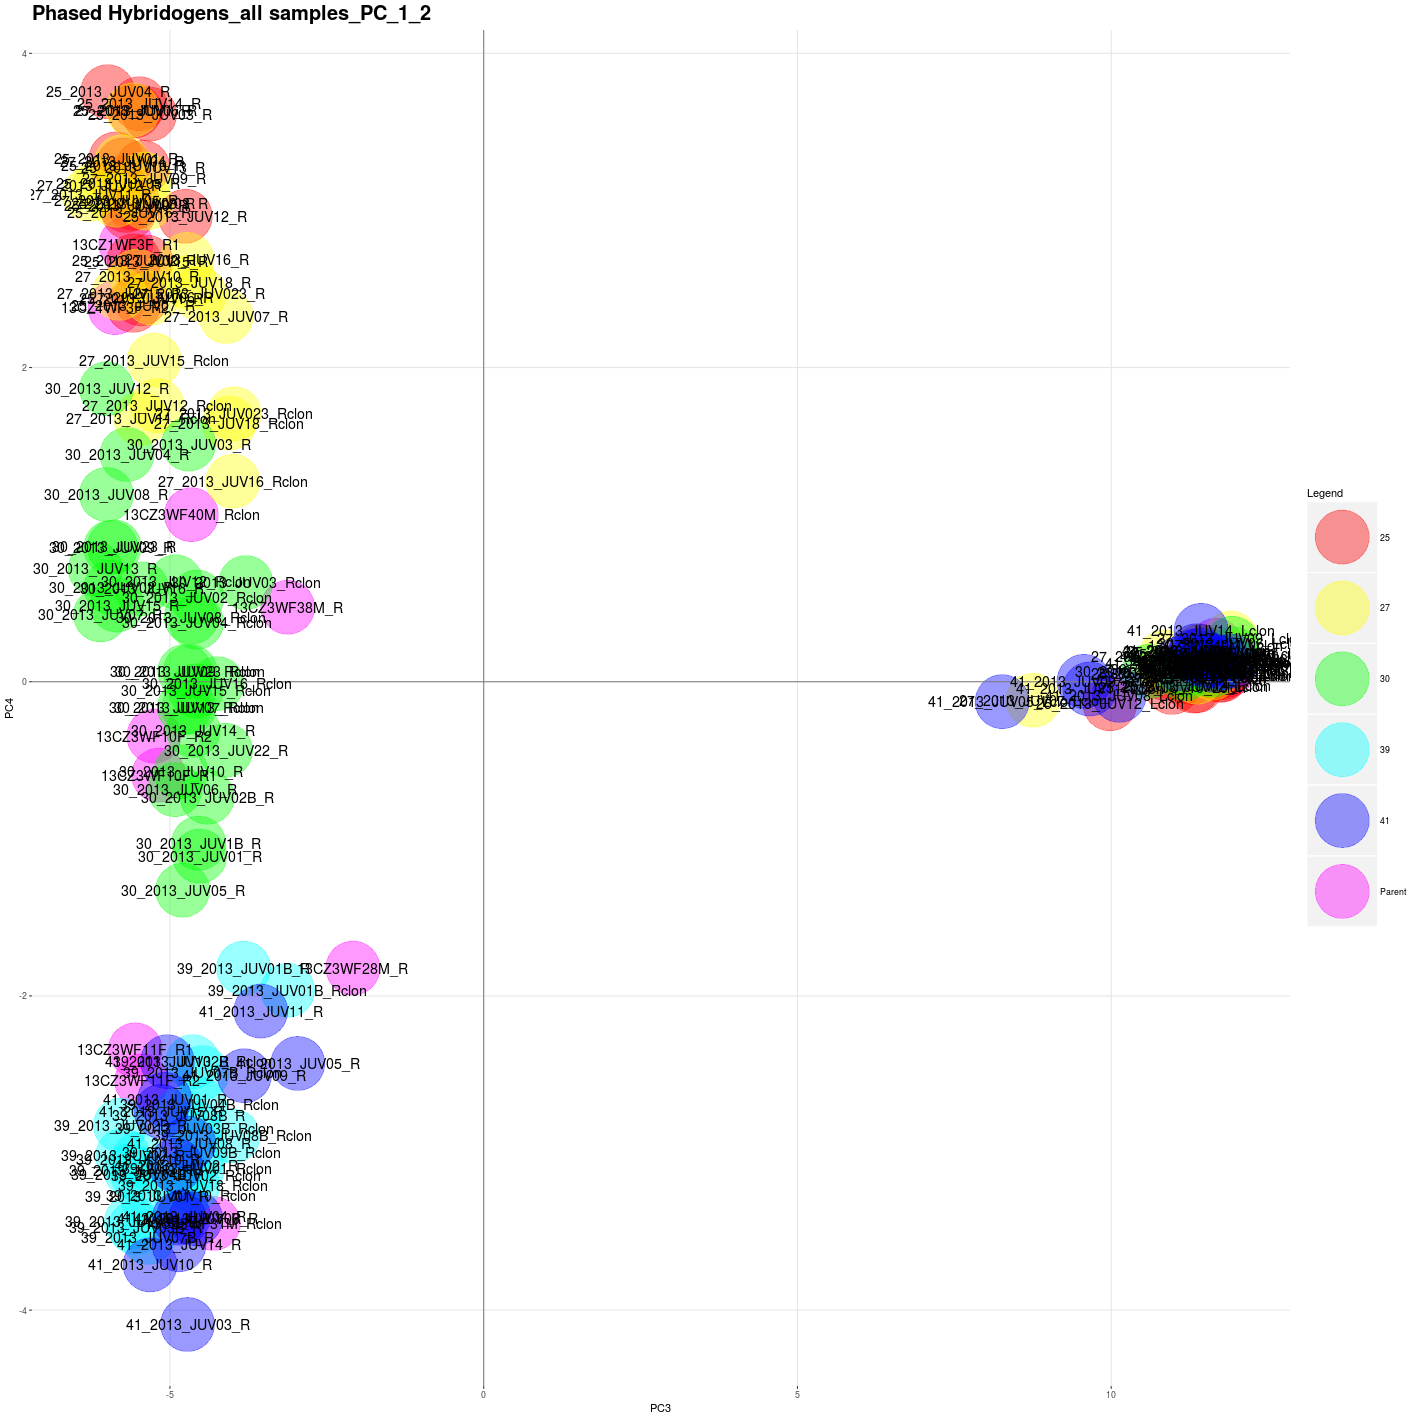

In [756]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

## Sex information - just a two column text file with the sample name in the first column and the sex (M or F) in the second column. Its for labelling the PCA
sexes <- read.delim("./Data_files/popmap_pops_only_KEPT.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plotb
           Title = "Phased Hybridogens_all samples_PC_1_2", ## plot title
           xtitle = "PC3", ## X axis title
           ytitle = "PC4", ## Y axis title 
           Palette = rainbow(6), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

This didn't add too much more signal, but C and D loci should be analagous in the signal they provide, so its not too surprising. 

## B loci

Finally, we add the B-loci. These should be instrumental in bringing out the structure between the clonal R genomes and the sexual Rs.

So we can only have B-loci in families 27, 30 and 39.

We expect that an allele that is derived on the branch leading to a clonal [R] genome can never be homozygous. And it can only be found in either [R]R or [R][L] samples. So we will do two checks here:

1) If phased in more than one family, do the phases match. 

2) regardless of how many families it is phased in, is the b_R1 allele ever homozygous, or ever in an RL sample? If so discard the locus. 

easy!

In [38]:
## B-loci curation 

myvcf = vcf.Reader(open(vcf_path, 'r'))


Rclon_fams = [phased_loci_fam_39, phased_loci_fam_27, phased_loci_fam_30]

phased_count = 0

multiphased = 0
multiphased_ok_count = 0
multi_homozygous_in_RLs = 0

single_phased = 0
single_homozygous_in_RLs = 0
single_phased_ok_count = 0

KEPT = 0

RR_B_loci_phasing_dict = {}
RL_B_loci_phasing_dict = {}

Kept_B_loci = {}

for record in myvcf:
    
    ## CHECK 1) - if phased in more than one family, are the phasings for this locus consistent?
    ## loop over each family phasing dictionary, get the a and b_R1 alleles and check that they are consistent.
    
    record_phased = False
    b = None
    b_R1 = None
    multiphased_ok = False 
    families_phased = 0
    b_R1_behaviour_OK = False
    
    for family in Rclon_fams:
        
        if record.ID in family["B_loci"]:
            families_phased += 1
            record_phased = True
            multiphased_ok = False   
            
            if b == b_R1 == None:
                b = family["B_loci"][record.ID]["b"]
                b_R1 = family["B_loci"][record.ID]["b_R1"]
            
            elif all([family["B_loci"][record.ID]["b"] == b, family["B_loci"][record.ID]["b_R1"] == b_R1]):
                
                multiphased_ok = True
                

    ## Check 2) - check that the b_R1 allele is never homozygous and never present in RL samples.             
                
    if record_phased:
        phased_count += 1
        
        RL_samples_called = 0
        b_R1_homozygous_in_RLs = 0
        
        RR_B_loci_phasing_dict[record.ID] = {}
        RL_B_loci_phasing_dict[record.ID] = {}
        
        for sample in record.samples:

            if sample.called and GT_dict[sample.sample] == "RL":
                RL_samples_called += 1

                if sample.gt_bases == "%s/%s" % (b_R1, b_R1):
                    b_R1_homozygous_in_RLs += 1
                                          
        
        ## Another thing is that if an [R]R sample is het at a B locus phased in another family, that locus could be the opposit phase (because a lot of variation is likely shared between [R]s and Rs)
        
        ## So here I will check to see how often the b_R1 allele is on the clonal R in families other than that in which it was phased. 
        
        
        
        RR_samples_called = 0
        RRs_heterozygous = 0
        
        for fam in ["27", "30", "39"]:    
            
            RR_B_loci_phasing_dict[record.ID][fam] = {}
            
            for sample in record.samples:
                                
                if fam in sample.sample and GT_exp_dict[sample.sample] == "Rclon_R" and sample.called:
                    
                    RR_samples_called += 1
                    
                    if sample.is_het:
                        RRs_heterozygous += 1
                        
            if RR_samples_called > 0:
                if RRs_heterozygous/RR_samples_called < 0.2:
                    RR_B_loci_phasing_dict[record.ID][fam] = "bb"

                elif 0.3 <= RRs_heterozygous/RR_samples_called <= 0.7:
                    RR_B_loci_phasing_dict[record.ID][fam] = "b_R1_on_sexual_R"

                elif RRs_heterozygous/RR_samples_called >= 0.8:
                    RR_B_loci_phasing_dict[record.ID][fam] = "b_R1_on_clonal_R"

                else:
                    RR_B_loci_phasing_dict[record.ID][fam] = "inconclusive"
                    
            else:
                RR_B_loci_phasing_dict[record.ID][fam] = "missing"
                
        
        ## And I have to do the same thing for the RL samples.
        
        RL_samples_called = 0
        RLs_heterozygous = 0
        
        for fam in ["25", "27", "30", "39", "41"]:    
            
            RL_B_loci_phasing_dict[record.ID][fam] = {}
            
            for sample in record.samples:
                                
                if fam in sample.sample and GT_dict[sample.sample] == "RL" and sample.called:
                    
                    RL_samples_called += 1
                    
                    if sample.is_het:
                        RLs_heterozygous += 1
                        
            if RL_samples_called > 0:
                if RLs_heterozygous/RL_samples_called < 0.2:
                    RL_B_loci_phasing_dict[record.ID][fam] = "bb"

                elif 0.3 <= RLs_heterozygous/RL_samples_called <= 0.7:
                    RL_B_loci_phasing_dict[record.ID][fam] = "b_R1_on_sexual_R"

                elif RLs_heterozygous/RL_samples_called >= 0.8:
                    RL_B_loci_phasing_dict[record.ID][fam] = "b_R1_on_clonal_L"

                else:
                    RL_B_loci_phasing_dict[record.ID][fam] = "inconclusive"
                    
            else:
                RL_B_loci_phasing_dict[record.ID][fam] = "missing"

           

   
        ## Now use the results of these two checks to decide whether to keep the locus or not. 

        if families_phased > 1:
            multiphased += 1

            if multiphased_ok:
                multiphased_ok_count += 1

                if b_R1_homozygous_in_RLs <= 2:
                    KEPT += 1
                    Kept_B_loci[record.ID] = {}
                    Kept_B_loci[record.ID]["b_R1"] = b_R1
                    Kept_B_loci[record.ID]["b"] = b
                    
                else:
                    multi_homozygous_in_RLs += 1
                    
        else:
            if b_R1_homozygous_in_RLs <= 2:
                
                single_phased += 1
                
                KEPT += 1     
                Kept_B_loci[record.ID] = {}
                Kept_B_loci[record.ID]["b_R1"] = b_R1
                Kept_B_loci[record.ID]["b"] = b
                
            else:
                single_homozygous_in_RLs += 1
            
    
print "%s records phased" % phased_count
print "%s are phased in more than one Rclon family" % multiphased
print "Of which %s have matching phasings across families" % multiphased_ok_count
print "Of which %s are never homozygous for the b_R1 allele in RL offspring" % (multiphased_ok_count - multi_homozygous_in_RLs)
print "%s loci are phased in only one family" % single_phased
print "Of which %s are never homozygous for the b_R1 allele in RL offspring" % (single_phased - single_homozygous_in_RLs)
print "%s B loci kept" % KEPT

255 records phased
19 are phased in more than one Rclon family
Of which 19 have matching phasings across families
Of which 19 are never homozygous for the b_R1 allele in RL offspring
220 loci are phased in only one family
Of which 204 are never homozygous for the b_R1 allele in RL offspring
239 B loci kept


In [74]:
import numpy as np

outvcf = open("%s/Data_files/batch_1_PHASED_curated_A_B_C_D_haps.vcf" %s working_dir, 'w')

cov_threshold = 10

locus_drop_thresh = 20

## write headers

for line in open(vcf_path, 'r').readlines():
    if all([line.startswith("#"), not line.startswith("#CHROM"), not line.startswith("##FORMAT=<ID=GL")]):
        outvcf.write(line)

sample_line_done = False

myvcf = vcf.Reader(open(vcf_path, 'r')) 

discordant_A_samples = {}
discordant_A_loci = {}

discordant_B_samples = {}
discordant_B_loci = {}

discordant_C_samples = {}
discordant_C_loci = {}

discordant_D_samples = {}
discordant_D_loci = {}

loci_dropped = 0

maternal_het_b_R2_loci_counter = 1
maternal_het_c_R2_loci_counter = 1
maternal_het_d_R2_loci_counter = 1

for record in myvcf:  ## for each locus

    ## Set REF and ALT alleles for the record (sexual R always REF)
    
    record_phased = False
    
    sample_names = []
    sample_fields = []
    
    N_dropped = 0
    
    NS = 0
    
    ########################################################################################################################################
    ########################################################################################################################################
    ###############################################    FOR A-LOCI    #######################################################################
    ########################################################################################################################################
    ########################################################################################################################################
    
    
    if record.ID in Kept_A_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        R_allele = Kept_A_loci[record.ID]["a"]
        L_allele = Kept_A_loci[record.ID]["aL"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  ######################
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
             
            
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_Lclon SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (R_allele, L_allele) or sample.gt_bases == "%s/%s" % (L_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (R_allele, R_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (L_allele, L_allele):
                        
                        sample_1_gt = "1/1" ## R allele always 0
                        sample_2_gt = "1/1" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_A_samples:
                            discordant_A_samples[sample.sample] = []
                        discordant_A_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_A_loci:
                            discordant_A_loci[record.ID] = []
                        discordant_A_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR LL SAMPLES ########################
                ###############################################################
                ###############################################################
                
                ## still going to duplicate so I don't have to drastically change the structure of the code,  
                ## should just plot both on top of eachother
                
                
                elif GT_exp_dict[sample.sample] == "L_L": ## if the sample is LL
                    
                    
                    sample_1 = "%s_LL" % sample.sample
                    sample_2 = "%s_LL" % sample.sample

                    sample_names.append("%s_1" % sample_1)
                    sample_names.append("%s_2" % sample_2)
                    
                    
                    if sample.called and sample.is_het == False:
                        
                        NS += 2
                        
                        ## make duplicate sample names

                        sample_1_gt = sample["GT"]
                        sample_2_gt = sample["GT"]

                        DP = sample["DP"]
                        AD1_1 = sample["AD"][0]
                        AD2_1 = sample["AD"][0]
                        AD1_2 = sample["AD"][1]
                        AD2_2 = sample["AD"][1]

                    else:
                        N_dropped += 1

                        sample_1_gt = "./."
                        sample_2_gt = "./."

                        DP = 0
                        AD1_1 = "."
                        AD2_1 = "."
                        AD1_2 = "."
                        AD2_2 = "."
            
            
            
            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < locus_drop_thresh: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, R_allele, L_allele, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################
    #################################################################   B - loci   ##############################################################################################################
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################
    
    
    
    elif record.ID in Kept_B_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        b_allele = Kept_B_loci[record.ID]["b"]
        b_R1_allele = Kept_B_loci[record.ID]["b_R1"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  (mothers) ############
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (b_allele, b_allele):
                        
                        sample_1_gt = "0/0" ## c allele always 0
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    
                    elif sample.gt_bases == "%s/%s" % (b_allele, b_R1_allele) or sample.gt_bases == "%s/%s" % (b_R1_allele, b_allele):
                        
                        ## It is not possible to phase these loci in the mothers, so I will alternate which subgenome gets the c_R2 allele.
                        
                        if maternal_het_b_R2_loci_counter == 1:
                            maternal_het_b_R2_loci_counter = 2
                        
                            sample_1_gt = "0/0" 
                            sample_2_gt = "1/1" 

                            DP = 20
                            AD1_1 = 20
                            AD1_2 = 0
                            AD2_1 = 0
                            AD2_2 = 20
                            NS += 2
                        
                        elif maternal_het_b_R2_loci_counter == 2:
                            maternal_het_b_R2_loci_counter = 1
                        
                            sample_1_gt = "1/1" 
                            sample_2_gt = "0/0" 

                            DP = 20
                            AD1_1 = 0
                            AD1_2 = 20
                            AD2_1 = 20
                            AD2_2 = 0
                            NS += 2
                    
                    elif sample.gt_bases == "%s/%s" % (b_R1_allele, b_R1_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (b_allele, b_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        

                    ## Here if the sample is heterozygous I don't know a priori which genome the b_R1 allele is on so
                    ## I will check the dictionary I made for [R]R samples in the curation step. 
                    
                    
                    #  "missing" "inconclusive" "b_on_clonal_R" "b_on_sexual_R" "bb"
                    
                    elif sample.gt_bases == "%s/%s" % (b_allele, b_R1_allele) or sample.gt_bases == "%s/%s" % (b_R1_allele, b_allele):
                        
                        if record.ID in RR_B_loci_phasing_dict:
                            
                            for fam in ["27", "30", "39"]:
                                if fam in sample.sample:
                                    
                                    if RR_B_loci_phasing_dict[record.ID][fam] == "missing" or RR_B_loci_phasing_dict[record.ID][fam] == "inconclusive":
                                        
                                        sample_1_gt = "./." 
                                        sample_2_gt = "./."

                                        N_dropped += 1
                                        DP = 0
                                        AD1_1 = "."
                                        AD1_2 = "."
                                        AD2_1 = "."
                                        AD2_2 = "."
                                        
                                    elif RR_B_loci_phasing_dict[record.ID][fam] == "b_R1_on_clonal_R":
                                        
                                        sample_1_gt = "1/1" 
                                        sample_2_gt = "0/0" 

                                        DP = 20
                                        AD1_1 = 0
                                        AD1_2 = 20
                                        AD2_1 = 20
                                        AD2_2 = 0
                                        NS += 2
                                        
                                    elif RR_B_loci_phasing_dict[record.ID][fam] == "b_R1_on_sexual_R":
                                        
                                        sample_1_gt = "0/0" 
                                        sample_2_gt = "1/1" 

                                        DP = 20
                                        AD1_1 = 20
                                        AD1_2 = 0
                                        AD2_1 = 0
                                        AD2_2 = 20
                                        NS += 2
                                        
                        ## If its not in the phasing dict then add as missing data because I can't be sure which way the phasing should go.     
                        else:
                            N_dropped += 1

                            sample_1_gt = "./." 
                            sample_2_gt = "./."

                            N_dropped += 1
                            DP = 0
                            AD1_1 = "."
                            AD1_2 = "."
                            AD2_1 = "."
                            AD2_2 = "."
                        
                        ## Note that in the curation I already made sure that the c_R2 alleles must be on the sexual R, not the [R]
                    
                    elif sample.gt_bases == "%s/%s" % (c_R2_allele, c_R2_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_B_samples:
                            discordant_B_samples[sample.sample] = []
                        discordant_B_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_B_loci:
                            discordant_B_loci[record.ID] = []
                        discordant_B_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (b_allele, b_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                    
                    
                    
                    elif sample.gt_bases == "%s/%s" % (b_allele, b_R1_allele) or sample.gt_bases == "%s/%s" % (b_R1_allele, b_allele):
                        
                        if record.ID in RL_B_loci_phasing_dict:
                            
                            for fam in ["25", "27", "30", "39", "41"]:
                                
                                if fam in sample.sample:
                                    
                                    if RL_B_loci_phasing_dict[record.ID][fam] == "missing" or RL_B_loci_phasing_dict[record.ID][fam] == "inconclusive":
                                        
                                        sample_1_gt = "./." 
                                        sample_2_gt = "./."

                                        N_dropped += 1
                                        DP = 0
                                        AD1_1 = "."
                                        AD1_2 = "."
                                        AD2_1 = "."
                                        AD2_2 = "."
                                        
                                    elif RL_B_loci_phasing_dict[record.ID][fam] == "b_R1_on_sexual_R":
                                        
                                        sample_1_gt = "1/1" 
                                        sample_2_gt = "0/0" 

                                        DP = 20
                                        AD1_1 = 0
                                        AD1_2 = 20
                                        AD2_1 = 20
                                        AD2_2 = 0
                                        NS += 2
                                        
                                    elif RL_B_loci_phasing_dict[record.ID][fam] == "b_R1_on_clonal_L":
                                        
                                        sample_1_gt = "0/0" 
                                        sample_2_gt = "1/1" 

                                        DP = 20
                                        AD1_1 = 20
                                        AD1_2 = 0
                                        AD2_1 = 0
                                        AD2_2 = 20
                                        NS += 2
                        
                        
                        ## If its not in the phasing dict then add as missing data because I can't be sure which way the phasing should go.     
                        else:
                            N_dropped += 1

                            sample_1_gt = "./." 
                            sample_2_gt = "./."

                            N_dropped += 1
                            DP = 0
                            AD1_1 = "."
                            AD1_2 = "."
                            AD2_1 = "."
                            AD2_2 = "."
                        
                        
                        
                        
                    elif sample.gt_bases == "%s/%s" % (b_allele, b_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_B_samples:
                            discordant_B_samples[sample.sample] = []
                        discordant_B_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_B_loci:
                            discordant_B_loci[record.ID] = []
                        discordant_B_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
                    
                    
            
            
            
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (b_allele, b_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                    
                    
                    
                    elif sample.gt_bases == "%s/%s" % (b_allele, b_R1_allele) or sample.gt_bases == "%s/%s" % (b_R1_allele, b_allele):
                        
                        if record.ID in RL_B_loci_phasing_dict:
                            
                            for fam in ["25", "27", "30", "39", "41"]:
                                
                                if fam in sample.sample:
                                    
                                    if RL_B_loci_phasing_dict[record.ID][fam] == "missing" or RL_B_loci_phasing_dict[record.ID][fam] == "inconclusive":
                                        
                                        sample_1_gt = "./." 
                                        sample_2_gt = "./."

                                        N_dropped += 1
                                        DP = 0
                                        AD1_1 = "."
                                        AD1_2 = "."
                                        AD2_1 = "."
                                        AD2_2 = "."
                                        
                                    elif RL_B_loci_phasing_dict[record.ID][fam] == "b_R1_on_sexual_R":
                                        
                                        sample_1_gt = "1/1" 
                                        sample_2_gt = "0/0" 

                                        DP = 20
                                        AD1_1 = 0
                                        AD1_2 = 20
                                        AD2_1 = 20
                                        AD2_2 = 0
                                        NS += 2
                                        
                                    elif RL_B_loci_phasing_dict[record.ID][fam] == "b_R1_on_clonal_L":
                                        
                                        sample_1_gt = "0/0" 
                                        sample_2_gt = "1/1" 

                                        DP = 20
                                        AD1_1 = 20
                                        AD1_2 = 0
                                        AD2_1 = 0
                                        AD2_2 = 20
                                        NS += 2
                        
                        
                        ## If its not in the phasing dict then add as missing data because I can't be sure which way the phasing should go.     
                        else:
                            N_dropped += 1

                            sample_1_gt = "./." 
                            sample_2_gt = "./."

                            N_dropped += 1
                            DP = 0
                            AD1_1 = "."
                            AD1_2 = "."
                            AD2_1 = "."
                            AD2_2 = "."
                        
                        
                        
                        
                    elif sample.gt_bases == "%s/%s" % (b_allele, b_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_B_samples:
                            discordant_B_samples[sample.sample] = []
                        discordant_B_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_B_loci:
                            discordant_B_loci[record.ID] = []
                        discordant_B_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        

                
                
                
                ###############################################################
                ###############################################################
                ################ FOR Rclon_Lclon SAMPLES (fathers) ############
                ###############################################################
                ###############################################################
                
                
                #'13CZ3WF28M'
                #'13CZ3WF31M'
                #'13CZ3WF38M'
                #'13CZ3WF40M
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (b_allele, b_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                    
                    
                    
                    elif sample.gt_bases == "%s/%s" % (b_allele, b_R1_allele) or sample.gt_bases == "%s/%s" % (b_R1_allele, b_allele):
                        
                        if record.ID in RL_B_loci_phasing_dict:
                                                            
                            if sample.sample == "13CZ3WF28M":
                                fam = "25"
                            elif sample.sample == "13CZ3WF40M":
                                fam = "27"
                            elif sample.sample == "13CZ3WF31M":
                                fam = "39"
                            elif sample.sample == "13CZ3WF38M":
                                fam = "41"
                                
                                    
                            if RL_B_loci_phasing_dict[record.ID][fam] == "missing" or RL_B_loci_phasing_dict[record.ID][fam] == "inconclusive":
                                        
                                sample_1_gt = "./." 
                                sample_2_gt = "./."

                                N_dropped += 1
                                DP = 0
                                AD1_1 = "."
                                AD1_2 = "."
                                AD2_1 = "."
                                AD2_2 = "."
                                        
                            elif RL_B_loci_phasing_dict[record.ID][fam] == "b_R1_on_sexual_R":
                                        
                                sample_1_gt = "1/1" 
                                sample_2_gt = "0/0" 

                                DP = 20
                                AD1_1 = 0
                                AD1_2 = 20
                                AD2_1 = 20
                                AD2_2 = 0
                                NS += 2
                                        
                            elif RL_B_loci_phasing_dict[record.ID][fam] == "b_R1_on_clonal_L":
                                        
                                sample_1_gt = "0/0" 
                                sample_2_gt = "1/1" 

                                DP = 20
                                AD1_1 = 20
                                AD1_2 = 0
                                AD2_1 = 0
                                AD2_2 = 20
                                NS += 2
                        
                        
                        ## If its not in the phasing dict then add as missing data because I can't be sure which way the phasing should go.     
                        else:
                            N_dropped += 1

                            sample_1_gt = "./." 
                            sample_2_gt = "./."

                            N_dropped += 1
                            DP = 0
                            AD1_1 = "."
                            AD1_2 = "."
                            AD2_1 = "."
                            AD2_2 = "."
                        
                        
                        
                        
                    elif sample.gt_bases == "%s/%s" % (b_allele, b_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_B_samples:
                            discordant_B_samples[sample.sample] = []
                        discordant_B_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_B_loci:
                            discordant_B_loci[record.ID] = []
                        discordant_B_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                    
                ###############################################################
                ###############################################################
                ####################### FOR LL SAMPLES ########################
                ###############################################################
                ###############################################################
                
                ## still going to duplicate so I don't have to drastically change the structure of the code,  
                ## should just plot both on top of eachother
                
                
                elif GT_exp_dict[sample.sample] == "L_L": ## if the sample is LL
                    
                    
                    sample_1 = "%s_LL" % sample.sample
                    sample_2 = "%s_LL" % sample.sample

                    sample_names.append("%s_1" % sample_1)
                    sample_names.append("%s_2" % sample_2)
                    
                    
                    if sample.called and sample.is_het == False:
                        
                        NS += 2
                        
                        ## make duplicate sample names

                        sample_1_gt = sample["GT"]
                        sample_2_gt = sample["GT"]

                        DP = sample["DP"]
                        AD1_1 = sample["AD"][0]
                        AD2_1 = sample["AD"][0]
                        AD1_2 = sample["AD"][1]
                        AD2_2 = sample["AD"][1]

                    else:
                        N_dropped += 1

                        sample_1_gt = "./."
                        sample_2_gt = "./."

                        DP = 0
                        AD1_1 = "."
                        AD2_1 = "."
                        AD1_2 = "."
                        AD2_2 = "."
                    
                    

            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < locus_drop_thresh: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, b_allele, b_R1_allele, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    
    
    
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################
    #################################################################   C - loci   ##############################################################################################################
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################
    
    
    
    elif record.ID in Kept_C_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        c_allele = Kept_C_loci[record.ID]["c"]
        c_R2_allele = Kept_C_loci[record.ID]["c_R2"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  (mothers) ############
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" ## c allele always 0
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        ## It is not possible to phase these loci in the mothers, so I will alternate which subgenome gets the c_R2 allele.
                        
                        if maternal_het_c_R2_loci_counter == 1:
                            maternal_het_c_R2_loci_counter = 2
                        
                            sample_1_gt = "0/0" 
                            sample_2_gt = "1/1" 

                            DP = 20
                            AD1_1 = 20
                            AD1_2 = 0
                            AD2_1 = 0
                            AD2_2 = 20
                            NS += 2
                        
                        elif maternal_het_c_R2_loci_counter == 2:
                            maternal_het_c_R2_loci_counter = 1
                        
                            sample_1_gt = "1/1" 
                            sample_2_gt = "0/0" 

                            DP = 20
                            AD1_1 = 0
                            AD1_2 = 20
                            AD2_1 = 20
                            AD2_2 = 0
                            NS += 2
                    
                    elif sample.gt_bases == "%s/%s" % (c_R2_allele, c_R2_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        

                    ## Here if the sample is heterozygous
                    
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                        ## Note that in the curation I already made sure that the c_R2 alleles must be on the sexual R, not the [R]
                    
                    elif sample.gt_bases == "%s/%s" % (c_R2_allele, c_R2_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
             
            
                ###############################################################
                ###############################################################
                ################ FOR Rclon_Lclon SAMPLES (fathers) ############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (c_allele, c_R2_allele) or sample.gt_bases == "%s/%s" % (c_R2_allele, c_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (c_allele, c_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_C_samples:
                            discordant_C_samples[sample.sample] = []
                        discordant_C_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_C_loci:
                            discordant_C_loci[record.ID] = []
                        discordant_C_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                        
                        
                ###############################################################
                ###############################################################
                ####################### FOR LL SAMPLES ########################
                ###############################################################
                ###############################################################
                
                ## still going to duplicate so I don't have to drastically change the structure of the code,  
                ## should just plot both on top of eachother
                
                
                elif GT_exp_dict[sample.sample] == "L_L": ## if the sample is LL
                    
                    
                    sample_1 = "%s_LL" % sample.sample
                    sample_2 = "%s_LL" % sample.sample

                    sample_names.append("%s_1" % sample_1)
                    sample_names.append("%s_2" % sample_2)
                    
                    
                    if sample.called and sample.is_het == False:
                        
                        NS += 2
                        
                        ## make duplicate sample names

                        sample_1_gt = sample["GT"]
                        sample_2_gt = sample["GT"]

                        DP = sample["DP"]
                        AD1_1 = sample["AD"][0]
                        AD2_1 = sample["AD"][0]
                        AD1_2 = sample["AD"][1]
                        AD2_2 = sample["AD"][1]

                    else:
                        N_dropped += 1

                        sample_1_gt = "./."
                        sample_2_gt = "./."

                        DP = 0
                        AD1_1 = "."
                        AD2_1 = "."
                        AD1_2 = "."
                        AD2_2 = "."
                        

            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
                if not "sample_1_gt" in locals():
                    print sample.sample, sample["GT"]
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < locus_drop_thresh: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, c_allele, c_R2_allele, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    

    
    
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################
    #################################################################   D - loci   ##############################################################################################################
    #############################################################################################################################################################################################
    #############################################################################################################################################################################################    
    
    
    
    elif record.ID in Kept_D_loci:  ## if the locus has been phased for RL 
        
        record_phased = True

        d_allele = Kept_D_loci[record.ID]["d"]
        d_R_allele = Kept_D_loci[record.ID]["d_R"]
        
        for sample in record.samples:
            
            if all([sample.called, sample["DP"] >= cov_threshold, sample.sample not in discards]):
                
            
                ###############################################################
                ###############################################################
                ####################### FOR R_R SAMPLES  (mothers) ############
                ###############################################################
                ###############################################################
                
            
                if GT_exp_dict[sample.sample] == "R_R": ## if the sample is R R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R1" % sample.sample
                    sample_2 = "%s_R2" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (d_allele, d_allele):
                        
                        sample_1_gt = "0/0" ## c allele always 0
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    
                    elif sample.gt_bases == "%s/%s" % (d_allele, d_R_allele) or sample.gt_bases == "%s/%s" % (d_R_allele, d_allele):
                        
                        ## It is not possible to phase these loci in the mothers, so I will alternate which subgenome gets the c_R2 allele.
                        
                        if maternal_het_c_R2_loci_counter == 1:
                            maternal_het_c_R2_loci_counter = 2
                        
                            sample_1_gt = "0/0" 
                            sample_2_gt = "1/1" 

                            DP = 20
                            AD1_1 = 20
                            AD1_2 = 0
                            AD2_1 = 0
                            AD2_2 = 20
                            NS += 2
                        
                        elif maternal_het_d_R2_loci_counter == 2:
                            maternal_het_d_R2_loci_counter = 1
                        
                            sample_1_gt = "1/1" 
                            sample_2_gt = "0/0" 

                            DP = 20
                            AD1_1 = 0
                            AD1_2 = 20
                            AD2_1 = 20
                            AD2_2 = 0
                            NS += 2
                    
                    elif sample.gt_bases == "%s/%s" % (d_R_allele, d_R_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_R SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_R": ## if the sample is [R]R
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_R" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (d_allele, d_allele):
                        
                        sample_1_gt = "0/0" ## R allele always 0
                        sample_2_gt = "0/0" ## L or Rclon allele always 1

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        

                    ## Here if the sample is heterozygous
                    
                    elif sample.gt_bases == "%s/%s" % (d_allele, d_R_allele) or sample.gt_bases == "%s/%s" % (d_R_allele, d_allele):
                        
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                        ## Note that in the curation I already made sure that the c_R2 alleles must be on the sexual R, not the [R]
                    
                    elif sample.gt_bases == "%s/%s" % (d_R_allele, d_R_allele):
                        
                        sample_1_gt = "1/1" ## c allele always 0
                        sample_2_gt = "1/1" 

                        DP = 20
                        AD1_1 = 0
                        AD1_2 = 20
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                
                
                ###############################################################
                ###############################################################
                ####################### FOR R_Lclon SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "R_Lclon": ## if the sample is R[L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_R" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (d_allele, d_R_allele) or sample.gt_bases == "%s/%s" % (d_R_allele, d_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (d_allele, d_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
        
        
                
                ###############################################################
                ###############################################################
                ####################### FOR Rclon_L SAMPLES  ##################
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_L": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_L" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (d_allele, d_R_allele) or sample.gt_bases == "%s/%s" % (d_R_allele, d_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (d_allele, d_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
             
            
                ###############################################################
                ###############################################################
                ################ FOR Rclon_Lclon SAMPLES (fathers) ############
                ###############################################################
                ###############################################################
                
                
                elif GT_exp_dict[sample.sample] == "Rclon_Lclon": ## if the sample is [R][L]
                    
                    ## make duplicate sample names
                    
                    sample_1 = "%s_Rclon" % sample.sample
                    sample_2 = "%s_Lclon" % sample.sample

                    sample_names.append(sample_1)
                    sample_names.append(sample_2)
                    

                    if sample.gt_bases == "%s/%s" % (d_allele, d_R_allele) or sample.gt_bases == "%s/%s" % (d_R_allele, d_allele):
                        
                        sample_1_gt = "1/1" ## R genome will have derived allele c_R2
                        sample_2_gt = "0/0" ## L genome will have ancestral allele (c_allele)

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 0
                        AD2_2 = 20
                        NS += 2
                        
                    elif sample.gt_bases == "%s/%s" % (d_allele, d_allele):
                        
                        sample_1_gt = "0/0" 
                        sample_2_gt = "0/0" 

                        DP = 20
                        AD1_1 = 20
                        AD1_2 = 0
                        AD2_1 = 20
                        AD2_2 = 0
                        NS += 2
                        
                    ## RL samples cannot be homozygous for the c_R2 allele so we don't check for it here. 
                        
                    
                    else: ## keep a record of discordant loci and samples and set locus as missing in this sample
                        
                        if sample.sample not in discordant_D_samples:
                            discordant_D_samples[sample.sample] = []
                        discordant_D_samples[sample.sample].append(record.ID)
                        
                        if record.ID not in discordant_D_loci:
                            discordant_D_loci[record.ID] = []
                        discordant_D_loci[record.ID].append(sample.sample)
                            
                        sample_1_gt = "./." 
                        sample_2_gt = "./."
                            
                        N_dropped += 1
                        DP = 0
                        AD1_1 = "."
                        AD1_2 = "."
                        AD2_1 = "."
                        AD2_2 = "."
                        
                ###############################################################
                ###############################################################
                ####################### FOR LL SAMPLES ########################
                ###############################################################
                ###############################################################
                
                ## still going to duplicate so I don't have to drastically change the structure of the code,  
                ## should just plot both on top of eachother
                
                
                elif GT_exp_dict[sample.sample] == "L_L": ## if the sample is LL
                    
                    
                    sample_1 = "%s_LL" % sample.sample
                    sample_2 = "%s_LL" % sample.sample

                    sample_names.append("%s_1" % sample_1)
                    sample_names.append("%s_2" % sample_2)
                    
                    
                    if sample.called and sample.is_het == False:
                        
                        NS += 2
                        
                        ## make duplicate sample names

                        sample_1_gt = sample["GT"]
                        sample_2_gt = sample["GT"]

                        DP = sample["DP"]
                        AD1_1 = sample["AD"][0]
                        AD2_1 = sample["AD"][0]
                        AD1_2 = sample["AD"][1]
                        AD2_2 = sample["AD"][1]

                    else:
                        N_dropped += 1

                        sample_1_gt = "./."
                        sample_2_gt = "./."

                        DP = 0
                        AD1_1 = "."
                        AD2_1 = "."
                        AD1_2 = "."
                        AD2_2 = "."
                    
                    
                    
                    
                    

                        

            elif all([any([sample.called == False, sample["DP"] < cov_threshold]), sample.sample not in discards]):
                
                #print record.ID, sample.sample
                
                sample_1_GT = GT_exp_dict[sample.sample].split("_")[0]
                sample_2_GT = GT_exp_dict[sample.sample].split("_")[1]
                
                sample_1 = "%s_%s" % (sample.sample, sample_1_GT)
                sample_2 = "%s_%s" % (sample.sample, sample_2_GT)

                sample_names.append(sample_1)
                sample_names.append(sample_2)
                
                sample_1_gt = "./." 
                sample_2_gt = "./."
                
                N_dropped += 1
                DP = 0
                AD1_1 = "."
                AD1_2 = "."
                AD2_1 = "."
                AD2_2 = "."
            

            
            if sample.sample not in discards:
            
                ## Now compile other data - e.g. DP, AD, GL and construct the sample field string.

                ## Coverage is no longer informative in this pseudo-synthetic VCF so will just say all loci are 20 reads deep, 10 reads per allele
                ## GL is also not useful, so will leave blank

                sample_1_field = "%s:%s:%s,%s" % (sample_1_gt, DP, AD1_1, AD1_2)
                sample_2_field = "%s:%s:%s,%s" % (sample_2_gt, DP, AD2_1, AD2_2)

                sample_fields.append(sample_1_field)
                sample_fields.append(sample_2_field)

        
        ### Write sample line if not already done
        
        if sample_line_done == False:
            sample_line = "#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\t%s\n" % "\t".join(sample_names)
            outvcf.write(sample_line)
            sample_line_done = True
        
        
        ## Check that the number of samples dropped was not too high (if so remove the locus)
        
        if N_dropped < 3: ## if the number of loci dropped above is less than 25% of the samples originally called, then output locus
                
            INFO_columns = ["%s\t%s\t%s\t%s\t%s\t.\tPASS\tNS=%s;AF=%s\tGT:DP:AD" % (record.CHROM, record.POS, record.ID, d_allele, d_R_allele, NS, record.INFO["AF"][0])]
            line = INFO_columns + sample_fields

            outvcf.write("%s\n" % "\t".join(line))
        else:
            loci_dropped += 1
    
    
    
    else:
        pass 

outvcf.close()
print "%s loci dropped due to missing data" % loci_dropped

324 loci dropped due to missing data


## PCA

In [ ]:
%%bash

wd=/home/djeffrie/Data/RADseq/Hybridogens/  ## just change this line with your own working dir

## All data 
sed 's/_/-/g' $wd/Data_files/batch_1_PHASED_curated_A_B_C_D_haps.vcf > $wd/batch_1_PHASED_curated_A_B_C_D_haps_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_PHASED_curated_A_B_C_D_haps_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_PHASED_curated_A_B_C_D_haps_altered_adegenet_plink


In [ ]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R") ## just change this path to wherever you put the R script

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Hybridogens_paper/") 

## All SNPs 
alldata <- read.PLINK('./Data_files/batch_1_PHASED_curated_A_B_C_D_haps_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 

## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



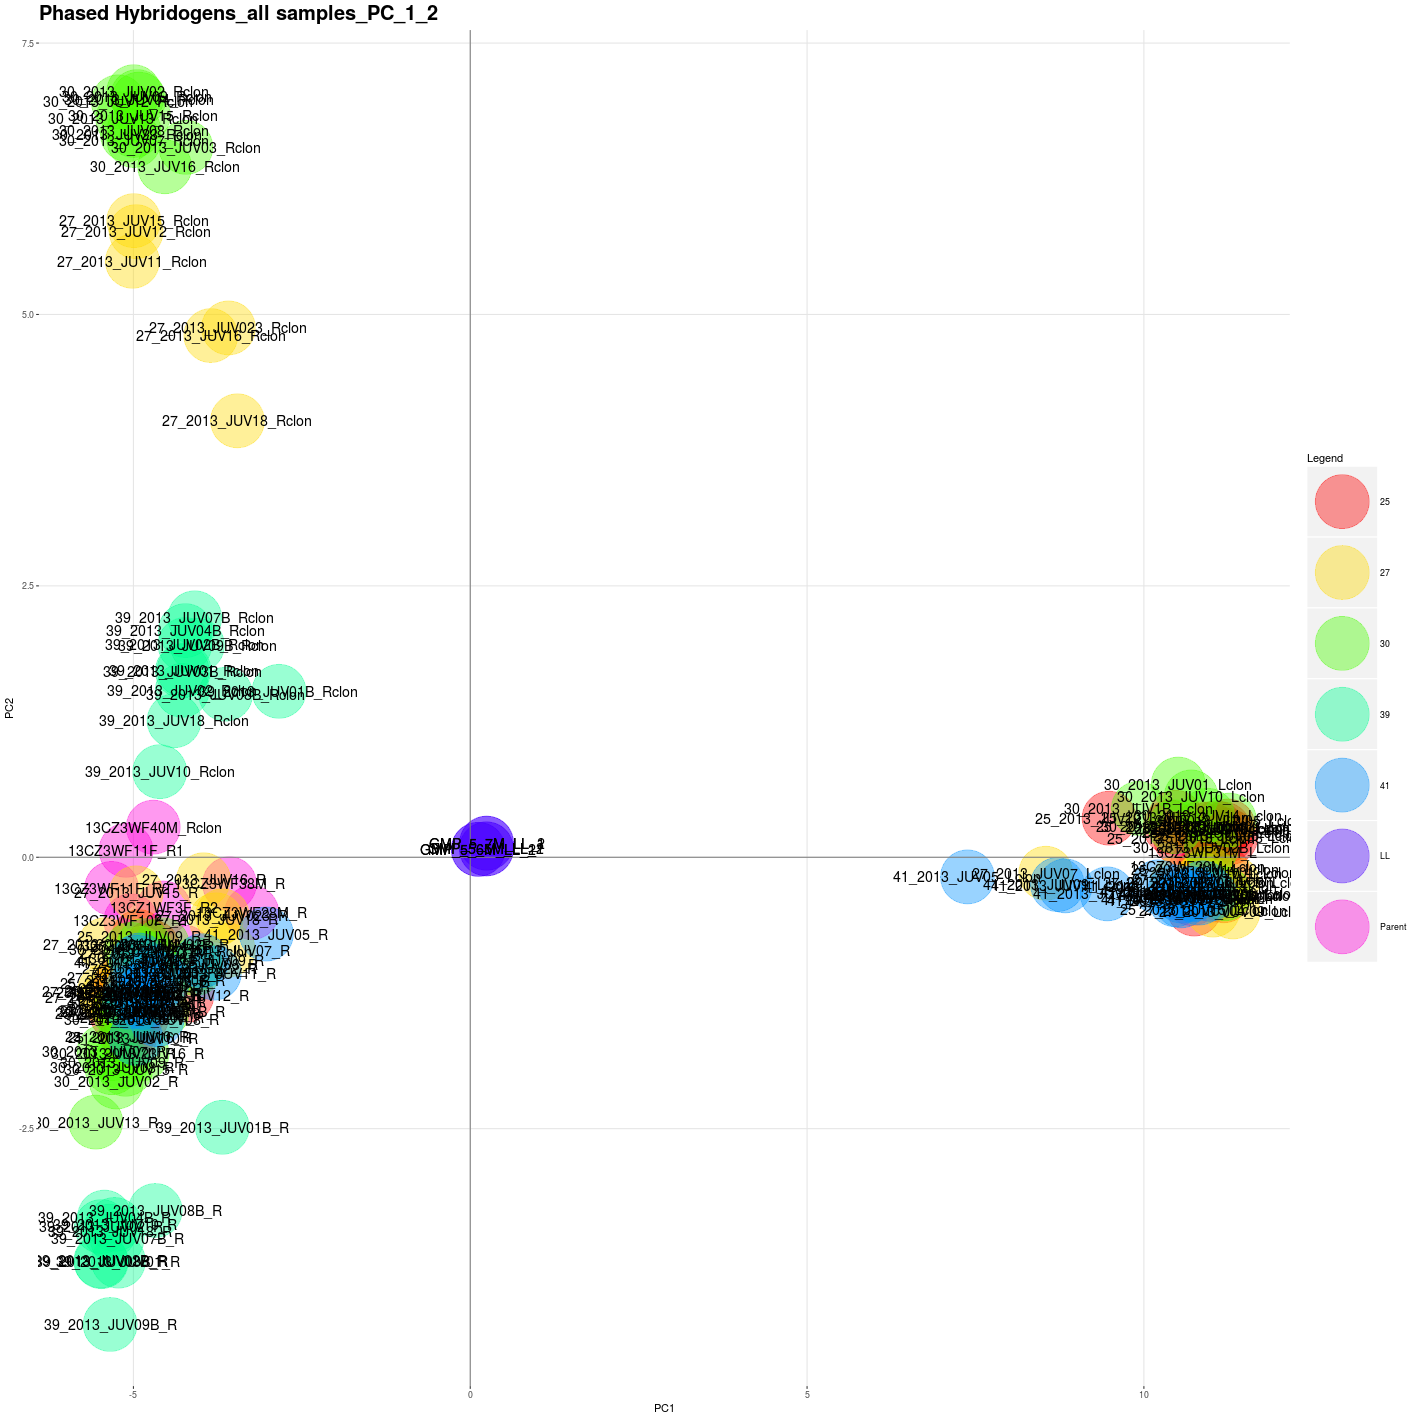

In [77]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

## Sex information - just a two column text file with the sample name in the first column and the sex (M or F) in the second column. Its for labelling the PCA
sexes <- read.delim("./Data_files/popmap_pops_only_KEPT.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plotb
           Title = "Phased Hybridogens_all samples_PC_1_2", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(7), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

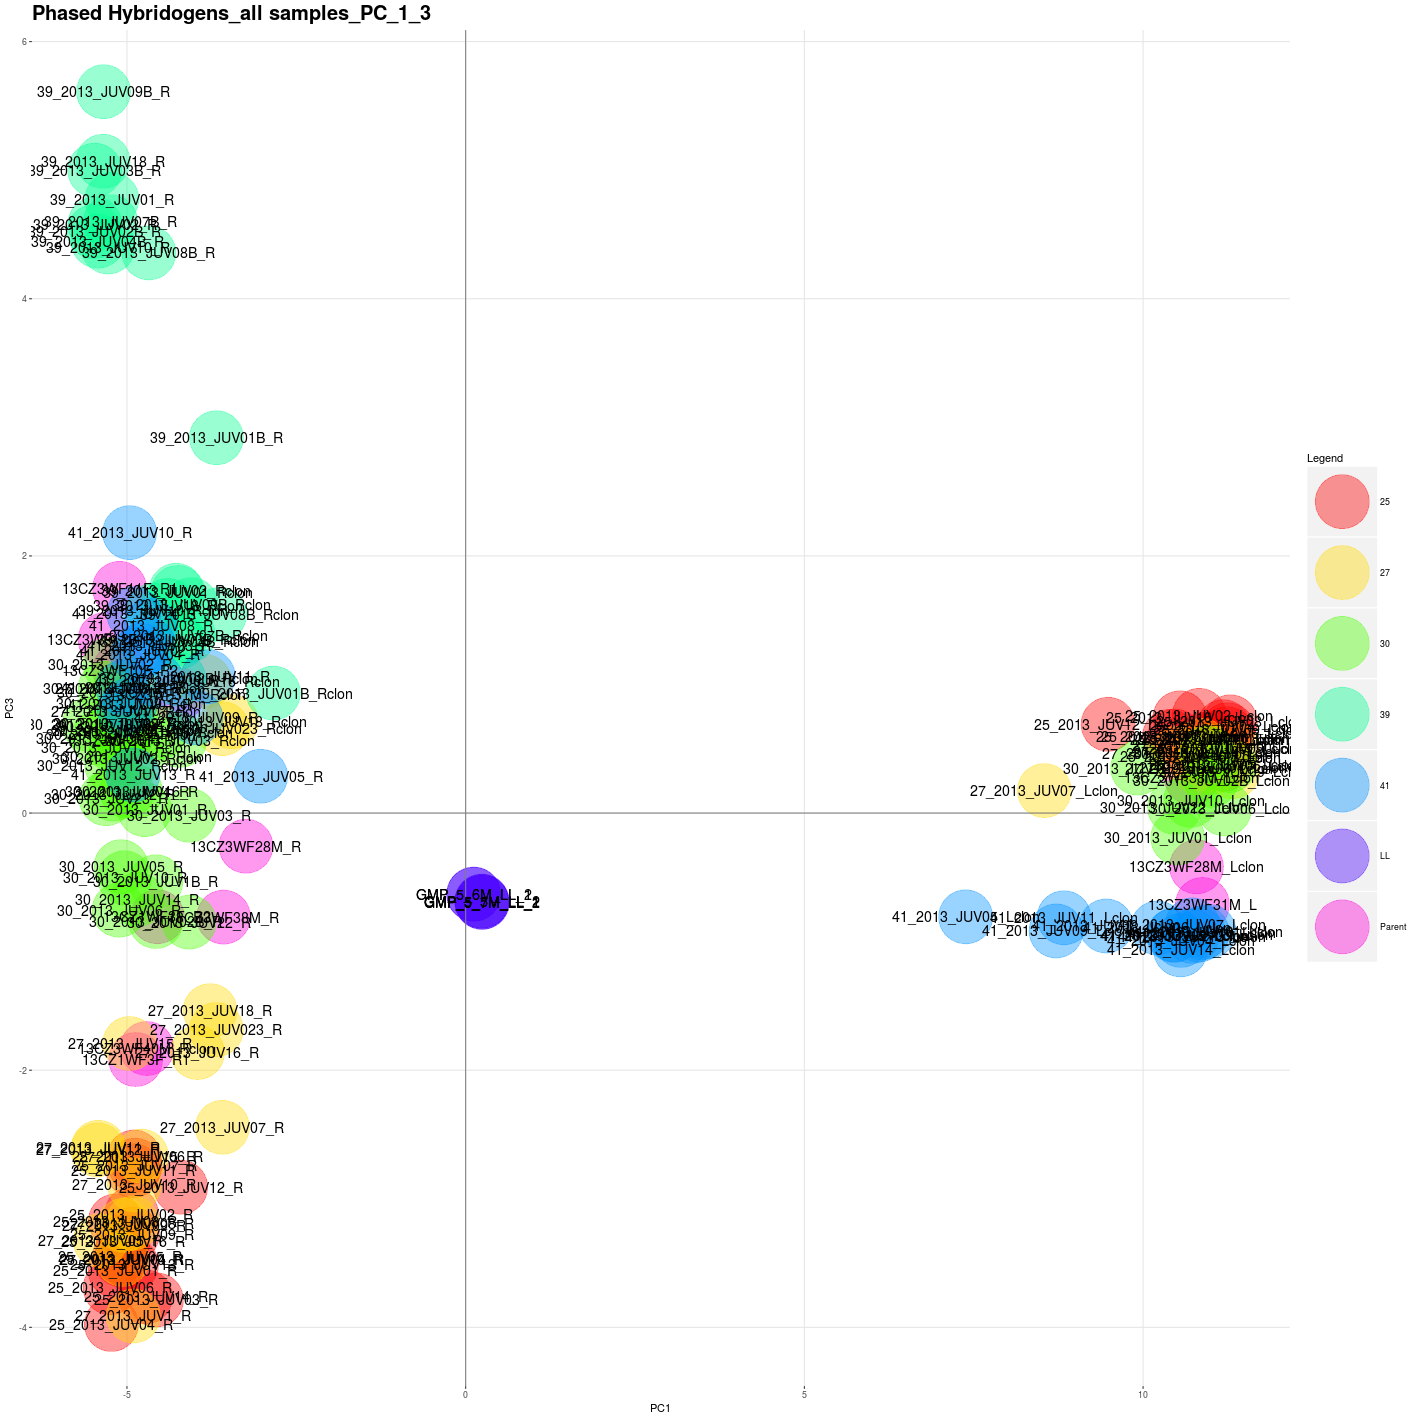

In [78]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

## Sex information - just a two column text file with the sample name in the first column and the sex (M or F) in the second column. Its for labelling the PCA
sexes <- read.delim("./Data_files/popmap_pops_only_KEPT.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,3), ## which components to plotb
           Title = "Phased Hybridogens_all samples_PC_1_3", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC3", ## Y axis title 
           Palette = rainbow(7), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

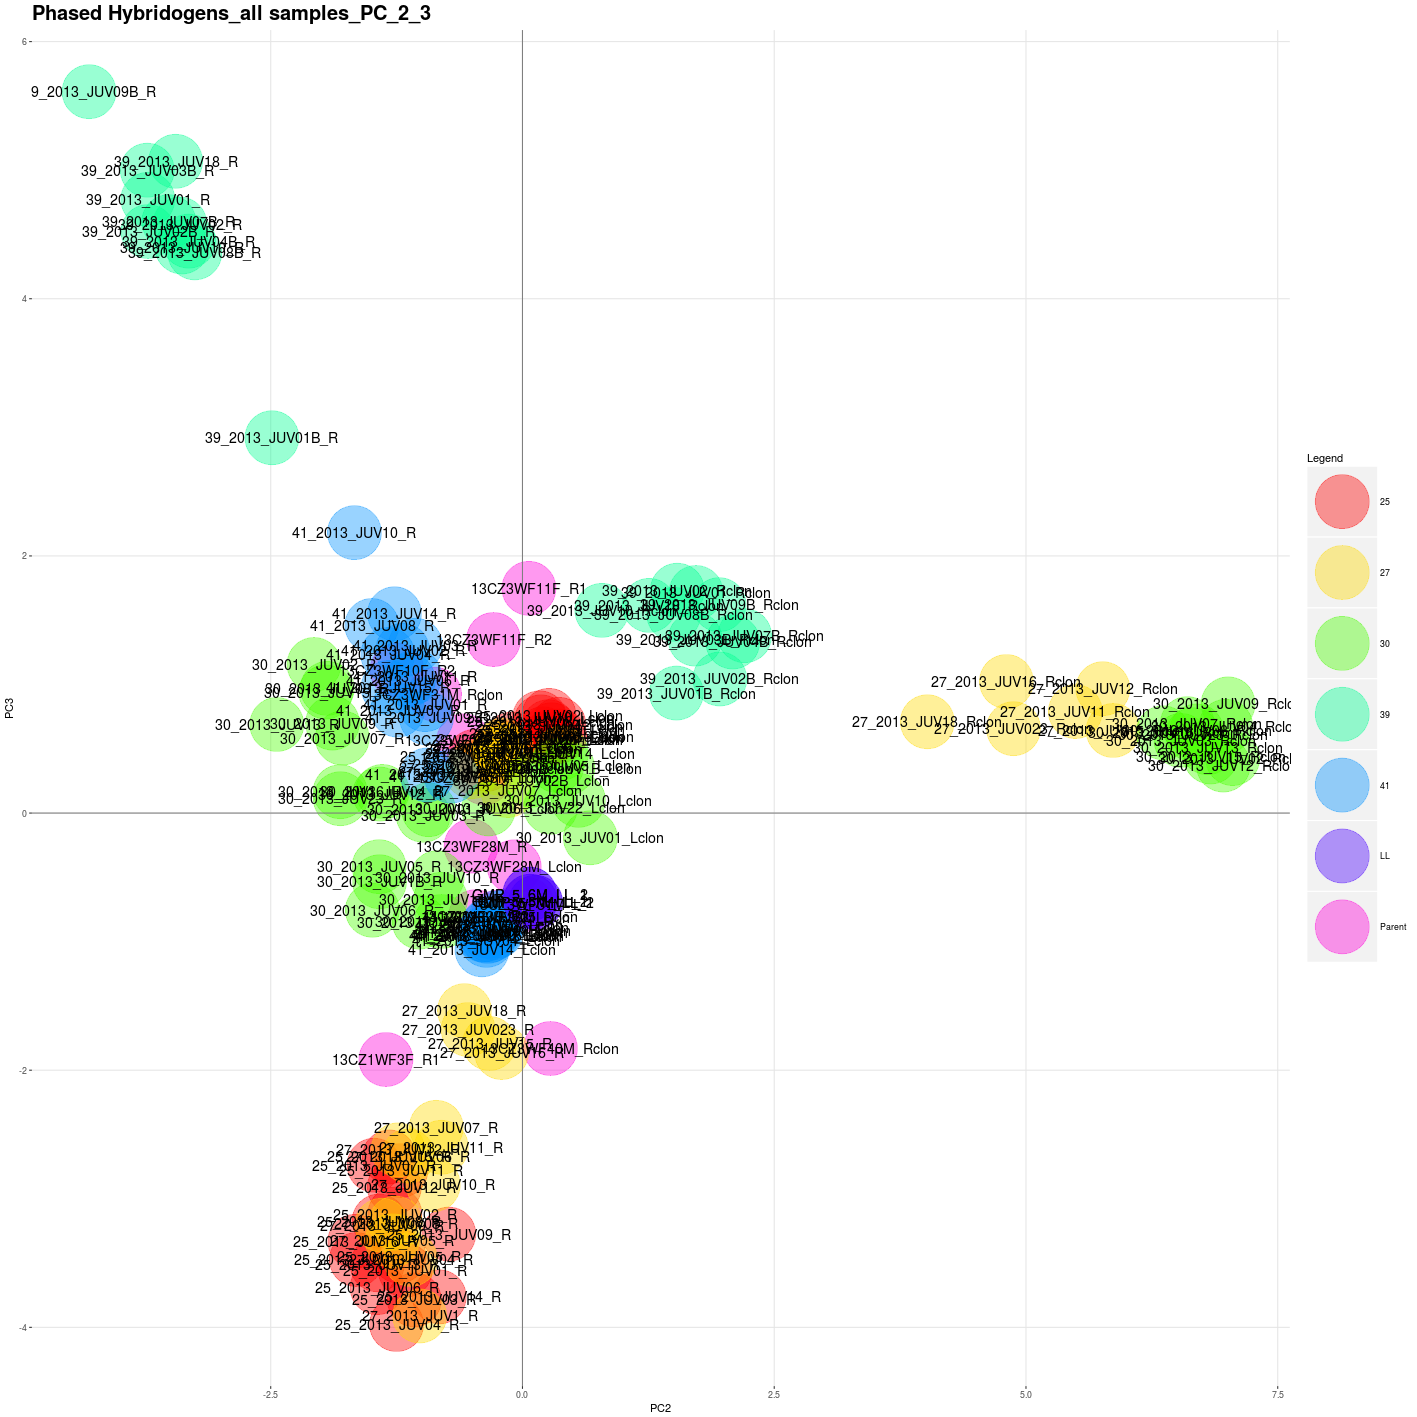

In [79]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.

## Sex information - just a two column text file with the sample name in the first column and the sex (M or F) in the second column. Its for labelling the PCA
sexes <- read.delim("./Data_files/popmap_pops_only_KEPT.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(2,3), ## which components to plotb
           Title = "Phased Hybridogens_all samples_PC_2_3", ## plot title
           xtitle = "PC2", ## X axis title
           ytitle = "PC3", ## Y axis title 
           Palette = rainbow(7), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

So for the R clone, there are very few loci that are kept, mainly because the [R] specific allele is present in some RR samples. Now this is not unexpected, the [R] genome is not likely to have accumulated a lot of private variation as it is reassimilated back into the sexual R pool every generation.

So how many of those loci are in all three [R]'s ?

In [174]:
from collections import Counter
presence = []
for locus in Kept_B_loci:
    counter = 0
    for family in Rclon_fams:
        if locus in family["B_loci"]:
            counter += 1

    presence.append(counter)
Counter(presence)
            

Counter({1: 29, 2: 1})

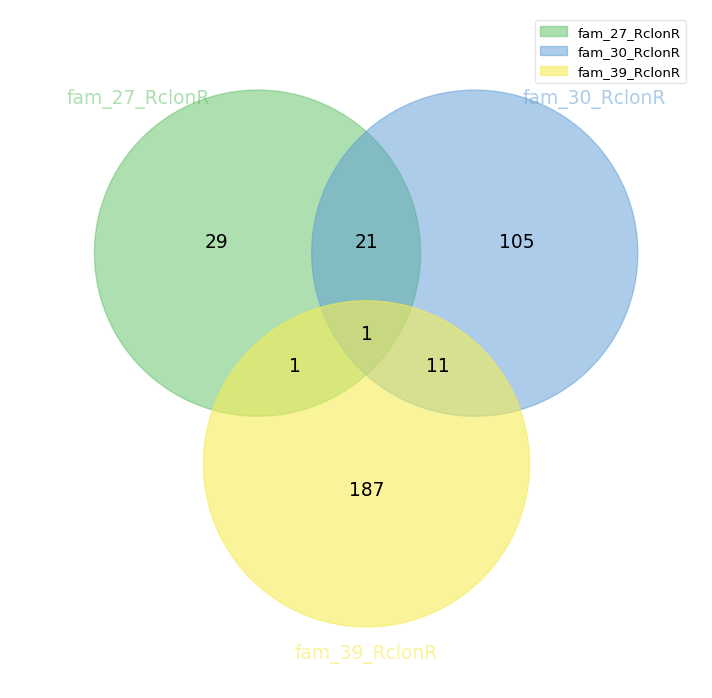

In [168]:
import venn
labels = venn.get_labels([phased_loci_fam_27["B_loci"], phased_loci_fam_30["B_loci"], phased_loci_fam_39["B_loci"]], fill=['number'])
fig, ax = venn.venn3(labels, names=["fam_27_RclonR", "fam_30_RclonR", "fam_39_RclonR"])
fig.show()

Answer, none, 29 out of 30 are phased in only one family. The Venn diagram does suggest that there are more phased loci shared between fam 27 and 30 (which have the same father) and the one locus phased in two families is shared between fams 27 and 30. But overall there is not much consistency between these genomes. 

But if we want to ask where the [R] genomes came from, we could just PCA all RR and [R]R samples together without phasing, that would probably be enough - unless recombination is an issue? 

## Summary

So mission accomplished I think. . . we have phased loci across all families and output the desired haploid VCF for all samples. This VCF was used in the finestructure and phylogenetic analyses later in the paper. 